In [427]:
import matplotlib.pyplot as plt 
import matplotlib.cm as cm
import numpy as np
import pandas as pd 
from Bio import SeqIO
from collections import Counter, defaultdict, OrderedDict
import nltk
from nltk.util import ngrams
import re
from sklearn.linear_model import Lasso, LinearRegression, SGDClassifier, LogisticRegression
import itertools 
import operator
import func_tools 
from sklearn.model_selection import cross_val_score
import pickle
import seaborn as sb
from sklearn.preprocessing import LabelEncoder, StandardScaler, scale
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.cm as cm 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.feature_selection import f_regression, SelectKBest
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, cohen_kappa_score
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import chi2_contingency
import scipy.stats as scs
from itertools import combinations
%matplotlib inline 

In [35]:
reload(func_tools)

<module 'func_tools' from 'func_tools.pyc'>

In [83]:
def word_grams(words, min_v=1, max_v=4):
    s = []
    for n in range(min_v, max_v):
        for ngram in ngrams(words, n):
            s.append(' '.join(str(i) for i in ngram))
    return s

def build_letter_hist(rep, figsize=(5, 5), threshold=0):
    letter_counts = Counter(np.hstack(rep))
    letter_counts_new = drop_rare(letter_counts, threshold=threshold)
    df = pd.DataFrame.from_dict(letter_counts_new, orient='index')
    df.plot(kind='bar', figsize=figsize)

def merge_subarrays(arr):
    return np.hstack(arr)


def drop_rare(counter, threshold=0):
    for k in list(counter):
        if counter[k] < threshold:
            del counter[k]
    return counter


def calculate_prob(words, n=2):
    temp = np.array(list(words))
    result = {}
    for ngram in set(word_grams(words, min_v=n, max_v=n + 1)):
        ngram = ngram.replace(" ", "")
        ngram_positions = [m.start() for m in re.finditer('(?=' + ngram + ')', words)]
        letters_positions = np.array(ngram_positions) + len(ngram)
        letters_position = letters_positions[letters_positions < len(words)]
        counter = dict(Counter(temp[letters_position]))
        total = sum(counter.itervalues(), 0.0)
        counter = {k: 1.0 * v / total for k, v in counter.iteritems()}
        result[ngram] = counter
    return result


def id_to_read(filename):
    inp_seq = SeqIO.parse(filename, "fasta")
    inp_seq = list(inp_seq)
    read_id = [x.id for x in inp_seq]
    inp_reads = [str(x.seq) for x in inp_seq]
    id_to_read = {k: v for k, v in zip(read_id, inp_reads)}
    return id_to_read

def read_repertoire(filename):
    temp = list(SeqIO.parse(filename, "fasta"))
    return [str(x.seq) for x in temp]

def read_rcm(filename):
    rcm = open(filename)
    rcm = rcm.readlines()
    rcm = [x[:-1] for x in rcm]
    return dict(map(lambda x: x.split("\t"), rcm))

def construct_clusters(rcm_dict, id_dict):
    clusters = defaultdict(lambda: [])
    for value, key in rcm_dict.items():
        clusters[key].append(id_dict[value])
    return clusters


def max_character(arr):
    max_ch = 'A'
    for letter in arr:
        if max_ch < letter:
            max_ch = letter
    return max_ch


def min_character(arr):
    min_ch = 'Z'
    for letter in arr:
        if min_ch > letter:
            min_ch = letter
    return min_ch


def cluster_variety(cluster):
    letter_matrix = []
    res = defaultdict(lambda: 0)
    for read in cluster:
        letter_matrix.append(list(read))
    letter_matrix = list(itertools.izip_longest(*letter_matrix))
    for i, row in enumerate(letter_matrix):
        row = [x for x in row if x is not None]
        if max_character(row) != min_character(row):
            res[i] = Counter(row)
    return res


def second_vote(cluster):
    res = defaultdict(lambda: 0)
    for key, value in cluster_variety(cluster).items():
        temp = sorted(value.values())
        res[key] = 1.0 * temp[-2] / len(cluster)
    return res


def major_vote(cluster):
    ans = list(max(cluster, key=len))
    res = {}
    for key, value in cluster_variety(cluster).items():
        temp = sorted(value.items(), key=lambda x: x[1])
        res[key] = temp[-1][0]
    for key in res:
        ans[key] = res[key]
    return ''.join(ans)


def second_votes(clusters):
    res = {}
    for key in clusters:
        res[key] = second_vote(clusters[key])
    return res


def clusters_size_dict(clusters):
    clusters_lenghts = {}
    for key in clusters:
        clusters_lenghts[key] = len(clusters[key])
    return clusters_lenghts


def top_massive_clusters(clusters, res_dict, n=10):
    clusters_lenghts = clusters_size_dict(clusters)
    top_n = [x[0] for x in sorted(clusters_lenghts.items(), key=lambda x: x[1])[-n:]]
    res = []
    fig, axes = plt.subplots(ncols=5, nrows=(n - 1) / 5 + 1, figsize=(20, 10))
    for j, key in enumerate(top_n):
        if not j % 5:
            axes[j / 5, j % 5].set_ylabel('Second Vote')
        res1 = [0] * 500
        for i in range(500):
            res1[i] += res_dict[str(key)][i] / n
        res.append(res1[:])
        axes[j / 5, j % 5].scatter(range(500), res1)
        axes[j / 5, j % 5].set_ylim((0, 0.008))
        axes[j / 5, j % 5].set_xlabel('Position')

    return res

def precision_sensetivity_F1(constructed, reference):
    ref = set(reference)
    con = set(constructed)
    
    ref_con_intersection = ref.intersection(con)
    
    precision = 1.0 * len(ref_con_intersection) / len(con)
    sensitivity = 1.0 * len(ref_con_intersection) / len(ref)
    
    return 2.0 * precision * sensitivity / (precision + sensitivity) 

def split_cluster(cluster, position):
    """
    Try some other variants
    :param cluster:
    :param position:
    :return:
    """

    position_variation = cluster_variety(cluster)[position]
    if not position_variation:
        return [cluster, []]
    letter_for_split = find_max_dict(position_variation)
    first_splitted_part = []
    second_splitted_part = []

    for item in cluster:
        if item[position] == letter_for_split:
            first_splitted_part.append(item)
        else:
            second_splitted_part.append(item)
            
    if len(first_splitted_part) < 5 and len(second_splitted_part) < 5:
        return [[],[]]
    
    elif len(first_splitted_part) < 5 and len(second_splitted_part) >= 5:
        return [second_splitted_part, []]
    
    elif len(first_splitted_part) >= 5 and len(second_splitted_part) < 5:
        return [first_splitted_part, []]
    
    else:
        return (first_splitted_part, second_splitted_part)

def split_by_2nd_vote(cluster):
    max_2nd_vote_pos = find_max_dict(second_vote(cluster))
    return split_cluster(cluster, max_2nd_vote_pos)


def find_max_dict(dictionary):
    return max(dictionary.iteritems(), key=operator.itemgetter(1))[0]

def clusters2rep(clusters):
    rep = {}
    for key in clusters:
        rep[key] = (major_vote(clusters[key]))
    return rep

def quality(constructed_rep, reference, type='sum'):

    if type == 'sum':
        ref = set(reference)
        con = set(constructed_rep)
        
        ref_con_intersection = ref.intersection(con)
    
        precision = 1.0 * len(ref_con_intersection) / len(con)
        sensitivity = 1.0 * len(ref_con_intersection) / len(ref)
        return (precision + sensitivity)/2
    
    elif type == 'F1':
        return precision_sensetivity_F1(constructed_rep, reference)
    
    elif type == 'mult':
        ref = set(reference)
        con = set(constructed_rep)
        
        ref_con_intersection = ref.intersection(con)
    
        precision = 1.0 * len(ref_con_intersection) / len(con)
        sensitivity = 1.0 * len(ref_con_intersection) / len(ref)
        return precision * sensitivity
        
        
def clusters_classification(clusters, reference, constructed_rep):
    print "Repertoire construction started"
    #constructed_rep = clusters2rep(clusters)
    print "END"
    quality_0 = quality(constructed_rep.values(), reference)
    res = {}
    new_num = max([int(key) for key in clusters.keys()]) + 1 
    for i, key in enumerate(clusters):
        if i%1000 == 0:
            print i
        if not second_vote(clusters[key]):
            res[key] = 0
            continue
        first_part, second_part = split_by_2nd_vote(clusters[key])
        temp_clusters = constructed_rep.copy()
        temp_clusters[key] = major_vote(first_part)
        temp_clusters[new_num] = major_vote(second_part)
        curr_quality = precision_sensetivity_F1(temp_clusters.values(), reference)
        if curr_quality > quality_0:
            quality_0 = curr_quality
            res[key] = 1
        elif curr_quality < quality_0:
            res[key] = -1
        else:
            res[key] = 0
    return res 

def simple_clusters_classification(clusters, reference, constructed_rep):
    ref = set(reference)
    res = {}
    for i, key in enumerate(clusters):

        if i%100 == 0:
            print i
            
        if not second_vote(clusters[key]):
            res[key] = -1
            continue
            
        first_part, second_part = split_by_2nd_vote(clusters[key])
        first_cons, second_cons = major_vote(first_part), major_vote(second_part)
        cluster_major = major_vote(clusters[key])
        
        if cluster_major in ref: 
            if ((first_cons in ref) and (second_cons not in ref)) or ((second_cons in ref) and (first_cons not in ref)):
                res[key] = -1

            elif ((first_cons in ref) and (second_cons in ref)):
                res[key] = 1

            elif ((first_cons not in ref) and (second_cons not in ref)):
                res[key] = -1
        else:
            if ((first_cons in ref) and (second_cons not in ref)) or ((second_cons in ref) and (first_cons not in ref)):
                res[key] = 1

            elif ((first_cons in ref) and (second_cons in ref)):
                res[key] = 1

            elif ((first_cons not in ref) and (second_cons not in ref)):
                res[key] = -1
    return res 
            
        
def clusters_filtering(clusters, threshold=5):
    filtered_clusters = {}
    for key in clusters:
        if len(clusters[key]) > threshold:
            filtered_clusters[key] = clusters[key]
    return filtered_clusters

In [214]:
def categories(series):
    return range(int(series.min()), int(series.max()) + 1)


def chi_square_of_df_cols(df, col1, col2):
    df_col1, df_col2 = df[col1], df[col2]

    result = [[sum((df_col1 == cat1) & (df_col2 == cat2))
               for cat2 in categories(df_col2)]
              for cat1 in categories(df_col1)]
    
    return scs.chi2_contingency(result)

In [201]:
chi_square_of_df_cols(scaled_mix_df, 'context2_T', 'context2_T')

[[45541, 0], [0, 5461]]


(50991.541307163832, 0.0, 1, array([[ 40664.73238304,   4876.26761696],
        [  4876.26761696,    584.73238304]]))

In [3]:
read_seq = SeqIO.parse("/Users/Macbook/GitHub/ig_repertoire_constructor/igrec_test/final_repertoire.fa", "fasta")

In [4]:
rep = [np.array(seq.seq) for seq in read_seq] 

(array([  6.,  10.,  31.,  59.,  88.,  91.,  31.,  14.,  10.,   4.]),
 array([ 337. ,  343.6,  350.2,  356.8,  363.4,  370. ,  376.6,  383.2,
         389.8,  396.4,  403. ]),
 <a list of 10 Patch objects>)

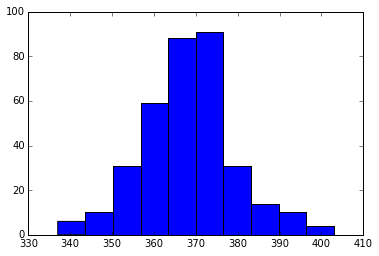

In [60]:
plt.hist([len(item) for item in rep])

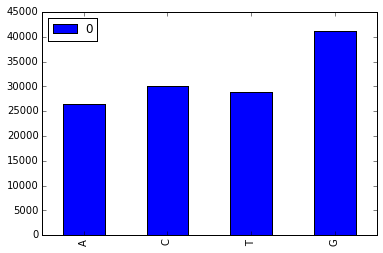

In [61]:
letter_counts = Counter(np.hstack(rep))
df = pd.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')

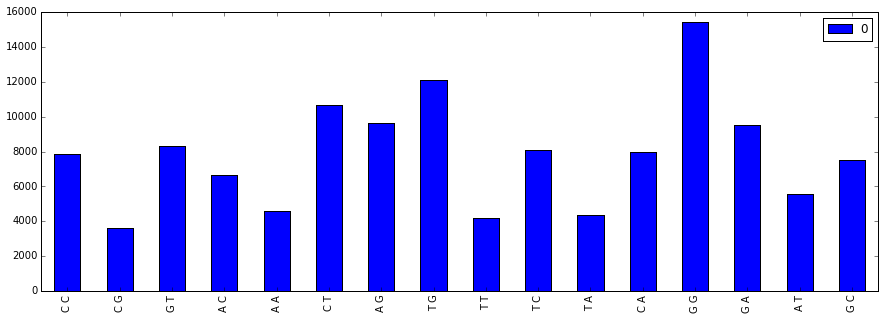

In [98]:
two_grams = map(lambda x: word_grams(x, min=2, max=3), rep)
build_letter_hist(two_grams, figsize=(15,5))

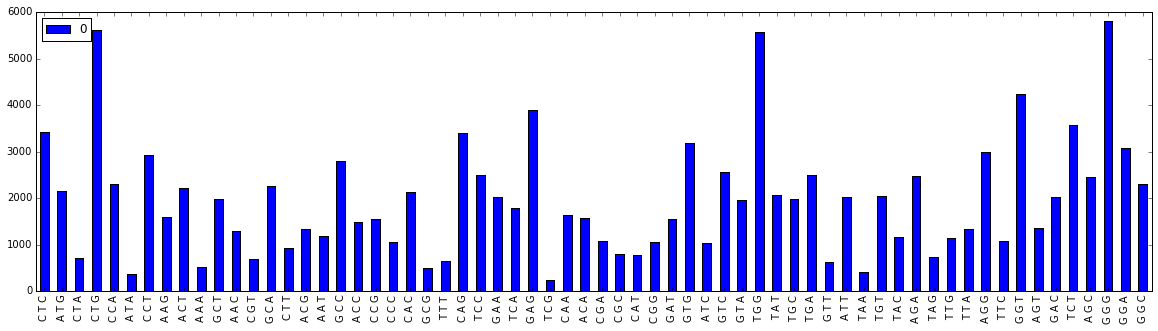

In [99]:
three_grams = map(lambda x: word_grams(x, min=3, max=4), rep)
build_letter_hist(three_grams, figsize=(20, 5))

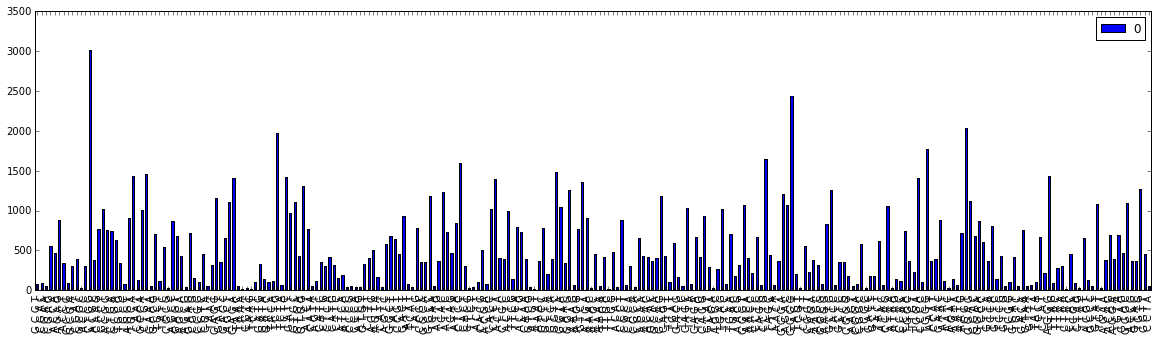

In [100]:
four_grams = map(lambda x: word_grams(x, min=4, max=5), rep)
build_letter_hist(four_grams, figsize=(20, 5))

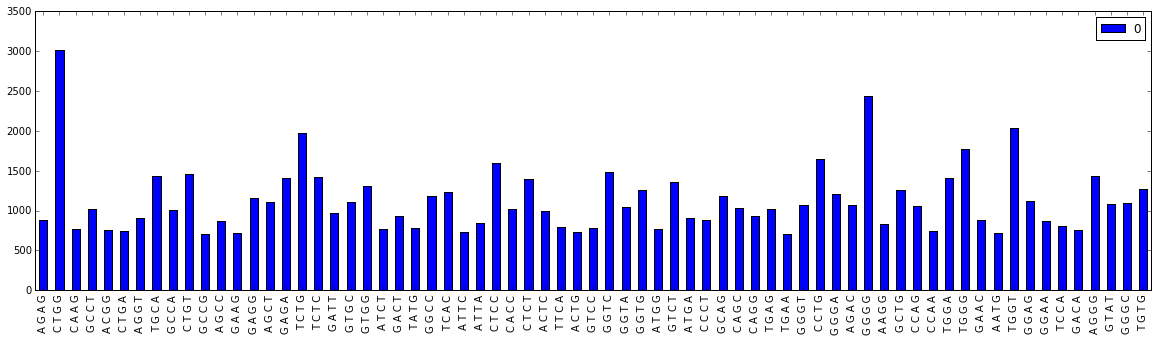

In [101]:
build_letter_hist(four_grams, figsize=(20, 5), threshold=700)

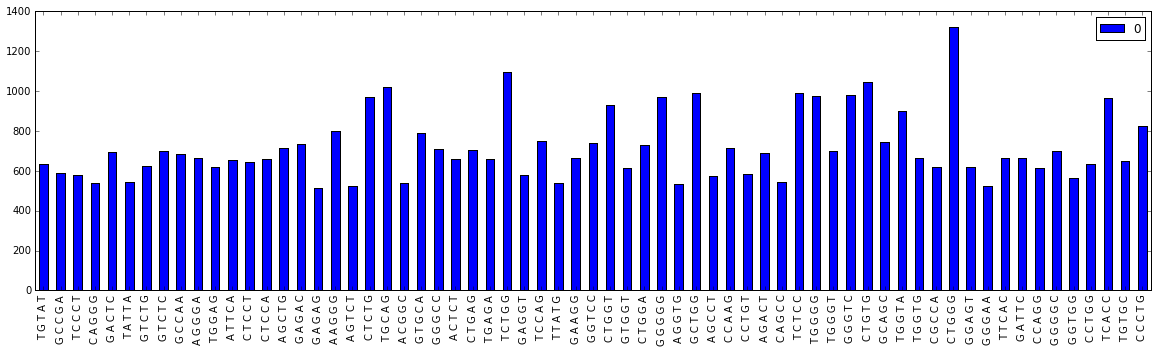

In [103]:
five_grams = map(lambda x: word_grams(x, min=5, max=6), rep)
build_letter_hist(five_grams, figsize=(20, 5), threshold=500)

Очень много 6-мер повторяются примерно одинаковое количество раз и есть не так много (20-30) 6-мер, которые под это правило не подходят 

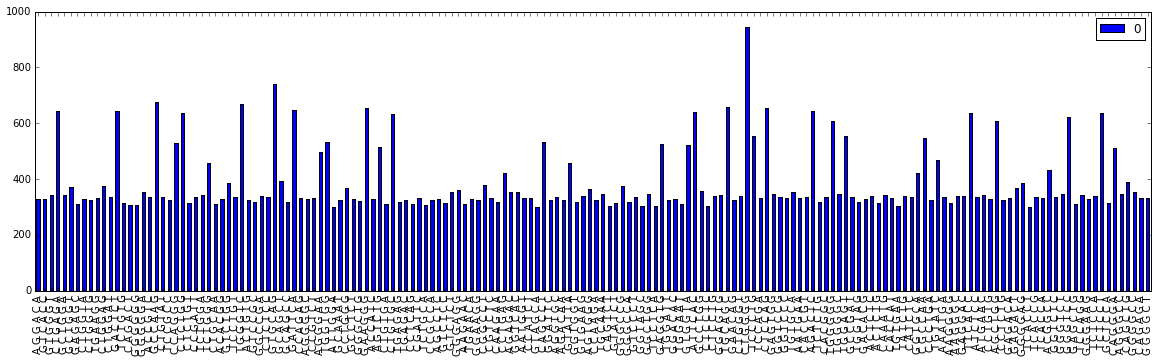

In [315]:
six_grams = map(lambda x: word_grams(x, min=6, max=7), rep)
build_letter_hist(six_grams, figsize=(20, 5), threshold=300)

In [141]:
seven_grams = map(lambda x: word_grams(x, min=7, max=8), rep)
build_letter_hist(seven_grams, figsize=(20, 5), threshold=300)

ERROR! Session/line number was not unique in database. History logging moved to new session 299


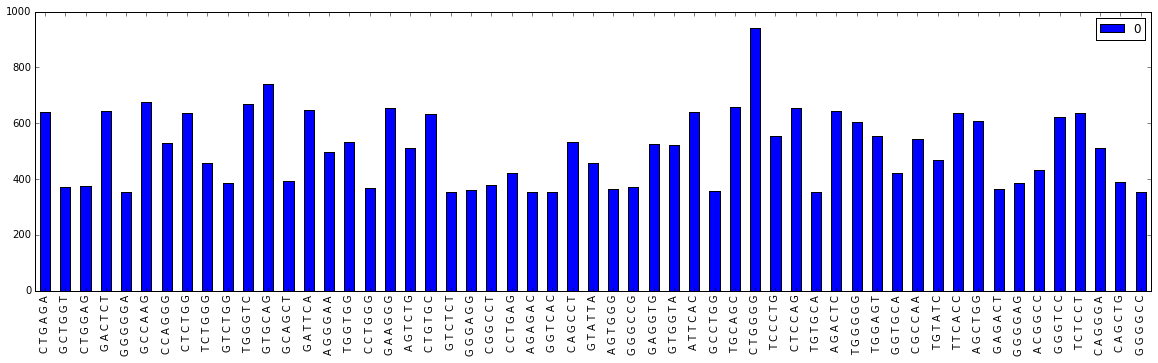

In [109]:
build_letter_hist(six_grams, figsize=(20, 5), threshold=350)

# INPUT 

In [21]:
# id_dict - dict with ids -> read
# rep - reference repertoire, array of reads
# rcm - reference repertoire, dict with ids -> cluster number
id_dict = func_tools.id_to_read('data/age3/input_reads.fa')
rep = func_tools.read_repertoire('data/age3/repertoire.fa')
rcm = func_tools.read_rcm("data/age3/repertoire.rcm")

In [50]:
# clusters - dict with ids -> array of read included in this cluster
clusters = construct_clusters(rcm, id_dict)

In [51]:
# final_rcm - final clusters description 
final_rcm = read_rcm('final_repertoire.rcm')

In [119]:
# dict with ids -> array of read included in this cluster
final_clusters = construct_clusters(final_rcm, id_dict)

In [120]:
# final_rep - final repertoire constructed by igrec
final_rep = clusters2rep(clusters_filtering(final_clusters))

In [121]:
# final_res - same as res calculated for igrec results 
final_res = second_votes(clusters_filtering(final_clusters))

In [54]:
# res - dict with second votes calculated for every position in cluster
# final_res - same as res calculated for igrec results 
res = second_votes(clusters)
final_res = second_votes(clusters_filtering(final_clusters))

In [125]:
with open('final_clusters.pkl', 'wb') as output:
    pickle.dump(dict(clusters_filtering(final_clusters)), output, pickle.HIGHEST_PROTOCOL)

with open('final_rep.pkl', 'wb') as output:
    pickle.dump(dict(final_rep), output, pickle.HIGHEST_PROTOCOL)

with open('final_res.pkl', 'wb') as output:
    pickle.dump({k:dict(v) for k,v in final_res.items()}, output, pickle.HIGHEST_PROTOCOL)

In [5]:
with open('/Users/Macbook/GitHub/ig_cluster_splitter/data/age3/final_clusters.pkl', 'rb') as inputio:
    final_clusters = pickle.load(inputio)
with open('/Users/Macbook/GitHub/ig_cluster_splitter/data/age3/final_rep.pkl', 'rb') as inputio:
    final_rep = pickle.load(inputio)
with open('/Users/Macbook/GitHub/ig_cluster_splitter/data/age3/final_res.pkl', 'rb') as inputio:
    final_res = pickle.load(inputio)

Гистограмма для распределения second vote внутри одного из кластеров 

<Container object of 358 artists>

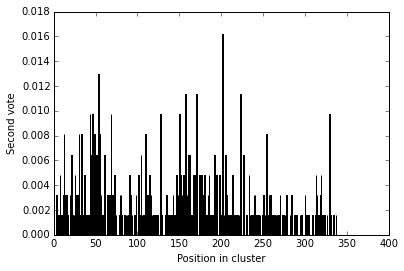

In [55]:
fig = plt.figure()
temp_dict = second_vote(clusters['4'])
temp_arr = [temp_dict[x] for x in range(len(clusters['4'][0]))]
plt.ylabel('Second vote')
plt.xlabel('Position in cluster')
plt.bar(range(len(clusters['4'][0])), temp_arr)
#fig.savefig('second_vote.pdf', format='pdf')

<Container object of 349 artists>

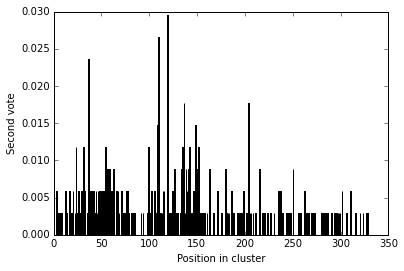

In [56]:
fig = plt.figure()
temp_dict = second_vote(clusters['11'])
temp_arr = [temp_dict[x] for x in range(len(clusters['11'][0]))]
plt.ylabel('Second vote')
plt.xlabel('Position in cluster')
plt.bar(range(len(clusters['11'][0])), temp_arr)
#fig.savefig('second_vote.pdf', format='pdf')

Гистограмма для распределения для second vote 
Видно, что много кластеров имеют second vote ~ 0.5

(0, 0.6)

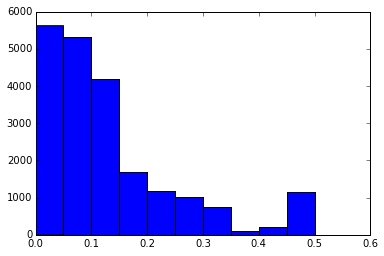

In [97]:
res1 = []
for key in res:
    res1.append(np.max(res[key].values()) if len(res[key].values()) else 0)
plt.hist(res1)
plt.xlim((0, 0.6))

<Container object of 500 artists>

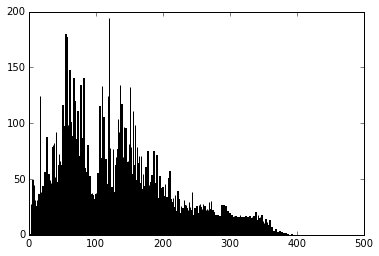

In [16]:
res1 = [0]*500
for key in range(21200):
    for i in range(500):
        if res_dict[str(key)][i] > 0.05:
            res1[i] += res_dict[str(key)][i]
plt.bar(range(500), res1)

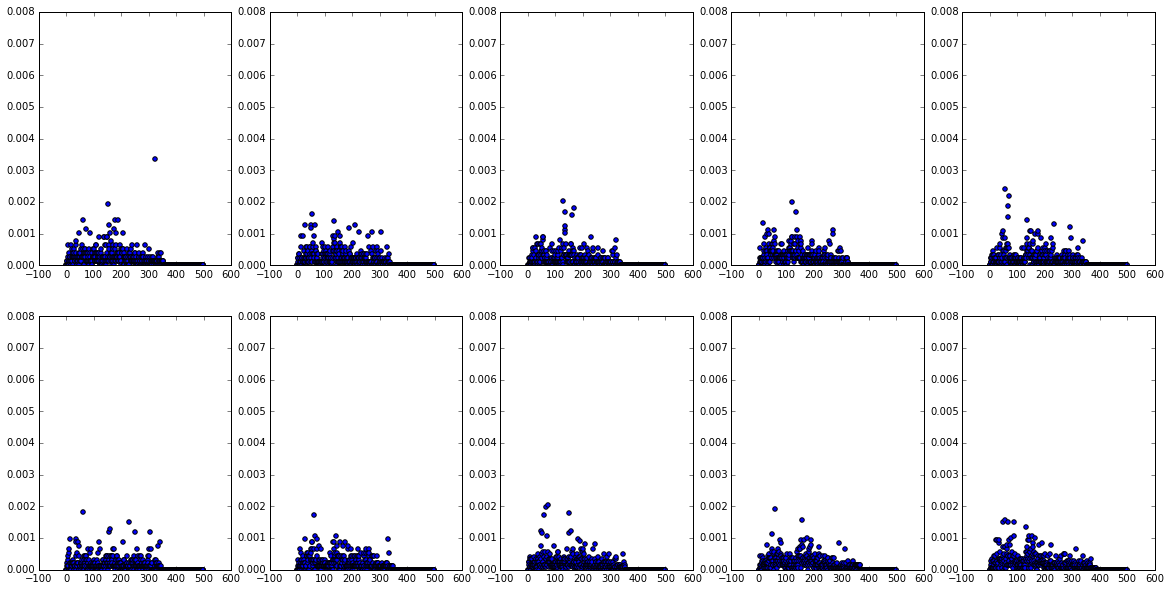

In [32]:
top_10 = top_massive_clusters(clusters, 10)

<Container object of 500 artists>

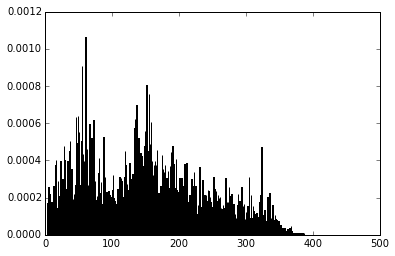

In [54]:
plt.bar(range(500), np.mean(top_10, axis=0))

In [49]:
max_second_vote = {key:(np.max(res[key].values()) if len(res[key].values()) else 0) for key in res}

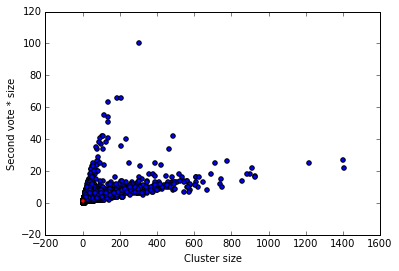

In [88]:
dots = [] 
sizes = clusters_size_dict(clusters)
for key in sizes:
    dots.append((sizes[key], sizes[key]*max_second_vote[key], clf_f1[key]))
plt.scatter([x[0] for x in dots if x[2] == -1], [x[1] for x in dots if x[2] == -1], c='b')
plt.scatter([x[0] for x in dots if x[2] == 0], [x[1] for x in dots if x[2] == 0], c='k')
plt.scatter([x[0] for x in dots if x[2] == 1], [x[1] for x in dots if x[2] == 1], c='r')
plt.ylabel("Second vote * size")
plt.xlabel("Cluster size")

(0, 10)

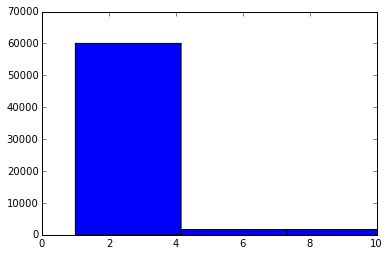

In [103]:
plt.hist(clusters_size_dict(final_clusters).values(), bins=400)
plt.xlim((0, 10))

In [30]:
major_vote(final_clusters['1'])

'CAGCTGCAGCTGCAGGAGTCGGGCCCAGGCCTAGTGAAGCCTTCGGAGACCCTCTCCCTCACCTGCAATGTCTCCGGTGACTCCGTCAGCGGTAGTTTTTACTCCTGGGCCTGGATACGACAGTCCCCAGGGAGGGGACTGGAGTGGATTGGAAGTGTCTCTTCCAGTAGGACCCCTTACTACAACCCGTCTTTCAAAAGTCAAGTCAGCATATCCAGAGACACGTCCAAGAACCAATTCACCCTGCAGTTGACCGCTGTGACCGCCGCGGACATGGCCGTTTATTATTGTGCGAGAGAGGGCGGGAGTTACCTCCTTAACTTCTGGGGCCAGGGAACCCTGGTCACCGTCTCCTCAG'

In [42]:
c = set()
for key in final_clusters:
    if len(final_clusters[key]) < 5 and major_vote(final_clusters[key]) in rep:
        c.add(major_vote(final_clusters[key]))

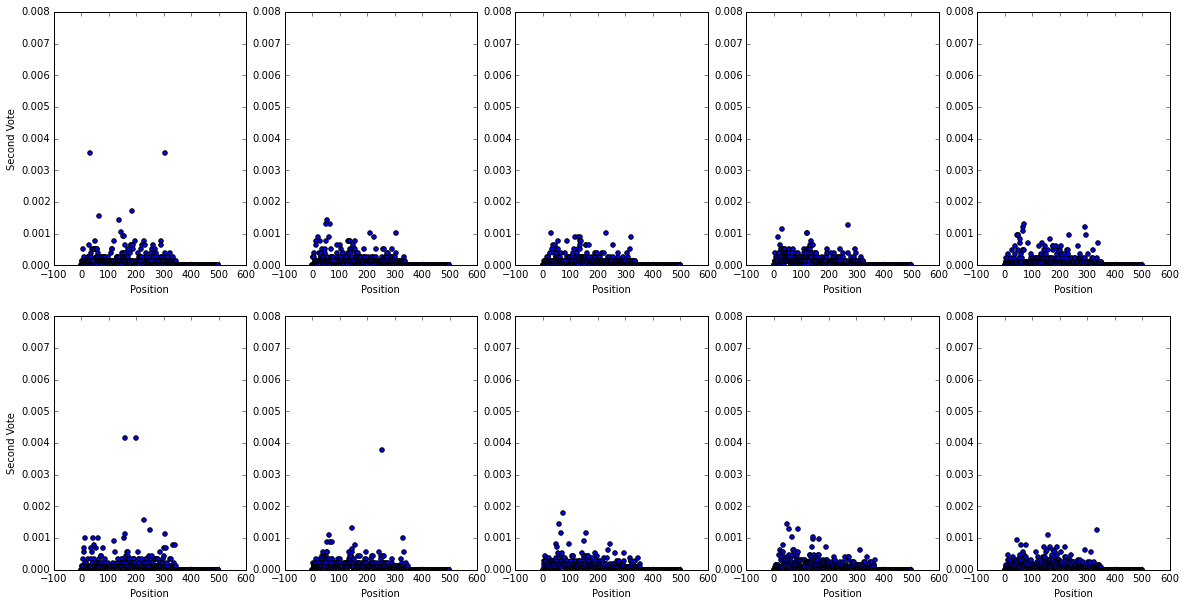

In [61]:
top_fin_10 = top_massive_clusters(final_clusters, final_res)

<Container object of 500 artists>

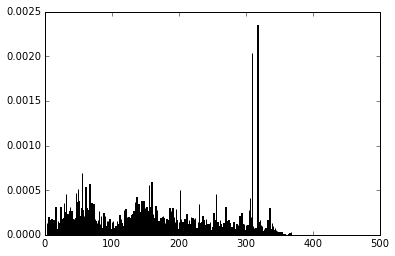

In [62]:
plt.bar(range(500), np.mean(top_fin_10, axis=0))

In [67]:
max_final_second_vote = {key:(np.max(final_res[key].values()) if len(final_res[key].values()) else 0) for key in final_res}

10

In [ ]:
dots = [] 
sizes = clusters_size_dict(clusters_filtering(final_clusters))
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,5))
for key in sizes:
    dots.append((sizes[key], sizes[key]*max_final_second_vote[key], final_clf_sum[key]))
axes[0].scatter([x[0] for x in dots if x[2] == -1], [x[1] for x in dots if x[2] == -1], c='b', label='Quality decreased')
axes[0].scatter([x[0] for x in dots if x[2] == 0], [x[1] for x in dots if x[2] == 0], c='k')
axes[0].scatter([x[0] for x in dots if x[2] == 1], [x[1] for x in dots if x[2] == 1], c='r', label='Quality increased')

classifier = Lasso()
classifier.fit(np.array(dots)[:,[0,1]], np.array(dots)[:,2]) 
axes[0].plot(range(1000),np.poly1d(classifier.coef_)(range(1000)))

classifier = SGDClassifier()
classifier.fit(np.array(dots)[:,[0,1]], np.array(dots)[:,2]) 
for coef_ in classifier.coef_:
    axes[0].plot(range(1000),np.poly1d(coef_)(range(1000)))

axes[0].legend()
axes[0].set_xlim((-1, 1300))
axes[0].set_ylim((-1, 200))
axes[0].set_ylabel("Second vote * size")
axes[0].set_xlabel("Cluster size")

axes[1].hist(final_clf_sum.values())

fig.savefig('graph.pdf', format='pdf')

In [11]:
ans = simple_clusters_classification(clusters_filtering(final_clusters), rep)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500


In [12]:
with open('ans_dict.pkl', 'wb') as output:
    pickle.dump(dict(ans), output, pickle.HIGHEST_PROTOCOL)

In [154]:
max_final_second_vote = {key:(np.max(final_res[key].values()) if len(final_res[key].values()) else 0) for key in final_res}

(array([ 13974.,      0.,      0.,      0.,      0.,     29.,      0.,
             0.,      0.,    512.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 10 Patch objects>)

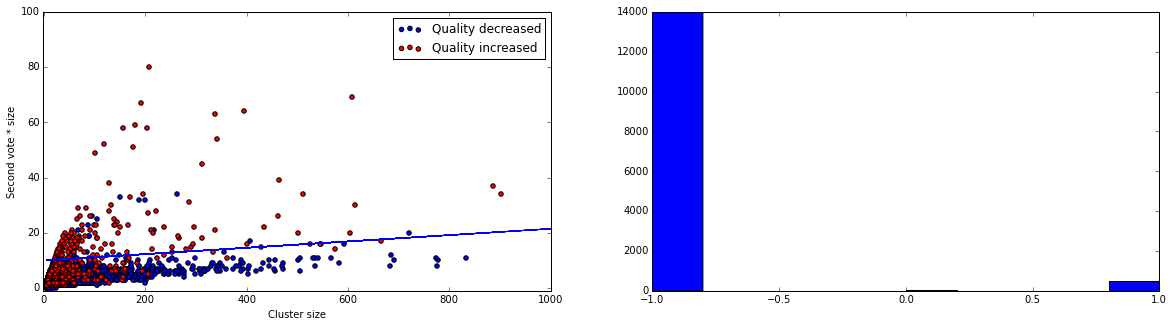

In [171]:
dots = [] 
sizes = clusters_size_dict(clusters_filtering(final_clusters))
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20,5))
for key in sizes:
    dots.append((sizes[key], sizes[key]*max_final_second_vote[key], r[key] if r[key] else -1))
axes[0].scatter([x[0] for x in dots if x[2] == -1], [x[1] for x in dots if x[2] == -1], c='b', label='Quality decreased')
axes[0].scatter([x[0] for x in dots if x[2] == 0], [x[1] for x in dots if x[2] == 0], c='k')
axes[0].scatter([x[0] for x in dots if x[2] == 1], [x[1] for x in dots if x[2] == 1], c='r', label='Quality increased')

classifier = LogisticRegression()
classifier.fit(np.array(dots)[:,[0,1]], np.array(dots)[:,2])

def log_func(x):
    return (-classifier.intercept_ - classifier.coef_[0][0] * x)/classifier.coef_[0][1]
axes[0].plot(np.array(dots)[:,0], map(log_func, np.array(dots)[:,0]))

axes[0].legend()
axes[0].set_xlim((-1, 1000))
axes[0].set_ylim((-1, 100))
axes[0].set_ylabel("Second vote * size")
axes[0].set_xlabel("Cluster size")

axes[1].hist(r.values())

In [176]:
cross_val_score(classifier, np.array(dots)[:,[0,1]], np.array(dots)[:,2], cv=5).mean()

0.97278705455532832

# AGE3 Dataset

In [139]:
df = build_df_test(igrec_clusters=clusters_filtering(final_clusters),
              igrec_rep=final_rep,
              igrec_res=final_res)

build_df started
calculation step
parsing step
context step
mutation step
building succeeded


In [29]:
df = pd.read_csv('data/age3/first_df.csv', index_col='Unnamed: 0')
df = df.drop(['CDR1_end.1', 'CDR2_end.1', 'CDR3_end.1', 'CDR1_end', 'CDR2_end', 'CDR3_end'], axis=1)

/Users/Macbook/anaconda/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/Users/Macbook/anaconda/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


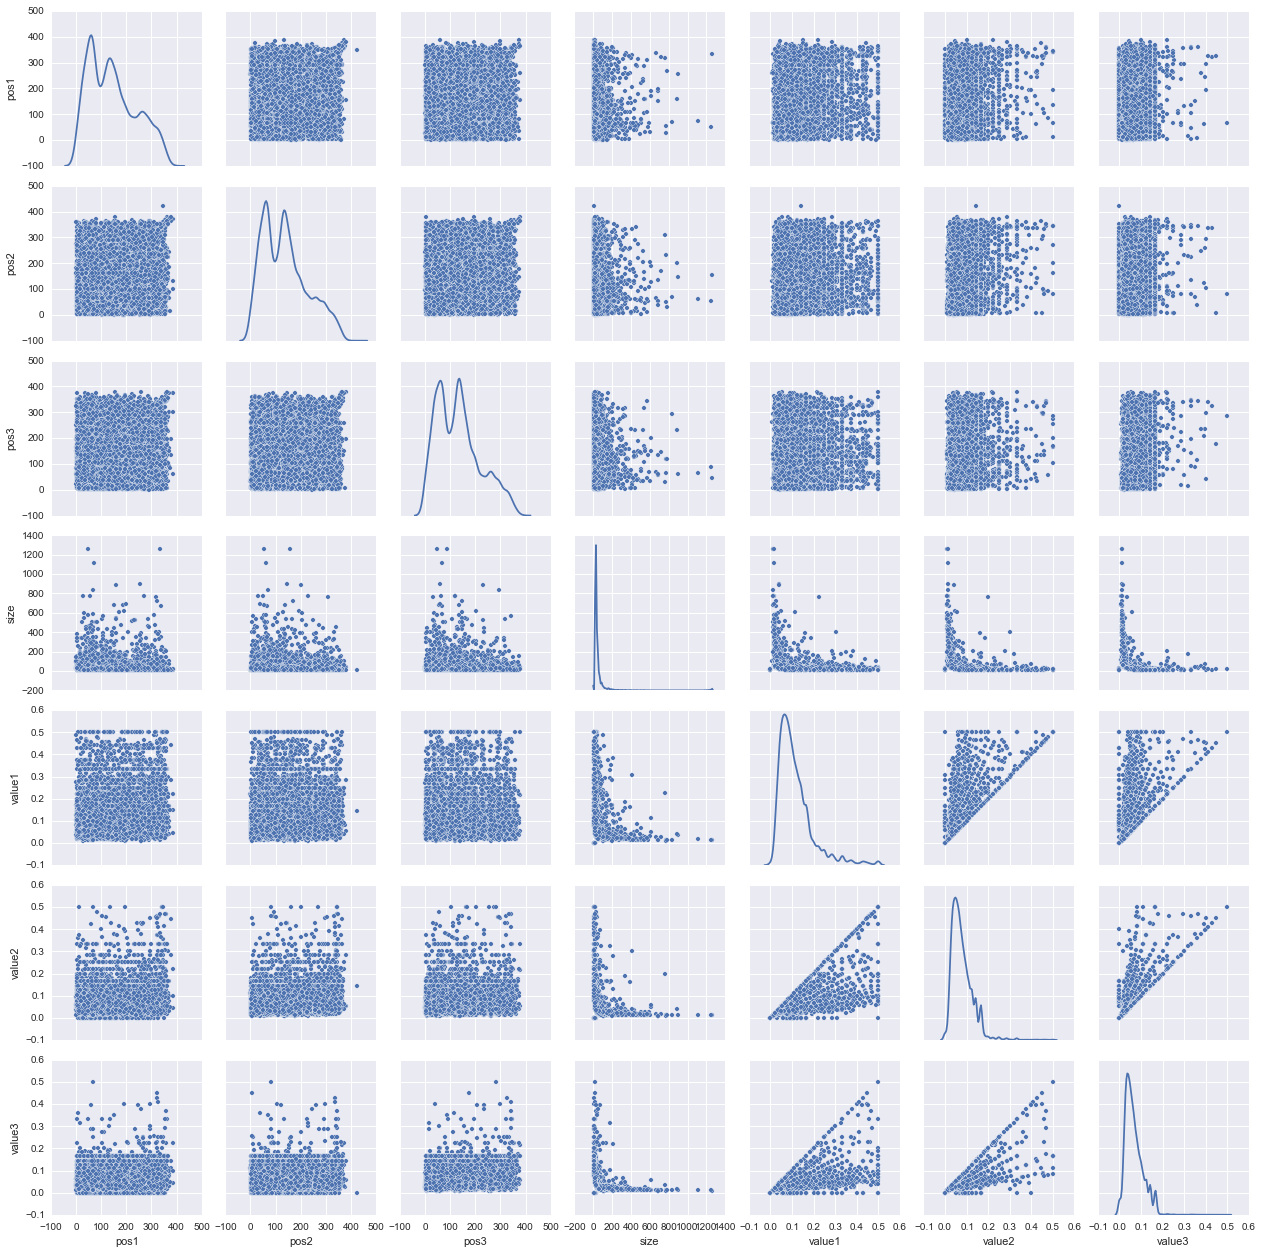

In [145]:
sb.pairplot(df, diag_kind='kde')

In [26]:
cdr_df = pd.read_csv('data/age3/cdr/cdr_details.txt', delimiter='\t')

/Users/Macbook/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [27]:
cdr = cdr_df[['CDR1_start', 'CDR2_start', 'CDR3_start', 'CDR1_end', 'CDR2_end', 'CDR3_end']]

In [30]:
new_df = pd.concat([df, cdr], axis=1).dropna()

In [31]:
new_df.head()

context1  context2  context3  context4  context5  mutated_letter   pos1  \
0       3.0       3.0       3.0       3.0       2.0             4.0   44.0   
2       3.0       4.0       3.0       2.0       1.0             4.0   66.0   
5       3.0       3.0       3.0       1.0       2.0             1.0  353.0   
7       2.0       4.0       2.0       3.0       3.0             1.0   49.0   
8       1.0       2.0       3.0       3.0       2.0             4.0  275.0   

    pos2   pos3  size    value1    value2    value3  CDR1_start  CDR2_start  \
0   19.0    7.0  52.0  0.038462  0.038462  0.019231          76         151   
2   36.0  108.0  27.0  0.148148  0.074074  0.074074          76         151   
5  230.0  155.0  23.0  0.130435  0.086957  0.086957          76         151   
7  162.0  323.0  15.0  0.200000  0.066667  0.066667          76         151   
8  150.0  317.0  59.0  0.050847  0.033898  0.033898          76         157   

  CDR3_start  CDR1_end  CDR2_end CDR3_end  
0        289        99       174      315  
2        289        99       174      321  
5        286        99       171      342  
7        289        99       174      333  
8        292       105       177      360

In [200]:
coder = LabelEncoder()
coder.fit(new_df['context1'])
new_df.context1 = coder.transform(new_df['context1'])
new_df.context2 = coder.transform(new_df['context2'])
new_df.context3 = coder.transform(new_df['context3'])
new_df.context4 = coder.transform(new_df['context4'])
new_df.context5 = coder.transform(new_df['context5'])
new_df.mutated_letter = coder.transform(new_df['mutated_letter'])

new_df.CDR3_start = new_df.CDR3_start.map(int)
new_df.CDR3_end = new_df.CDR3_end.map(int)

## Heatmap

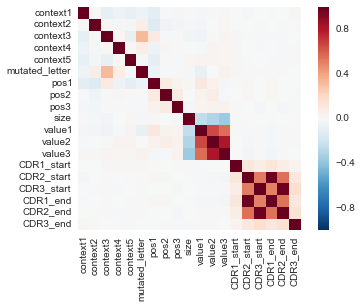

In [208]:
fig = plt.figure()
sb.heatmap(new_df.corr(), square=True)
fig.savefig('heatmap.pdf', format='pdf')

In [250]:
new_df.CDR3_start = new_df.CDR3_end.map(int)

## tSNE

In [ ]:
data = scale(new_df)
tsne = TSNE(n_components=2, init='pca', random_state=321)
tsne_representation = tsne.fit_transform(data)

In [72]:
tsne_representation = np.fromfile('tsne_rep.npy')

In [93]:
tsne_representation = tsne_representation.reshape(len(tsne_representation)/2, 2)

In [133]:
tsne_representation

array([[  1.87585069e-309,   1.17119999e+171],
       [  5.22741680e-037,   8.44740097e+252],
       [  2.65141232e+180,   9.92152605e+247],
       ..., 
       [ -5.23094921e-001,  -9.94869598e-001],
       [ -2.23033346e+000,   3.64935438e+000],
       [ -2.88330638e+000,  -6.82663093e+000]])

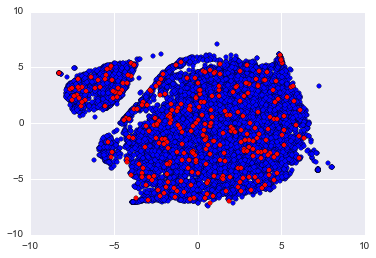

In [169]:
dots = np.array(zip(tsne_representation, list(full_df.quality_imp)))
fig = plt.figure()
plt.scatter([x[0] for x in dots[dots[:, 1]==-1][:, 0]], [x[1] for x in dots[dots[:, 1]==-1][:, 0]], c='b')
plt.scatter([x[0] for x in dots[dots[:, 1]==1][:, 0]], [x[1] for x in dots[dots[:, 1]==1][:, 0]], c='r')
plt.xlim((-10, 10))
plt.ylim(-10, 10)
fig.savefig('tSNEd.png', format='png')

## Pair Plots

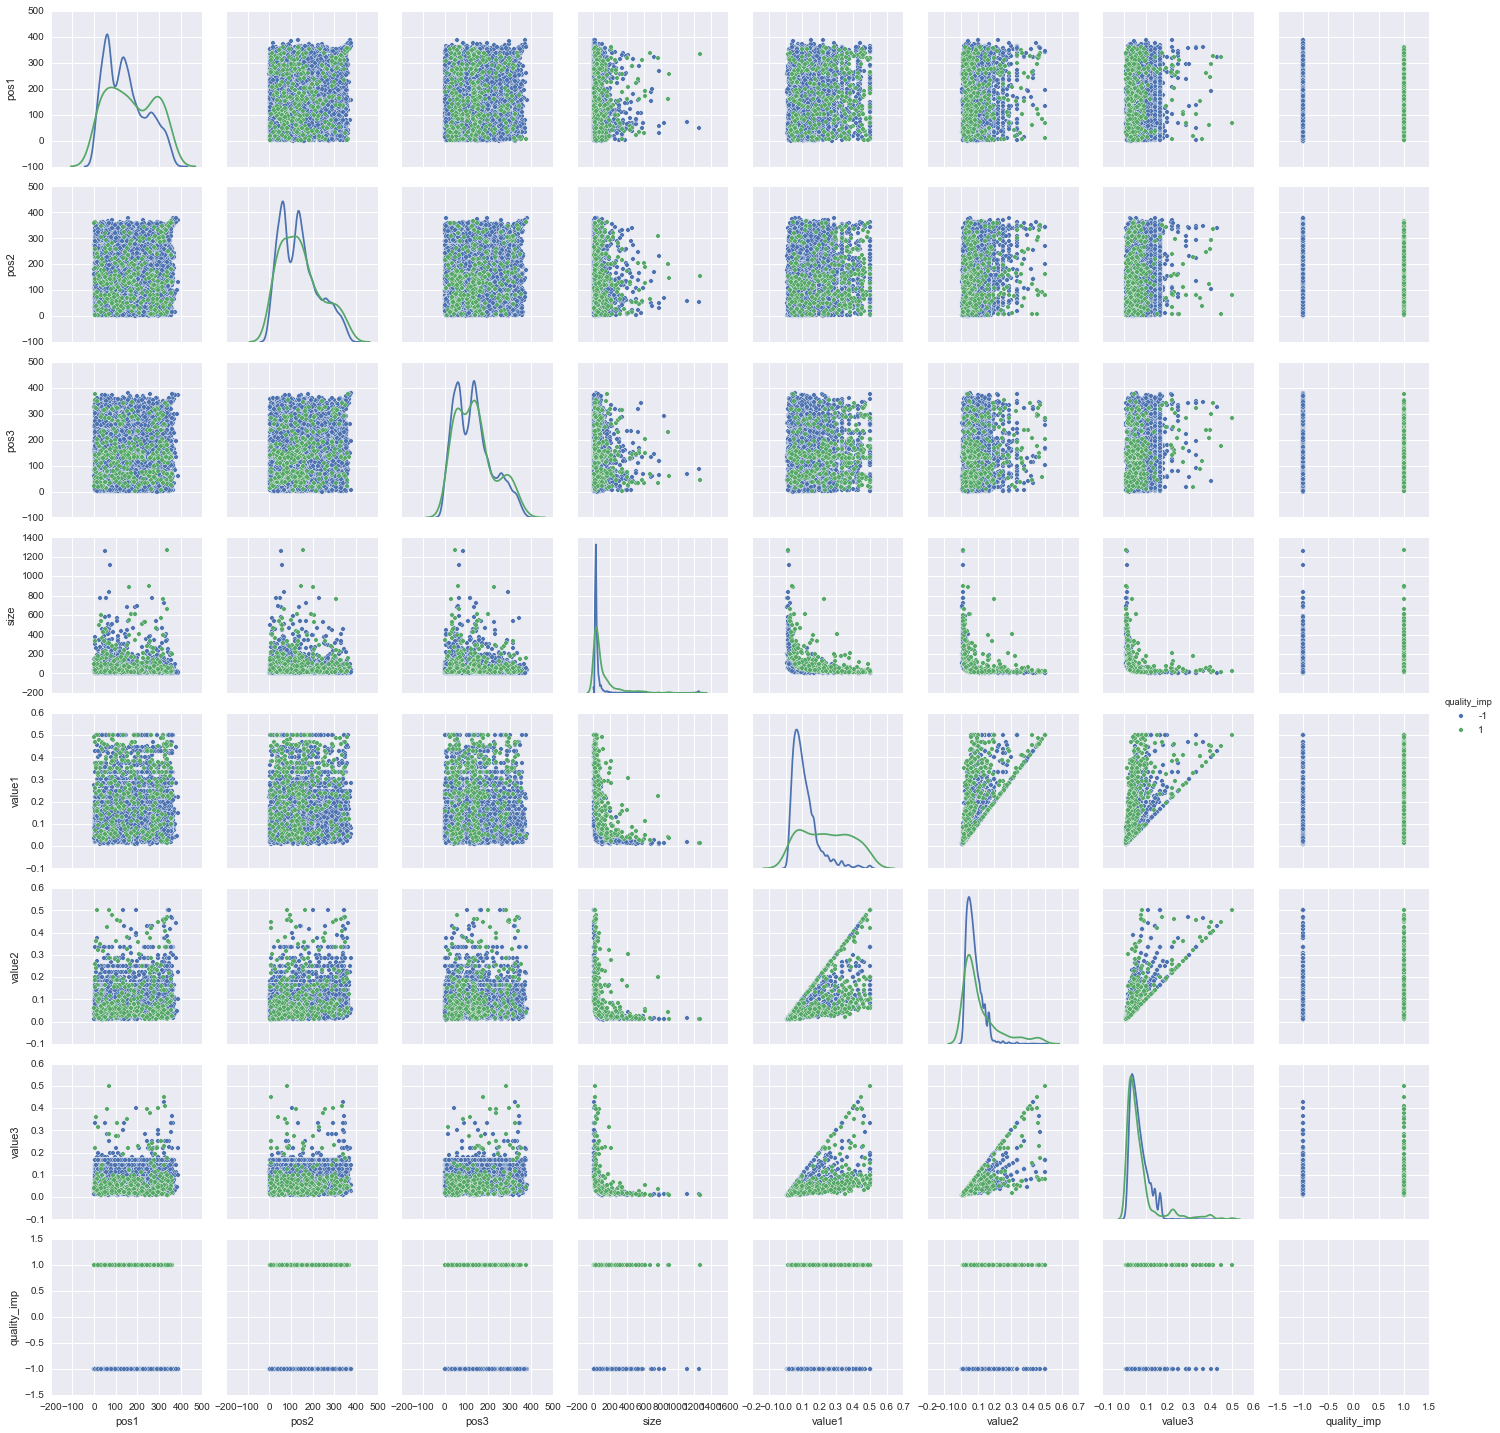

In [235]:
sb.pairplot(full_df.drop(list(full_df.columns[:6])+
             ['first_cluster', 'origin_cluster', 'second_cluster']+
             ['CDR1_start', 'CDR2_start', 'CDR3_start']+
             ['CDR1_end', 'CDR2_end', 'CDR3_end'], axis=1), 
            hue='quality_imp',
            diag_kind='kde')

## PCA

In [251]:
pca = PCA(n_components=19)

In [328]:
pca_representation = pca.fit_transform(scale(full_df[full_df.columns[:-4]]))

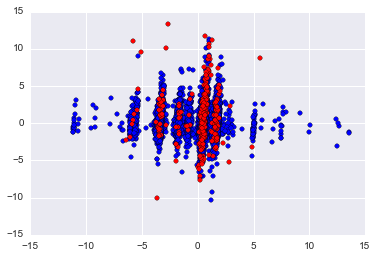

In [329]:
dots = np.array(zip(pca_representation, list(full_df.quality_imp)))
fig = plt.figure()
plt.scatter([x[0] for x in dots[dots[:, 1]==-1][:, 0]], [x[1] for x in dots[dots[:, 1]==-1][:, 0]], c='b')
plt.scatter([x[0] for x in dots[dots[:, 1]==1][:, 0]], [x[1] for x in dots[dots[:, 1]==1][:, 0]], c='r')
#fig.savefig('tSNEd.png', format='png')

<Container object of 19 artists>

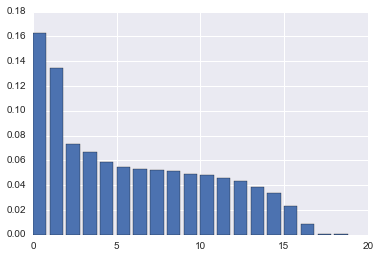

In [341]:
plt.bar(range(19), pca.explained_variance_ratio_)

In [340]:
print full_df[full_df.columns[:-4]].columns[[14,15,16,17]]
print full_df[full_df.columns[:-4]].columns[[9,10,11,12]]

Index([u'CDR2_start', u'CDR3_start', u'CDR1_end', u'CDR2_end'], dtype='object')
Index([u'size', u'value1', u'value2', u'value3'], dtype='object')


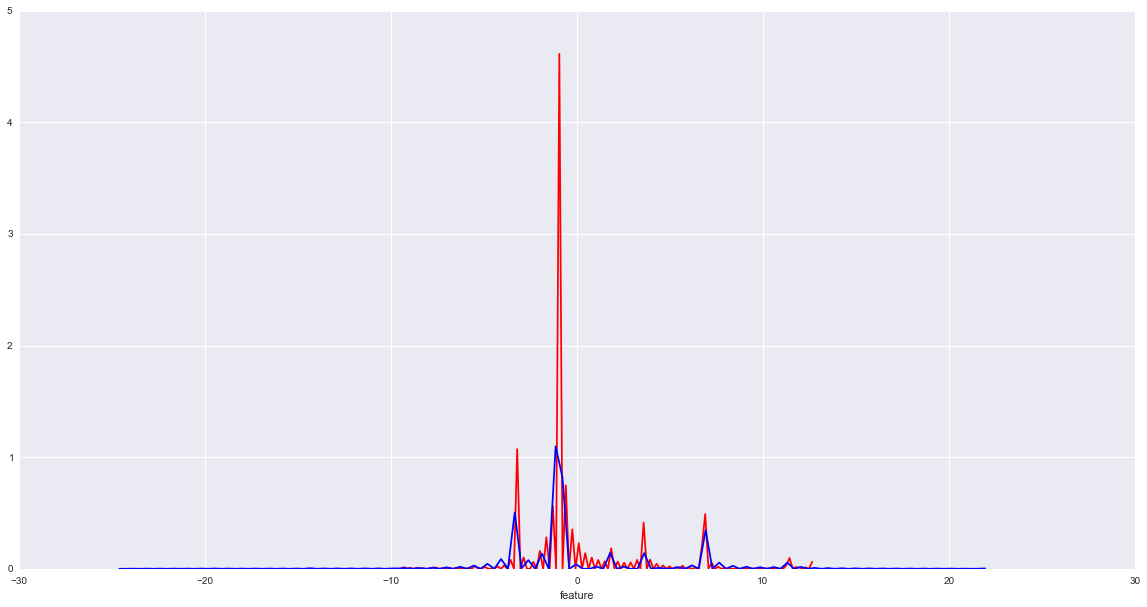

In [394]:
temp_df = pd.DataFrame(zip(scale(full_df[['CDR2_start', 'CDR3_start', 'CDR1_end', 'CDR2_end']]).sum(axis=1), 
 full_df.quality_imp.values), columns=['feature', 'class'])
plt.figure(figsize=(20,10))
sb.distplot(temp_df[temp_df['class']==1].feature, hist=False, color='r')
sb.distplot(temp_df[temp_df['class']==-1].feature, hist=False, color='b')

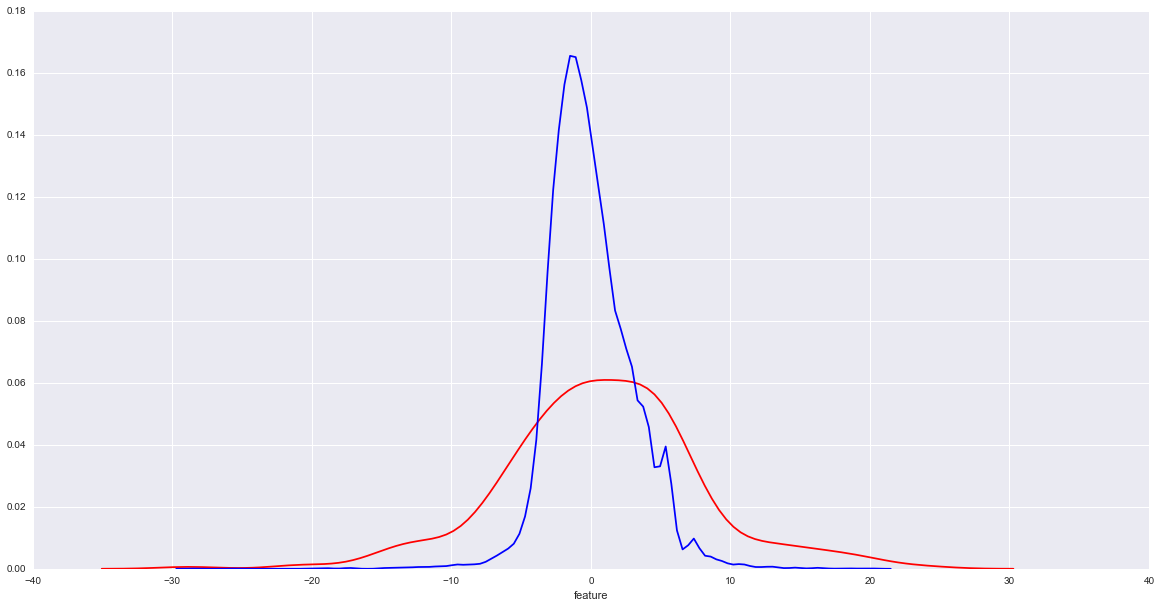

In [401]:
temp_df = pd.DataFrame(zip(scale(full_df[['value1', 'value2', 'value3']]).sum(axis=1) - scale(full_df['size']), 
 full_df.quality_imp.values), columns=['feature', 'class'])
plt.figure(figsize=(20,10))
sb.distplot(temp_df[temp_df['class']==1].feature, hist=False, color='r')
sb.distplot(temp_df[temp_df['class']==-1].feature, hist=False, color='b')

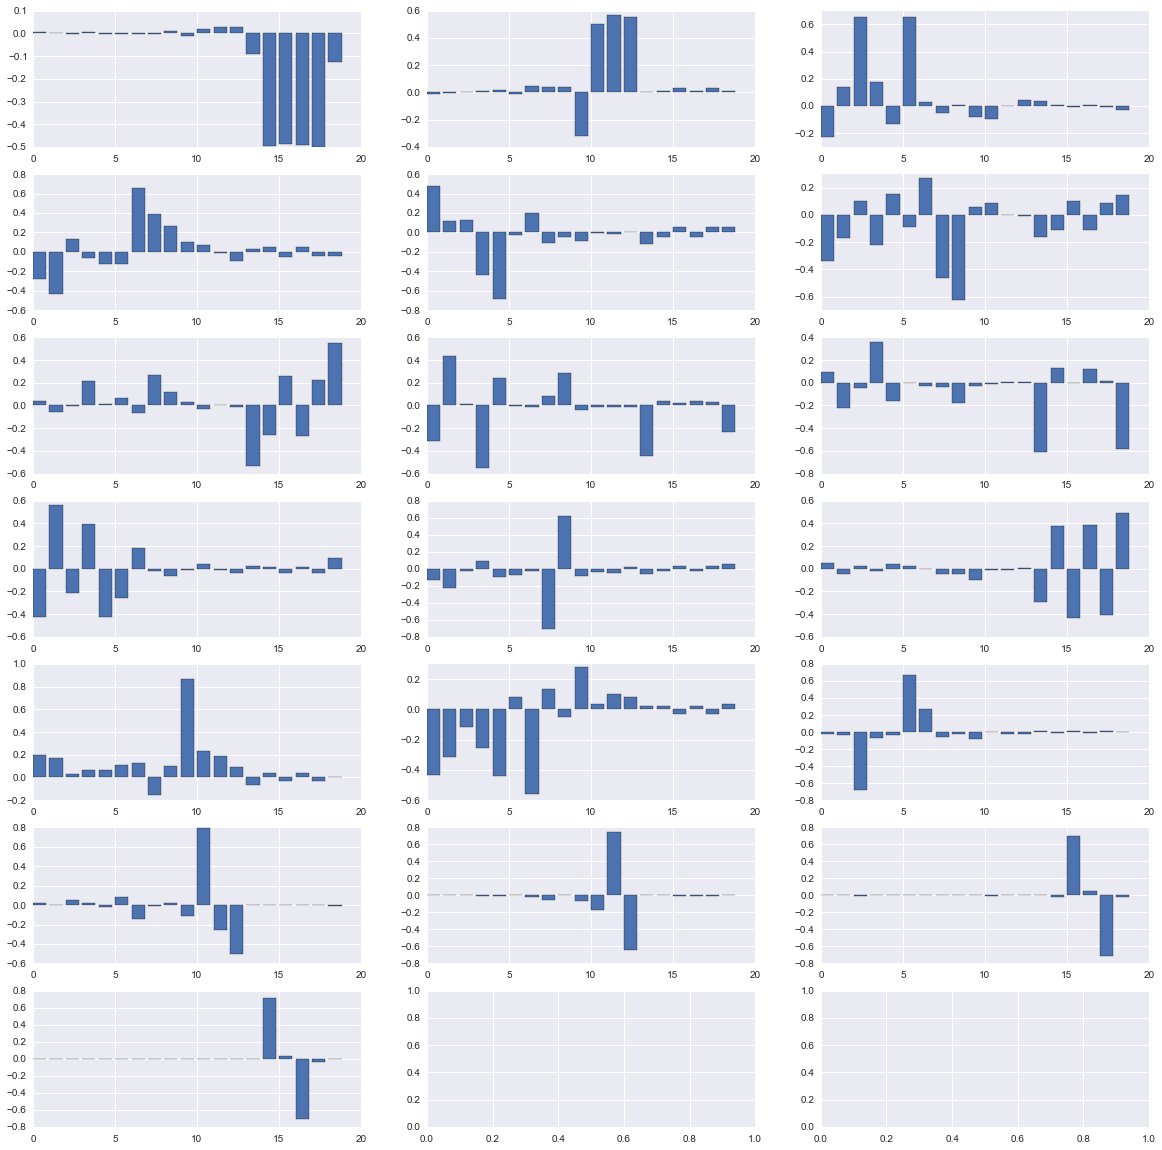

In [331]:
fig, axes = plt.subplots(ncols=3, nrows=7, figsize=(20, 20))
for i, vec in enumerate(np.identity(19)): 
    axes[i/3, i%3].bar(range(19),pca.inverse_transform(vec.T))

In [418]:
df = func_tools.build_df_test(igrec_clusters=clusters_filtering(final_clusters),
              igrec_rep=final_rep,
              igrec_res=final_res)

build_df started
calculation step
parsing step
context step
mutation step
building succeeded


In [431]:
df.index = df.index.map(int)

In [439]:
df = pd.concat([df, ans_df], axis=1)

/Users/Macbook/anaconda/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/Users/Macbook/anaconda/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


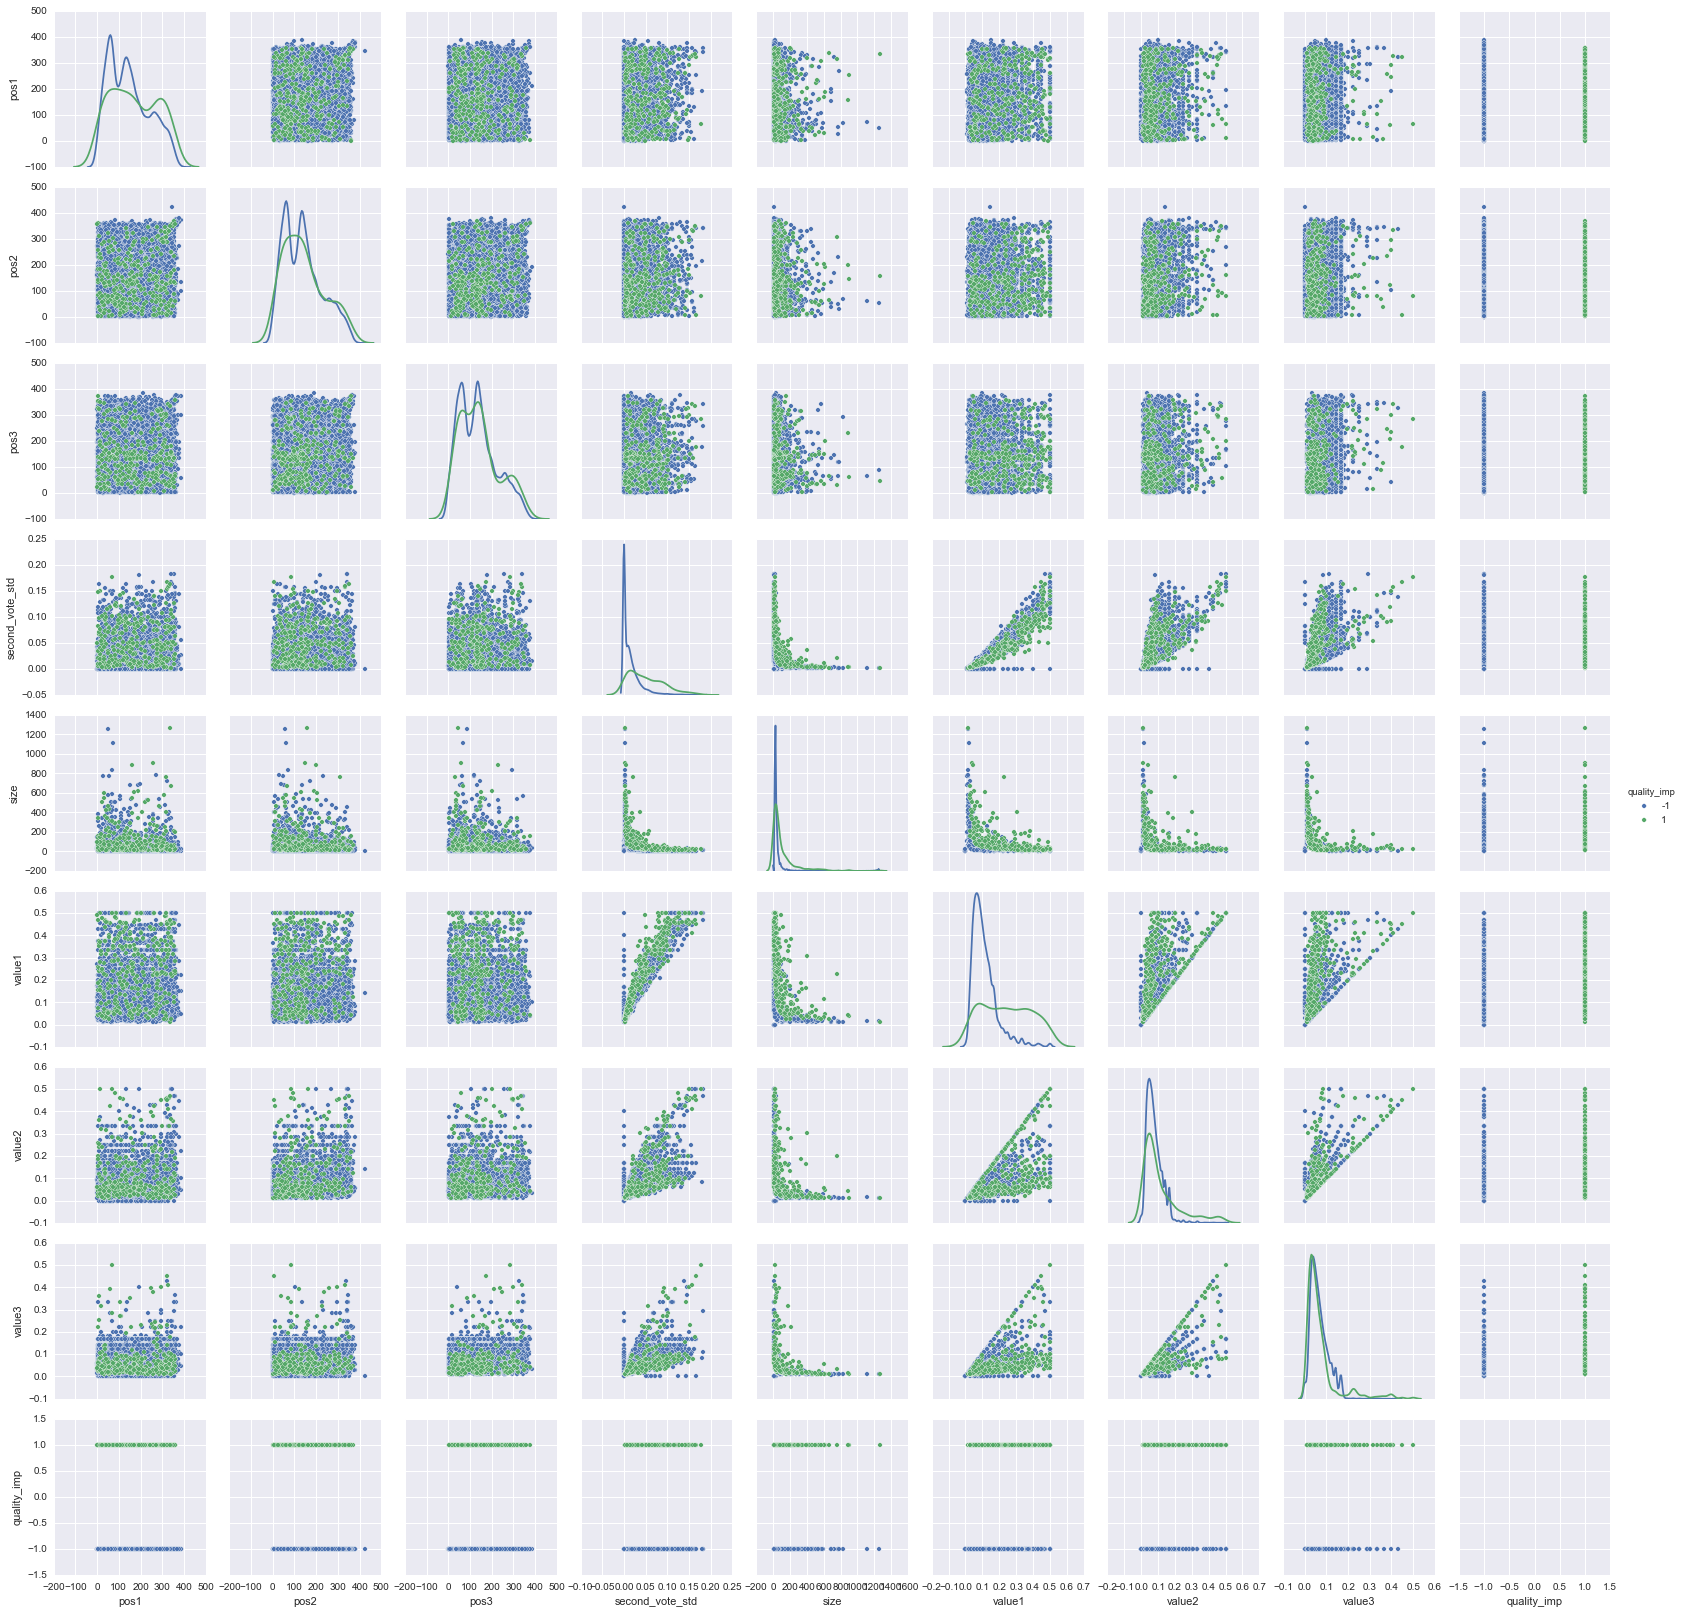

In [442]:
sb.pairplot(df.drop(list(df.columns[:6])+
             ['first_cluster', 'origin_cluster', 'second_cluster'], axis=1), 
            hue='quality_imp',
            diag_kind='kde')

In [24]:
ans_df = func_tools.build_ans_df(ans)

In [34]:
df = func_tools.build_df_preload(final_clusters, final_rep, final_res)

build_df started
calculation step


/Users/Macbook/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/Macbook/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/Macbook/anaconda/lib/python2.7/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


parsing step
context step
mutation step
building succeeded


In [42]:
final_df = pd.concat([df, cdr, ans_df], axis=1)
final_df = final_df.dropna()

In [44]:
final_df.to_csv('age3_df.csv')

In [645]:
pd.read_csv?

In [1217]:
df = pd.read_csv('data/age3/age3_df.csv', index_col='Unnamed: 0')

In [1218]:
df['bool_pos1'] = pd.Series([0 if np.isnan(pos) else 1 for pos in df.pos1], index=df.index)
df['bool_pos2'] = pd.Series([0 if np.isnan(pos) else 1 for pos in df.pos2], index=df.index)
df['bool_pos3'] = pd.Series([0 if np.isnan(pos) else 1 for pos in df.pos3], index=df.index)

df['pos1_ex'] = pd.Series([0 if np.isnan(bool_val*pos) else bool_val*pos for bool_val, 
                                  pos in df[['bool_pos1','pos1']].values], index=df.index)

df['pos2_ex'] = pd.Series([0 if np.isnan(bool_val*pos) else bool_val*pos for bool_val, 
                                  pos in df[['bool_pos1','pos2']].values], index=df.index)

df['pos3_ex'] = pd.Series([0 if np.isnan(bool_val*pos) else bool_val*pos for bool_val, 
                                  pos in df[['bool_pos1','pos3']].values], index=df.index)

df = df.drop(['pos1','pos2','pos3'], axis=1)

df.second_vote_std = df.second_vote_std.fillna(value=0)

df.dropna(inplace=True)

In [657]:
coder = LabelEncoder()
coder.fit(df['context1'])
df.context1 = coder.transform(df['context1'])
df.context2 = coder.transform(df['context2'])
df.context3 = coder.transform(df['context3'])
df.context4 = coder.transform(df['context4'])
df.context5 = coder.transform(df['context5'])
df.mutated_letter = coder.transform(df['mutated_letter'])

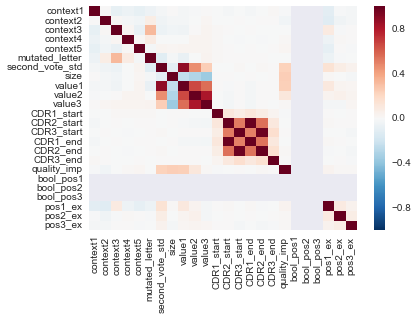

In [661]:
sb.heatmap(df.corr())

In [668]:
data = df.drop(['first_cluster','origin_cluster','quality_imp','second_cluster'], axis=1)

In [675]:
clf_l = LogisticRegression(penalty='l1')

clf = GridSearchCV(estimator=clf_l, param_grid={'C':np.linspace(1e-4,0.7,10)}, cv=3, scoring='accuracy')

X_train, X_test, y_train, y_test = train_test_split(data, df.quality_imp, test_size=0.2, 
                                                    train_size=0.8, stratify=df.quality_imp)

clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-04,   7.78667e-02,   1.55633e-01,   2.33400e-01,
         3.11167e-01,   3.88933e-01,   4.66700e-01,   5.44467e-01,
         6.22233e-01,   7.00000e-01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [678]:
clf.best_params_

{'C': 0.0001}

In [683]:
cls = LogisticRegression(C=0.48)

In [684]:
cls.fit(X_train, y_train)

LogisticRegression(C=0.48, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

([<matplotlib.axis.XTick at 0x10e40ba10>,
 <a list of 23 Text xticklabel objects>)

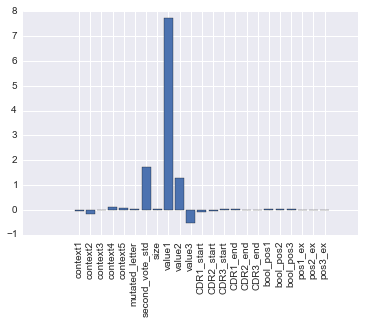

In [685]:
plt.bar(range(23), list(cls.coef_[0]), align='center')
plt.xticks(range(23), data.columns, rotation=90)

([<matplotlib.axis.XTick at 0x113118bd0>,
 <a list of 23 Text xticklabel objects>)

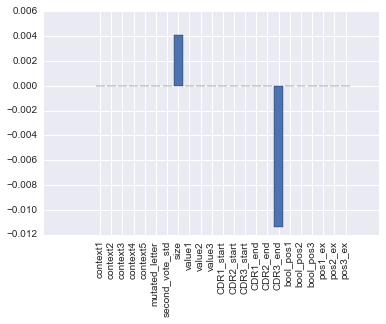

In [677]:
plt.bar(range(23), list(clf.best_estimator_.coef_[0]), align='center')
plt.xticks(range(23), data.columns, rotation=90)

In [679]:
cls_l = sm.OLS(df.quality_imp, data)

In [680]:
result = cls_l.fit_regularized()

In [681]:
result.summary()

/Users/Macbook/anaconda/lib/python2.7/site-packages/statsmodels/regression/linear_model.py:1263: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/Macbook/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:978: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse
/Users/Macbook/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            quality_imp   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     157.5
Date:                Fri, 21 Jul 2017   Prob (F-statistic):               0.00
Time:                        04:36:42   Log-Likelihood:                -1302.4
No. Observations:               14198   AIC:                             2647.
Df Residuals:                   14177   BIC:                             2806.
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
context1            0.0005      0.002      0.234      0.815        -0.004     0.005
context2           -0.0050      0.002     -2.286      0.022        -0.009    -0.001
context3            0.0043      0.003      1.700      0.089        -0.001     0.009
context4            0.0043      0.002      1.994      0.046      7.37e-05     0.009
context5            0.0015      0.002      0.713      0.476        -0.003     0.006
mutated_letter      0.0043      0.002      2.265      0.024         0.001     0.008
second_vote_std    -4.8561      0.285    -17.050      0.000        -5.414    -4.298
size                0.0019   4.84e-05     39.082      0.000         0.002     0.002
value1              2.6404      0.092     28.776      0.000         2.461     2.820
value2              0.9675      0.089     10.872      0.000         0.793     1.142
value3             -2.2623      0.120    -18.787      0.000        -2.498    -2.026
CDR1_start         -0.0157      0.009     -1.769      0.077        -0.033     0.002
CDR2_start       5.058e-05      0.008      0.006      0.995        -0.015     0.015
CDR3_start        6.87e-05      0.004      0.016      0.988        -0.009     0.009
CDR1_end           -0.0001      0.008     -0.014      0.989        -0.015     0.015
CDR2_end            0.0002      0.005      0.036      0.972        -0.009     0.010
CDR3_end        -7.827e-05      0.000     -0.432      0.666        -0.000     0.000
bool_pos1          -0.0203      0.927     -0.022      0.983        -1.837     1.796
bool_pos2               -0          0        nan        nan            -0         0
bool_pos3               -0          0        nan        nan            -0         0
pos1_ex          3.135e-06   2.48e-05      0.126      0.899     -4.55e-05  5.18e-05
pos2_ex         -4.161e-06   2.56e-05     -0.162      0.871     -5.44e-05   4.6e-05
pos3_ex          8.446e-05   2.59e-05      3.262      0.001      3.37e-05     0.000
==============================================================================
Omnibus:                    14138.442   Durbin-Watson:                   1.956
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           694825.126
Skew:                           5.007   Prob(JB):                         0.00
Kurtosis:                      35.775   Cond. No.                          nan
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is -4.99e-15. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [1219]:
df = pd.concat([pd.get_dummies(df[df.columns[:6]]), df[df.columns[6:]]], axis=1) 

In [817]:
data = df.drop(['first_cluster','origin_cluster','quality_imp','second_cluster'], axis=1)

In [750]:
y = df.quality_imp.map(lambda x: 0 if x<0 else 1)
X = data.astype('float')
cls = sm.OLS(y, X)

In [751]:
result = cls.fit_regularized()

In [752]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            quality_imp   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     98.88
Date:                Fri, 21 Jul 2017   Prob (F-statistic):               0.00
Time:                        15:13:06   Log-Likelihood:                 8626.6
No. Observations:               14198   AIC:                        -1.718e+04
Df Residuals:                   14163   BIC:                        -1.692e+04
Df Model:                          34                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
context1_            0.1158      0.066      1.768      0.077        -0.013     0.244
context1_A           0.0134      0.041      0.330      0.742        -0.066     0.093
context1_C           0.0084      0.041      0.206      0.837        -0.071     0.088
context1_G           0.0077      0.041      0.190      0.849        -0.072     0.087
context1_T           0.0151      0.041      0.371      0.711        -0.065     0.095
context2_           -0.2335      0.085     -2.750      0.006        -0.400    -0.067
context2_A           0.0074      0.042      0.174      0.862        -0.076     0.091
context2_C          -0.0049      0.042     -0.116      0.908        -0.088     0.078
context2_G          -0.0017      0.042     -0.041      0.967        -0.085     0.081
context2_T           0.0018      0.042      0.044      0.965        -0.081     0.085
context3_A          -0.0080      0.048     -0.166      0.868        -0.102     0.086
context3_C          -0.0048      0.048     -0.100      0.921        -0.099     0.090
context3_G           0.0107      0.048      0.222      0.824        -0.084     0.105
context3_T          -0.0027      0.048     -0.056      0.955        -0.097     0.092
context4_A          -0.0006      0.048     -0.012      0.990        -0.095     0.094
context4_C           0.0006      0.048      0.012      0.990        -0.094     0.095
context4_G          -0.0073      0.048     -0.151      0.880        -0.102     0.087
context4_T           0.0121      0.048      0.252      0.801        -0.082     0.106
context5_A          -0.0004      0.048     -0.009      0.993        -0.095     0.094
context5_C          -0.0006      0.048     -0.013      0.989        -0.095     0.094
context5_G          -0.0014      0.048     -0.030      0.976        -0.096     0.093
context5_T           0.0037      0.048      0.077      0.938        -0.091     0.098
mutated_letter_A    -0.0107      0.048     -0.222      0.824        -0.105     0.084
mutated_letter_C     0.0315      0.048      0.654      0.513        -0.063     0.126
mutated_letter_G     0.0177      0.048      0.367      0.714        -0.077     0.112
mutated_letter_T    -0.0112      0.048     -0.232      0.816        -0.106     0.083
second_vote_std     -2.3588      0.142    -16.601      0.000        -2.637    -2.080
size                 0.0009   2.41e-05     39.171      0.000         0.001     0.001
value1               1.3119      0.046     28.686      0.000         1.222     1.402
value2               0.4755      0.044     10.726      0.000         0.389     0.562
value3              -1.1397      0.060    -19.005      0.000        -1.257    -1.022
CDR1_start          -0.0014      0.004     -0.316      0.752        -0.010     0.007
CDR2_start         3.86e-05      0.004      0.010      0.992        -0.008     0.008
CDR3_start         3.57

# FLU DATASET

In [ ]:
df_flu = func_tools.build_df(input_reads='/Users/Macbook/GitHub/ig_cluster_splitter/data/flu/input_reads.fa',
                    fa_reference='/Users/Macbook/GitHub/ig_cluster_splitter/data/flu/repertoire.fa',
                    rcm_file='/Users/Macbook/GitHub/ig_cluster_splitter/data/flu/final_repertoire.rcm',
                    cdr_file='/Users/Macbook/GitHub/ig_cluster_splitter/data/flu/cdr/cdr_details.txt')

In [ ]:
df_flu.to_csv('flu_df.csv')

In [29]:
input_reads='/Users/Macbook/GitHub/ig_cluster_splitter/data/flu/input_reads.fa'
fa_reference='/Users/Macbook/GitHub/ig_cluster_splitter/data/flu/repertoire.fa'
rcm_file='/Users/Macbook/GitHub/ig_cluster_splitter/data/flu/final_repertoire.rcm'
cdr_file='/Users/Macbook/GitHub/ig_cluster_splitter/data/flu/cdr/cdr_details.txt'

In [36]:
id_dict = func_tools.id_to_read(input_reads)

In [37]:
rep = func_tools.read_repertoire(fa_reference)

In [38]:
igrec_rcm = func_tools.read_rcm(rcm_file)

In [39]:
igrec_clusters = func_tools.construct_clusters(igrec_rcm, id_dict)

In [40]:
igrec_rep = func_tools.clusters2rep(igrec_clusters)

In [41]:
igrec_res = func_tools.second_votes(func_tools.clusters_filtering(igrec_clusters, threshold=0))

In [49]:
print 'id_dict:', len(id_dict)
print 'rep', len(rep)
print 'igrec_rcm', len(igrec_rcm)
print 'igrec_clusters', len(igrec_clusters)
print 'igrec_rep', len(igrec_rep)
print 'igrec_res', len(igrec_res)

id_dict: 324881
rep 45557
igrec_rcm 324881
igrec_clusters 41239
igrec_rep 41239
igrec_res 41239


In [85]:
with open('data/flu/final_clusters.pkl', 'wb') as output:
    pickle.dump(dict(clusters_filtering(igrec_clusters)), output, pickle.HIGHEST_PROTOCOL)

with open('data/flu/final_rep.pkl', 'wb') as output:
    pickle.dump(dict(igrec_rep), output, pickle.HIGHEST_PROTOCOL)

with open('data/flu/final_res.pkl', 'wb') as output:
    pickle.dump({k:dict(v) for k,v in igrec_res.items()}, output, pickle.HIGHEST_PROTOCOL)

In [207]:
from func_tools import * 
print 'calculation step'

max_final_second_vote = n_second_vote(igrec_res)
max_2nd_final_second_vote = n_second_vote(igrec_res, n=1)
max_3nd_final_second_vote = n_second_vote(igrec_res, n=2)
sizes = clusters_size_dict(igrec_clusters)
context = find_context(clusters_filtering(igrec_rep), max_final_second_vote)

second_vote_std = {}
for key in igrec_res:
    second_vote_std[int(key)] = np.std(igrec_res[key].values())

print 'parsing step'

pos1 = {int(k): v[0] for k, v in max_final_second_vote.items()}
value1 = {int(k): v[1] for k, v in max_final_second_vote.items()}
pos2 = {int(k): v[0] for k, v in max_2nd_final_second_vote.items()}
value2 = {int(k): v[1] for k, v in max_2nd_final_second_vote.items()}
pos3 = {int(k): v[0] for k, v in max_3nd_final_second_vote.items()}
value3 = {int(k): v[1] for k, v in max_3nd_final_second_vote.items()}
sizes = {int(k):v for k,v in sizes.items()}

print 'context step'

context1 = {}
context2 = {}
context3 = {}
context4 = {}
context5 = {}

for key in context:
    temp_arr = list(context[key])
    context1[int(key)] = temp_arr[0]
    context2[int(key)] = temp_arr[1]
    context3[int(key)] = temp_arr[2]
    context4[int(key)] = temp_arr[3]
    context5[int(key)] = temp_arr[4]

print 'mutation step'

mutated_letter = {}
for key in igrec_res:
    mutated_letter[int(key)] = second_vote_letter(igrec_clusters[key], max_final_second_vote[key][0])

print len(set.intersection(set(pos1.keys()),
set(value1.keys()),
set(pos2.keys()),
set(value2.keys()),
set(pos3.keys()),
set(value3.keys()),
set(context1.keys()),
set(context2.keys()), 
set(context3.keys()),
set(context4.keys()),
set(context5.keys()),
set(second_vote_std.keys()),
set(cdr.index),
set(ans_df.index),
set(sizes.keys()), 
set(mutated_letter.keys())))
    
df = pd.DataFrame({'pos1': pos1, 'value1': value1,
                   'pos2': pos2, 'value2': value2,
                   'pos3': pos3, 'value3': value3,
                   'context1': context1,
                   'context2': context2,
                   'context3': context3,
                   'context4': context4,
                   'context5': context5,
                   'mutated_letter': mutated_letter,
                   'size': sizes,
                   'second_vote_std': second_vote_std})

calculation step
parsing step
context step
mutation step
36805


In [50]:
cdr_df = pd.read_csv(cdr_file, delimiter='\t')
cdr = cdr_df[['CDR1_start', 'CDR2_start', 'CDR3_start', 'CDR1_end', 'CDR2_end', 'CDR3_end']]
new_df = pd.concat([df, cdr], axis=1)

print 'answers DataFrame'

ans_dict = simple_clusters_classification(igrec_clusters, rep)
ans_df = build_ans_df(ans_dict)

final_df = pd.concat([new_df, ans_df], axis=1)

print 'building succeeded'


answers DataFrame
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18

In [ ]:
final_d = pd.concat([df, cdr, ans_df], axis=1)

In [242]:
final_df.to_csv('data/flu/flu_df.csv')

In [244]:
final_df.isnull().sum()[final_df.isnull().sum() > 0] 

pos1               26229
pos2               28639
pos3               30571
second_vote_std    26229
CDR1_start          4434
CDR2_start          4434
CDR3_start          4434
CDR1_end            4434
CDR2_end            4434
CDR3_end            4434
dtype: int64

In [1221]:
df.columns

Index([u'context1_ ', u'context1_A', u'context1_C', u'context1_G',
       u'context1_T', u'context2_ ', u'context2_A', u'context2_C',
       u'context2_G', u'context2_T', u'context3_A', u'context3_C',
       u'context3_G', u'context3_T', u'context4_A', u'context4_C',
       u'context4_G', u'context4_T', u'context5_A', u'context5_C',
       u'context5_G', u'context5_T', u'mutated_letter_A', u'mutated_letter_C',
       u'mutated_letter_G', u'mutated_letter_T', u'second_vote_std', u'size',
       u'value1', u'value2', u'value3', u'CDR1_start', u'CDR2_start',
       u'CDR3_start', u'CDR1_end', u'CDR2_end', u'CDR3_end', u'first_cluster',
       u'origin_cluster', u'quality_imp', u'second_cluster', u'pos1_in_CDR1',
       u'pos2_in_CDR1', u'pos3_in_CDR1', u'pos1_in_CDR2', u'pos2_in_CDR2',
       u'pos3_in_CDR2', u'pos1_in_CDR3', u'pos2_in_CDR3', u'pos3_in_CDR3',
       u'bool_pos1', u'bool_pos2', u'bool_pos3', u'pos1_ex', u'pos2_ex',
       u'pos3_ex'],
      dtype='object')

In [1244]:
temp_df = flu_df

In [1245]:
temp_df['bool_pos1'] = pd.Series([0 if np.isnan(pos) else 1 for pos in temp_df.pos1], index=temp_df.index)
temp_df['bool_pos2'] = pd.Series([0 if np.isnan(pos) else 1 for pos in temp_df.pos2], index=temp_df.index)
temp_df['bool_pos3'] = pd.Series([0 if np.isnan(pos) else 1 for pos in temp_df.pos3], index=temp_df.index)

temp_df['pos1_ex'] = pd.Series([0 if np.isnan(bool_val*pos) else bool_val*pos for bool_val, 
                                  pos in temp_df[['bool_pos1','pos1']].values], index=temp_df.index)

temp_df['pos2_ex'] = pd.Series([0 if np.isnan(bool_val*pos) else bool_val*pos for bool_val, 
                                  pos in temp_df[['bool_pos1','pos2']].values], index=temp_df.index)

temp_df['pos3_ex'] = pd.Series([0 if np.isnan(bool_val*pos) else bool_val*pos for bool_val, 
                                  pos in temp_df[['bool_pos1','pos3']].values], index=temp_df.index)

temp_df = temp_df.drop(['pos1','pos2','pos3'], axis=1)

temp_df.second_vote_std = final_df.second_vote_std.fillna(value=0)

temp_df.dropna(inplace=True)

In [313]:
coder = LabelEncoder()
coder.fit(temp_df['context1'])
temp_df.context1 = coder.transform(temp_df['context1'])
temp_df.context2 = coder.transform(temp_df['context2'])
temp_df.context3 = coder.transform(temp_df['context3'])
temp_df.context4 = coder.transform(temp_df['context4'])
temp_df.context5 = coder.transform(temp_df['context5'])
temp_df.mutated_letter = coder.transform(temp_df['mutated_letter'])

In [314]:
temp_df.head()

context1  context2  context3  context4  context5  mutated_letter  \
0         1         2         4         4         3               1   
1         2         2         3         2         4               2   
2         2         1         4         4         3               2   
3         2         2         4         2         3               2   
4         4         4         4         4         3               1   

   second_vote_std  size    value1    value2   ...     first_cluster  \
0         0.013442   152  0.085526  0.046053   ...                 +   
1         0.049027   103  0.330097  0.077670   ...                 +   
2         0.152753     9  0.444444  0.444444   ...                 +   
3         0.070073    44  0.250000  0.181818   ...                 +   
4         0.070784    50  0.240000  0.240000   ...                 +   

   origin_cluster quality_imp  second_cluster  bool_pos1 bool_pos2  bool_pos3  \
0               +           1               +          1         1          1   
1               +           1               +          1         1          1   
2               +          -1               ?          1         1          1   
3               +           1               +          1         1          1   
4               +           1               +          1         1          1   

  pos1_ex pos2_ex  pos3_ex  
0   293.0    64.0     52.0  
1   281.0   151.0    166.0  
2   292.0   293.0    294.0  
3   281.0   282.0    285.0  
4   100.0    20.0    291.0  

[5 rows x 27 columns]

In [315]:
data = temp_df.drop(['first_cluster','origin_cluster','quality_imp','second_cluster'], axis=1)

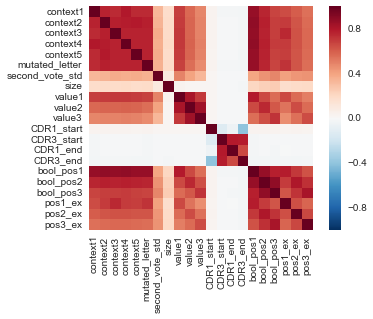

In [322]:
sb.heatmap(data.corr(), square=True)

/Users/Macbook/anaconda/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/Macbook/anaconda/lib/python2.7/site-packages/statsmodels/nonparametric/kdetools.py:32: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


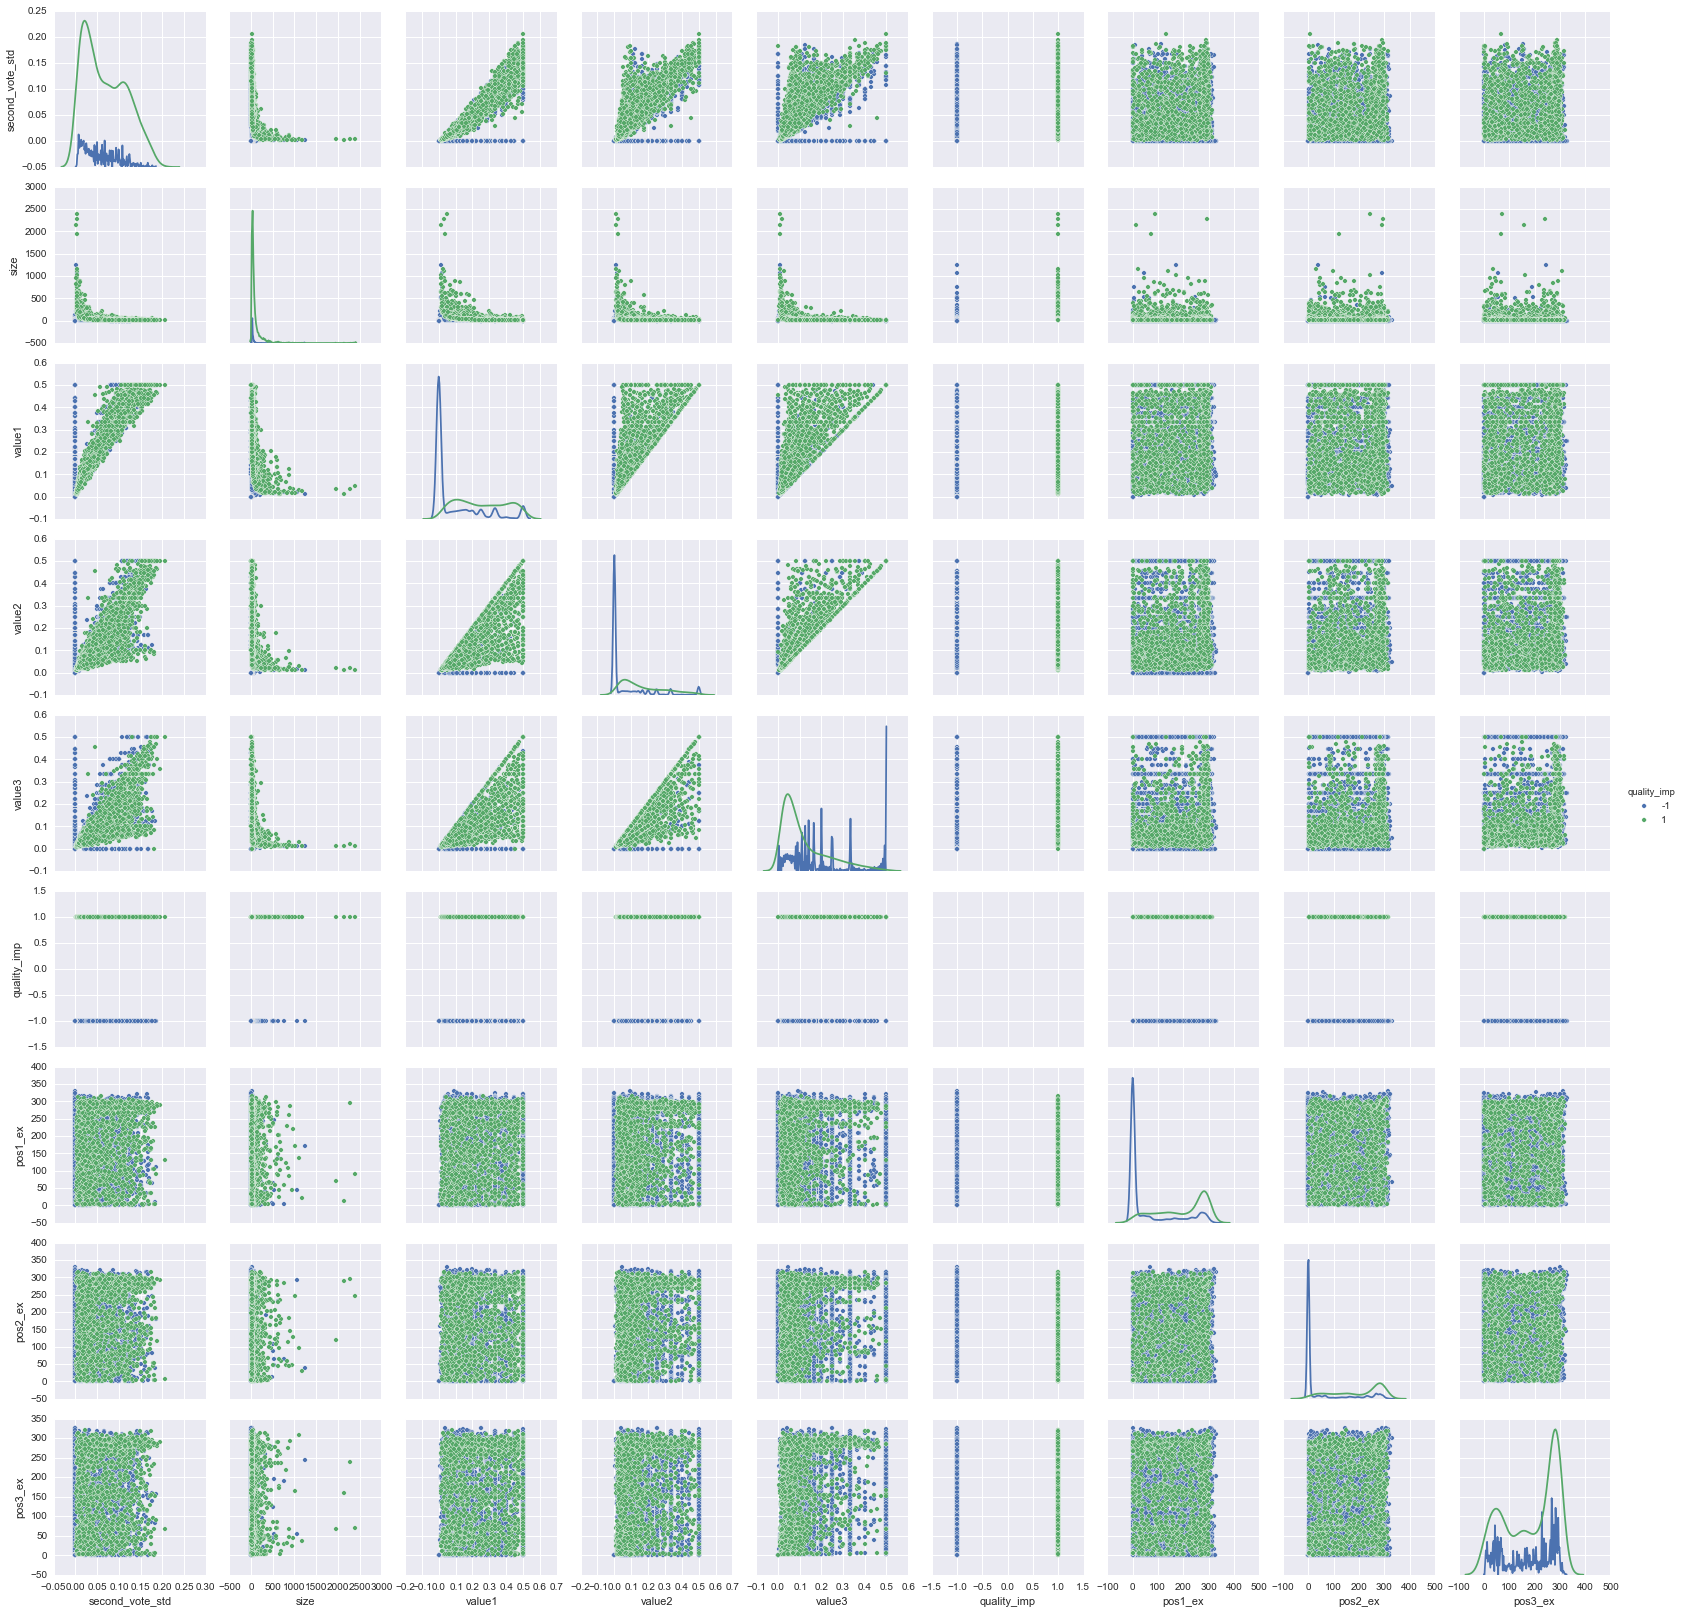

In [321]:
sb.pairplot(temp_df.drop(list(temp_df.columns[:6])+
             ['first_cluster', 'origin_cluster', 'second_cluster']+
             ['CDR1_start', 'CDR2_start', 'CDR3_start']+
             ['CDR1_end', 'CDR2_end', 'CDR3_end']+
             ['bool_pos1', 'bool_pos2', 'bool_pos3'], axis=1), 
            hue='quality_imp',
            diag_kind='kde')

In [326]:
pca = PCA(n_components=23)

In [355]:
data = data[data.CDR2_start != '-']
temp_df = temp_df[temp_df.CDR2_start != '-']

In [343]:
pca_representation = pca.fit_transform(scale(data))

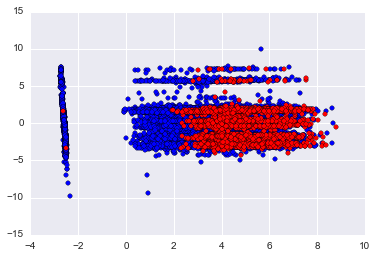

In [344]:
dots = np.array(zip(pca_representation, list(temp_df.quality_imp)))
fig = plt.figure()
plt.scatter([x[0] for x in dots[dots[:, 1]==-1][:, 0]], [x[1] for x in dots[dots[:, 1]==-1][:, 0]], c='b')
plt.scatter([x[0] for x in dots[dots[:, 1]==1][:, 0]], [x[1] for x in dots[dots[:, 1]==1][:, 0]], c='r')

<Container object of 23 artists>

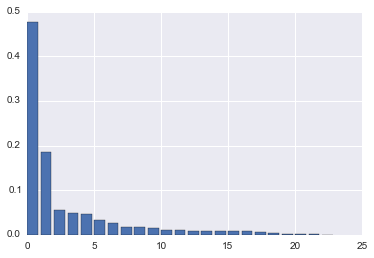

In [346]:
plt.bar(range(23), pca.explained_variance_ratio_)

In [350]:
data.columns[11:17]

Index([u'CDR1_start', u'CDR2_start', u'CDR3_start', u'CDR1_end', u'CDR2_end',
       u'CDR3_end'],
      dtype='object')

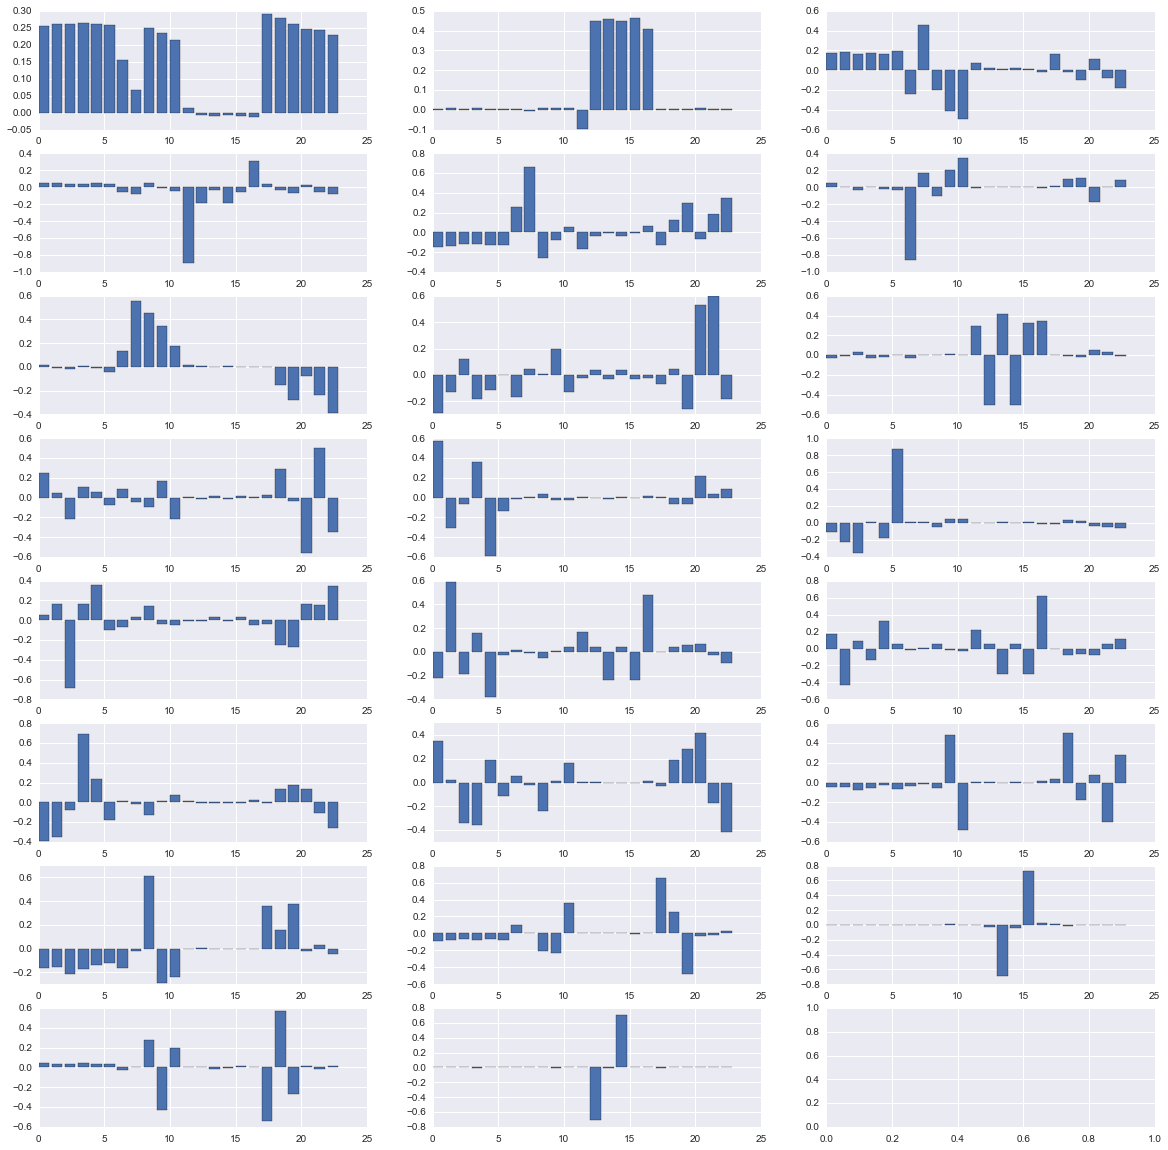

In [348]:
fig, axes = plt.subplots(ncols=3, nrows=8, figsize=(20, 20))
for i, vec in enumerate(np.identity(23)): 
    axes[i/3, i%3].bar(range(23),pca.inverse_transform(vec.T))

In [416]:
clf_l = LogisticRegression(penalty='l1')

clf = GridSearchCV(estimator=clf_l, param_grid={'C':np.linspace(1e-10,0.7,10)}, cv=3, scoring='accuracy')

X_train, X_test, y_train, y_test = train_test_split(data, temp_df.quality_imp, test_size=0.2, 
                                                    train_size=0.8, stratify=temp_df.quality_imp)

clf.fit(X_train, y_train)

In [1108]:
ch_features

['pos1_ex', 'value3', 'value1', 'pos3_ex', 'second_vote_std', 'size']

In [425]:
clf.best_estimator_.coef_

array([[  3.21880454e-02,   8.80520665e-02,   3.77815973e-02,
          0.00000000e+00,   3.16330914e-02,  -2.21063778e-02,
          3.58629155e+01,   4.74451147e-02,   1.77408952e+00,
         -2.00015789e+00,  -4.40478472e+00,  -2.27390366e-02,
         -1.69858441e-02,  -1.12410778e-02,   3.32536811e-02,
         -6.78686288e-03,  -1.65312393e-02,   0.00000000e+00,
          0.00000000e+00,   4.67804851e+00,   1.36153506e-03,
          1.60428306e-03,   1.35133861e-03]])

([<matplotlib.axis.XTick at 0x1159d3c50>,
 <a list of 23 Text xticklabel objects>)

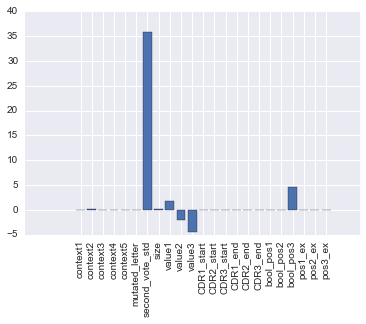

In [426]:
plt.bar(range(23), list(clf.best_estimator_.coef_[0]), align='center')
plt.xticks(range(23), data.columns, rotation=90)

In [609]:
X_train.CDR2_start = X_train.CDR2_start.map(int)

/Users/Macbook/anaconda/lib/python2.7/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [718]:
y = y_train.map(lambda x: 0 if x<0 else 1)
X = X_train.astype('float')
cls = sm.OLS(y, X)

In [719]:
result = cls.fit_regularized()

In [720]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            quality_imp   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     122.4
Date:                Fri, 21 Jul 2017   Prob (F-statistic):               0.00
Time:                        14:51:42   Log-Likelihood:                 6792.9
No. Observations:               11358   AIC:                        -1.354e+04
Df Residuals:                   11337   BIC:                        -1.339e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
context1            0.0005      0.001      0.383      0.702        -0.002     0.003
context2           -0.0027      0.001     -2.247      0.025        -0.005    -0.000
context3            0.0013      0.001      0.885      0.376        -0.002     0.004
context4            0.0028      0.001      2.334      0.020         0.000     0.005
context5            0.0006      0.001      0.492      0.623        -0.002     0.003
mutated_letter      0.0024      0.001      2.263      0.024         0.000     0.004
second_vote_std    -2.4815      0.159    -15.593      0.000        -2.793    -2.170
size                0.0009   2.86e-05     32.444      0.000         0.001     0.001
value1              1.3719      0.051     26.852      0.000         1.272     1.472
value2              0.4380      0.050      8.735      0.000         0.340     0.536
value3             -1.1536      0.068    -17.081      0.000        -1.286    -1.021
CDR1_start         -0.0014      0.005     -0.264      0.792        -0.012     0.009
CDR2_start       9.157e-06      0.004      0.002      0.998        -0.009     0.009
CDR3_start       2.508e-05      0.002      0.010      0.992        -0.005     0.005
CDR1_end        -6.755e-05      0.004     -0.015      0.988        -0.009     0.009
CDR2_end         5.567e-05      0.003      0.021      0.983        -0.005     0.005
CDR3_end         1.333e-05      0.000      0.132      0.895        -0.000     0.000
bool_pos1          -0.0102      0.526     -0.019      0.985        -1.042     1.021
bool_pos2               -0          0        nan        nan            -0         0
bool_pos3                0          0        nan        nan             0         0
pos1_ex          5.587e-06   1.39e-05      0.402      0.687     -2.16e-05  3.28e-05
pos2_ex         -7.906e-07   1.43e-05     -0.055      0.956     -2.89e-05  2.73e-05
pos3_ex          4.414e-05   1.45e-05      3.039      0.002      1.57e-05  7.26e-05
==============================================================================
Omnibus:                    11232.333   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           539386.890
Skew:                           4.952   Prob(JB):                         0.00
Kurtosis:                      35.275   Cond. No.                          nan
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is -1.86e-14. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [1247]:
temp_df = pd.concat([pd.get_dummies(temp_df[temp_df.columns[:6]]), temp_df[temp_df.columns[6:]]], axis=1) 

In [717]:
data = temp_df.drop(['first_cluster','origin_cluster','quality_imp','second_cluster'], axis=1)

In [726]:
y = temp_df[temp_df.CDR2_start != '-'].quality_imp.map(lambda x: 0 if x<0 else 1)
X = data[data.CDR2_start != '-'].astype('float')
cls = sm.OLS(y, X)

In [727]:
result = cls.fit_regularized()

In [728]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            quality_imp   R-squared:                       0.405
Model:                            OLS   Adj. R-squared:                  0.405
Method:                 Least Squares   F-statistic:                     677.4
Date:                Fri, 21 Jul 2017   Prob (F-statistic):               0.00
Time:                        15:01:24   Log-Likelihood:                 13597.
No. Observations:               36804   AIC:                        -2.712e+04
Df Residuals:                   36766   BIC:                        -2.679e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
context1_            0.0457      0.115      0.398      0.691        -0.180     0.271
context1_A           0.0348      0.038      0.927      0.354        -0.039     0.108
context1_C           0.0535      0.038      1.425      0.154        -0.020     0.127
context1_G           0.0410      0.038      1.092      0.275        -0.033     0.115
context1_T           0.0473      0.038      1.260      0.208        -0.026     0.121
context2_                -0          0        nan        nan            -0         0
context2_A           0.0022      0.038      0.059      0.953        -0.071     0.076
context2_C          -0.0026      0.038     -0.069      0.945        -0.076     0.071
context2_G          -0.0061      0.038     -0.162      0.871        -0.080     0.067
context2_T           0.0134      0.038      0.356      0.722        -0.060     0.087
context3_            0.0082      0.083      0.099      0.921        -0.155     0.172
context3_A          -0.0257      0.020     -1.290      0.197        -0.065     0.013
context3_C          -0.0074      0.020     -0.369      0.712        -0.046     0.032
context3_G           0.0066      0.020      0.328      0.743        -0.033     0.046
context3_T          -0.0200      0.020     -1.004      0.315        -0.059     0.019
context4_                 0          0        nan        nan             0         0
context4_A          -0.0121      0.020     -0.610      0.542        -0.051     0.027
context4_C           0.0050      0.020      0.251      0.802        -0.034     0.044
context4_G          -0.0009      0.020     -0.043      0.966        -0.040     0.038
context4_T           0.0038      0.020      0.192      0.848        -0.035     0.043
context5_           -0.0294      0.059     -0.502      0.615        -0.144     0.085
context5_A           0.0399      0.031      1.292      0.196        -0.021     0.100
context5_C           0.0397      0.031      1.289      0.197        -0.021     0.100
context5_G           0.0392      0.031      1.270      0.204        -0.021     0.100
context5_T           0.0556      0.031      1.803      0.071        -0.005     0.116
mutated_letter_      0.0294      0.083      0.353      0.724        -0.134     0.193
mutated_letter_A    -0.0420      0.020     -2.105      0.035        -0.081    -0.003
mutated_letter_C    -0.0290      0.020     -1.454      0.146        -0.068     0.010
mutated_letter_G    -0.0581      0.020     -2.910      0.004        -0.097    -0.019
mutated_letter_T    -0.0502      0.020     -2.516      0.012        -0.089    -0.011
second_vote_std      3.3577      0.048     70.308      0.000         3.264     3.451
size                 0.0017   2.27e-05     73.463      0.000         0.002     0.002
value1               0.1213      0.021      5.902      0.000         0.081     0.162
value2               0.

## Оценки качества, если обучаться на на флю и на смешанном датасете

In [977]:
clf_l = LogisticRegression(penalty='l1')

clf = GridSearchCV(estimator=clf_l, param_grid={'C':np.linspace(1e-4,0.7,10)}, cv=3, scoring='roc_auc')

X_train, X_test, y_train, y_test = train_test_split(scaled_flu_df.drop(['first_cluster','origin_cluster',
                                                                  'quality_imp','second_cluster'], axis=1), 
                                                    scaled_flu_df.quality_imp, test_size=0.2, 
                                                    train_size=0.8, stratify=scaled_flu_df.quality_imp)

clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-04,   7.78667e-02,   1.55633e-01,   2.33400e-01,
         3.11167e-01,   3.88933e-01,   4.66700e-01,   5.44467e-01,
         6.22233e-01,   7.00000e-01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [978]:
roc_auc_score(y_test, clf.best_estimator_.predict(X_test))

0.78021192756079139

In [979]:
roc_auc_score(scaled_age3_df.quality_imp, 
              clf.best_estimator_.predict(scaled_age3_df.drop(['first_cluster','origin_cluster',
                                                                'quality_imp','second_cluster'], axis=1)))

0.63605753073562377

In [973]:
clf_l = LogisticRegression(penalty='l1')

clf = GridSearchCV(estimator=clf_l, param_grid={'C':np.linspace(1e-4,0.7,10)}, cv=3, scoring='roc_auc')

X_train, X_test, y_train, y_test = train_test_split(scaled_mix_df.drop(['first_cluster','origin_cluster',
                                                                  'quality_imp','second_cluster'], axis=1), 
                                                    scaled_mix_df.quality_imp, test_size=0.2, 
                                                    train_size=0.8, stratify=scaled_mix_df.quality_imp)

clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-04,   7.78667e-02,   1.55633e-01,   2.33400e-01,
         3.11167e-01,   3.88933e-01,   4.66700e-01,   5.44467e-01,
         6.22233e-01,   7.00000e-01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [974]:
roc_auc_score(y_test, clf.best_estimator_.predict(X_test))

0.69451033641324378

In [975]:
roc_auc_score(scaled_age3_df.quality_imp, 
              clf.best_estimator_.predict(scaled_age3_df.drop(['first_cluster','origin_cluster',
                                                                'quality_imp','second_cluster'], axis=1)))

0.5081231511539015

In [976]:
roc_auc_score(scaled_flu_df.quality_imp, 
              clf.best_estimator_.predict(scaled_flu_df.drop(['first_cluster','origin_cluster',
                                                                'quality_imp','second_cluster'], axis=1)))

0.50731802846484952

## PCA for mixed datasets 

In [959]:
pca = PCA(n_components=47)

In [960]:
pca_representation = pca.fit_transform(scaled_age3_df.drop(['first_cluster','origin_cluster','quality_imp','second_cluster'], axis=1))

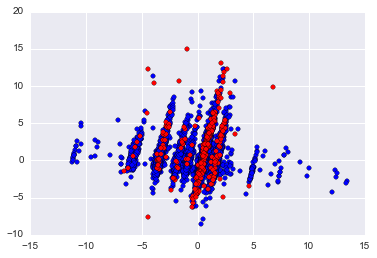

In [961]:
dots = np.array(zip(pca_representation, list(scaled_age3_df.quality_imp)))
fig = plt.figure()
plt.scatter([x[0] for x in dots[dots[:, 1]==-1][:, 0]], [x[1] for x in dots[dots[:, 1]==-1][:, 0]], c='b')
plt.scatter([x[0] for x in dots[dots[:, 1]==1][:, 0]], [x[1] for x in dots[dots[:, 1]==1][:, 0]], c='r')

In [962]:
pca_representation = pca.fit_transform(scaled_flu_df.drop(['first_cluster','origin_cluster','quality_imp','second_cluster'], axis=1))

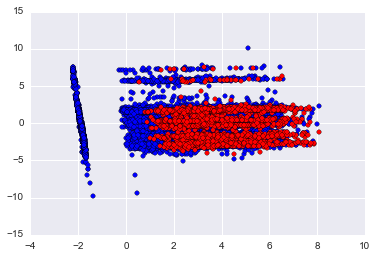

In [964]:
dots = np.array(zip(pca_representation, list(scaled_flu_df.quality_imp)))
fig = plt.figure()
plt.scatter([x[0] for x in dots[dots[:, 1]==-1][:, 0]], [x[1] for x in dots[dots[:, 1]==-1][:, 0]], c='b')
plt.scatter([x[0] for x in dots[dots[:, 1]==1][:, 0]], [x[1] for x in dots[dots[:, 1]==1][:, 0]], c='r')

In [965]:
pca_representation = pca.fit_transform(scaled_mix_df.drop(['first_cluster','origin_cluster','quality_imp','second_cluster'], axis=1))

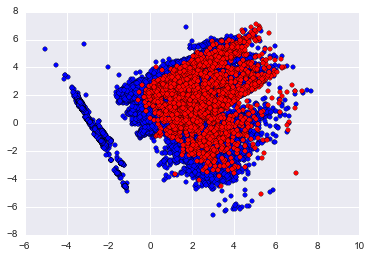

In [966]:
dots = np.array(zip(pca_representation, list(scaled_mix_df.quality_imp)))
fig = plt.figure()
plt.scatter([x[0] for x in dots[dots[:, 1]==-1][:, 0]], [x[1] for x in dots[dots[:, 1]==-1][:, 0]], c='b')
plt.scatter([x[0] for x in dots[dots[:, 1]==1][:, 0]], [x[1] for x in dots[dots[:, 1]==1][:, 0]], c='r')

In [1215]:
age3_df.head()

context1 context2 context3 context4 context5 mutated_letter   pos1   pos2  \
0        G        G        G        G        C              T   44.0   19.0   
2        G        T        G        C        A              T   66.0   36.0   
5        G        G        G        A        C              A  353.0  230.0   
7        C        T        C        G        G              A   49.0  162.0   
8        A        C        G        G        C              T  275.0  150.0   

    pos3  second_vote_std      ...       second_cluster  pos1_in_CDR1  \
0    7.0         0.005315      ...                    ?             0   
2  108.0         0.024800      ...                    ?             0   
5  155.0         0.024305      ...                    ?             0   
7    3.0         0.041903      ...                    ?             0   
8  317.0         0.008292      ...                    ?             0   

   pos2_in_CDR1  pos3_in_CDR1  pos1_in_CDR2  pos2_in_CDR2  pos3_in_CDR2  \
0             0             0             0             0             0   
2             0             0             0             0             0   
5             0             0             0             0             1   
7             0             0             0             1             0   
8             0             0             0             0             0   

   pos1_in_CDR3  pos2_in_CDR3  pos3_in_CDR3  
0             0             0             0  
2             0             0             0  
5             0             0             0  
7             0             0             0  
8             0             0             1  

[5 rows x 33 columns]

In [1273]:
temp_df.CDR2_start = temp_df.CDR2_start.map(int)

In [1274]:
temp_df.to_csv('data/flu/flu_df.csv')

In [35]:
#age3_df = pd.read_csv('data/age3/age3_df.csv', index_col='Unnamed: 0')
#flu_df = pd.read_csv('data/flu/current_df.csv', index_col='Unnamed: 0')
drop_columns = ['first_cluster','origin_cluster','quality_imp','second_cluster', 
                 u'bool_pos1', u'bool_pos2', u'bool_pos3', u'context1_ ',
               u'context1_A', u'context1_C', u'context1_G', u'context1_T',
               u'context2_ ', u'context2_A', u'context2_C', u'context2_G',
               u'context2_T', u'context3_ ', u'context3_A', u'context3_C',
               u'context3_G', u'context3_T', u'context4_ ', u'context4_A',
               u'context4_C', u'context4_G', u'context4_T', u'context5_ ',
               u'context5_A', u'context5_C', u'context5_G', u'context5_T',
               u'mutated_letter_ ', u'mutated_letter_A', u'mutated_letter_C',
               u'mutated_letter_G', u'mutated_letter_T', 'pos1_in_CDR1',
               'pos2_in_CDR1', 'pos3_in_CDR1', 'pos1_in_CDR2',
               'pos2_in_CDR2', 'pos3_in_CDR2', 'pos1_in_CDR3',
               'pos2_in_CDR3', 'pos3_in_CDR3']

for column in drop_columns:
    if column not in age3_df.columns:
        age3_df[column] = [0]*len(age3_df)

#scaled_mix_df = pd.DataFrame(scale(mixed.drop(drop_columns, axis=1)),
#            columns = mixed.drop(drop_columns, axis=1).columns,
#            index = mixed.index)
scaled_age3_df = pd.DataFrame(scale(age3_df.drop(drop_columns, axis=1)),
            columns = age3_df.drop(drop_columns, axis=1).columns,
            index = age3_df.index)
#scaled_flu_df = pd.DataFrame(scale(flu_df.drop(drop_columns, axis=1)),
#            columns = flu_df.drop(drop_columns, axis=1).columns,
#            index = flu_df.index)

#scaled_mix_df = pd.concat([scaled_mix_df, mixed[drop_columns]], axis=1)
scaled_age3_df = pd.concat([scaled_age3_df, age3_df[drop_columns]], axis=1)
#scaled_flu_df = pd.concat([scaled_flu_df, flu_df[drop_columns]], axis=1)

In [38]:
#scaled_mix_df.to_csv('data/age3_flu_mixed_scaled.csv')
scaled_age3_df.to_csv('data/age3/age3_scaled_df.csv')
#scaled_flu_df.to_csv('data/flu/flu_scaled_df.csv')

## p-values for scaled features in mixed dataset

In [113]:
cls_l = sm.OLS(scaled_flu_df.quality_imp, sm.add_constant(scaled_flu_df.drop(['first_cluster','origin_cluster','quality_imp','second_cluster'], 
                                                               axis=1), has_constant='add'))

res1 = cls_l.fit_regularized()

res1.summary()

/Users/Macbook/anaconda/lib/python2.7/site-packages/statsmodels/regression/linear_model.py:1263: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(eigvals[0]/eigvals[-1])
/Users/Macbook/anaconda/lib/python2.7/site-packages/statsmodels/base/model.py:978: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse
/Users/Macbook/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/Macbook/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/Macbook/anaconda/lib/python2.7/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            quality_imp   R-squared:                       0.410
Model:                            OLS   Adj. R-squared:                  0.409
Method:                 Least Squares   F-statistic:                     555.5
Date:                Mon, 24 Jul 2017   Prob (F-statistic):               0.00
Time:                        19:48:46   Log-Likelihood:                -11766.
No. Observations:               36804   AIC:                         2.363e+04
Df Residuals:                   36757   BIC:                         2.403e+04
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               -0.9173   2.47e+11  -3.71e-12      1.000     -4.84e+11  4.84e+11
second_vote_std      0.1727      0.003     52.035      0.000         0.166     0.179
size                 0.1363      0.003     53.684      0.000         0.131     0.141
value1               0.0419      0.007      6.017      0.000         0.028     0.056
value2               0.0083      0.007      1.158      0.247        -0.006     0.022
value3              -0.0974      0.006    -16.966      0.000        -0.109    -0.086
CDR1_start           0.0033      0.002      1.635      0.102        -0.001     0.007
CDR2_start          -0.0096      0.021     -0.456      0.649        -0.051     0.032
CDR3_start           0.0070      0.009      0.789      0.430        -0.010     0.024
CDR1_end             0.0088      0.021      0.417      0.676        -0.032     0.050
CDR2_end            -0.0053      0.009     -0.562      0.574        -0.024     0.013
CDR3_end            -0.0031      0.003     -0.944      0.345        -0.009     0.003
pos1_ex              0.0088      0.005      1.893      0.058        -0.000     0.018
pos2_ex              0.0134      0.004      3.453      0.001         0.006     0.021
pos3_ex              0.0064      0.004      1.557      0.119        -0.002     0.014
bool_pos1           -0.0016   2.02e+11  -8.14e-15      1.000     -3.95e+11  3.95e+11
bool_pos2           -0.0796      0.019     -4.283      0.000        -0.116    -0.043
bool_pos3            0.2438      0.016     15.156      0.000         0.212     0.275
context1_           -0.0193   7.81e+10  -2.47e-13      1.000     -1.53e+11  1.53e+11
context1_A          -0.0981   9.15e+10  -1.07e-12      1.000     -1.79e+11  1.79e+11
context1_C          -0.0598   9.15e+10  -6.53e-13      1.000     -1.79e+11  1.79e+11
context1_G          -0.0825   9.15e+10  -9.01e-13      1.000     -1.79e+11  1.79e+11
context1_T          -0.0723   9.15e+10   -7.9e-13      1.000     -1.79e+11  1.79e+11
context2_                -0          0        nan        nan            -0         0
context2_A           0.0022   8.33e+10   2.65e-14      1.000     -1.63e+11  1.63e+11
context2_C          -0.0048   8.33e+10  -5.72e-14      1.000     -1.63e+11  1.63e+11
context2_G          -0.0106   8.33e+10  -1.28e-13      1.000     -1.63e+11  1.63e+11
context2_T           0.0259   8.33e+10   3.11e-13      1.000     -1.63e+11  1.63e+11
context3_            0.0204   1.01e+11   2.01e-13      1.000     -1.98e+11  1.98e+11
context3_A          -0.0585   7.25e+10  -8.07e-13      1.000     -1.42e+11  1.42e+11
context3_C          -0.0234   7.25e+10  -3.22e-13      1.000     -1.42e+11  1.42e+11
context3_G           0.0088   7.25e+10   1.22e-13      1.000     -1.42e+11  1.42e+11
context3_T          -0.0447   7.25e+10  -6.16e-13      1.000     -1.42e+11  1.42e+11
context4_              

In [114]:
cls_l = sm.OLS(scaled_age3_df.quality_imp, sm.add_constant(scaled_age3_df.drop(['first_cluster','origin_cluster','quality_imp','second_cluster'], 
                                                               axis=1), has_constant='add'))

res2 = cls_l.fit_regularized()

res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            quality_imp   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.191
Method:                 Least Squares   F-statistic:                     79.00
Date:                Mon, 24 Jul 2017   Prob (F-statistic):               0.00
Time:                        19:49:13   Log-Likelihood:                -1199.7
No. Observations:               14198   AIC:                             2487.
Df Residuals:                   14154   BIC:                             2820.
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               -0.9633   3.27e+11  -2.95e-12      1.000     -6.41e+11  6.41e+11
second_vote_std     -0.1083      0.006    -16.703      0.000        -0.121    -0.096
size                 0.0939      0.002     39.053      0.000         0.089     0.099
value1               0.2111      0.007     28.799      0.000         0.197     0.225
value2               0.0468      0.004     10.661      0.000         0.038     0.055
value3              -0.0937      0.005    -19.145      0.000        -0.103    -0.084
CDR1_start          -0.0037      0.002     -1.640      0.101        -0.008     0.001
CDR2_start          -0.0202      0.017     -1.195      0.232        -0.053     0.013
CDR3_start          -0.0050      0.012     -0.416      0.677        -0.028     0.018
CDR1_end             0.0180      0.017      1.074      0.283        -0.015     0.051
CDR2_end             0.0096      0.012      0.779      0.436        -0.015     0.034
CDR3_end            -0.0011      0.002     -0.489      0.625        -0.006     0.003
pos1_ex              0.0051      0.003      1.835      0.067        -0.000     0.011
pos2_ex             -0.0026      0.003     -0.999      0.318        -0.008     0.003
pos3_ex              0.0065      0.003      2.503      0.012         0.001     0.012
bool_pos1                 0          0        nan        nan             0         0
bool_pos2                -0          0        nan        nan            -0         0
bool_pos3                -0          0        nan        nan            -0         0
context1_            0.2078   4.67e+10   4.45e-12      1.000     -9.16e+10  9.16e+10
context1_A           0.0050   4.67e+10   1.08e-13      1.000     -9.16e+10  9.16e+10
context1_C          -0.0040   4.67e+10  -8.49e-14      1.000     -9.16e+10  9.16e+10
context1_G          -0.0064   4.67e+10  -1.37e-13      1.000     -9.16e+10  9.16e+10
context1_T           0.0078   4.67e+10   1.66e-13      1.000     -9.16e+10  9.16e+10
context2_           -0.4584   4.67e+10  -9.81e-12      1.000     -9.16e+10  9.16e+10
context2_A           0.0147   4.67e+10   3.15e-13      1.000     -9.16e+10  9.16e+10
context2_C          -0.0098   4.67e+10  -2.09e-13      1.000     -9.16e+10  9.16e+10
context2_G          -0.0033   4.67e+10  -7.09e-14      1.000     -9.16e+10  9.16e+10
context2_T           0.0034   4.67e+10   7.32e-14      1.000     -9.16e+10  9.16e+10
context3_                 0          0        nan        nan             0         0
context3_A          -0.0168   5.84e+10  -2.87e-13      1.000     -1.14e+11  1.14e+11
context3_C          -0.0091   5.84e+10  -1.56e-13      1.000     -1.14e+11  1.14e+11
context3_G           0.0213   5.84e+10   3.64e-13      1.000     -1.14e+11  1.14e+11
context3_T          -0.0054   5.84e+10  -9.17e-14      1.000     -1.14e+11  1.14e+11
context4_              

In [1033]:
cls_l = sm.OLS(scaled_mix_df.quality_imp, sm.add_constant(scaled_mix_df.drop(['first_cluster','origin_cluster','quality_imp','second_cluster'], 
                                                               axis=1), has_constant='add'))

res3 = cls_l.fit_regularized()

res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            quality_imp   R-squared:                       0.339
Model:                            OLS   Adj. R-squared:                  0.339
Method:                 Least Squares   F-statistic:                     688.5
Date:                Fri, 21 Jul 2017   Prob (F-statistic):               0.00
Time:                        19:17:38   Log-Likelihood:                -15117.
No. Observations:               51002   AIC:                         3.031e+04
Df Residuals:                   50963   BIC:                         3.066e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
const               -0.9164   5.75e+10  -1.59e-11      1.000     -1.13e+11  1.13e+11
CDR1_end             0.0116      0.016      0.712      0.477        -0.020     0.044
CDR1_start           0.0003      0.002      0.163      0.870        -0.004     0.004
CDR2_end             0.1088      0.015      7.359      0.000         0.080     0.138
CDR2_start           0.0045      0.016      0.277      0.782        -0.028     0.037
CDR3_end            -0.0253      0.004     -6.746      0.000        -0.033    -0.018
CDR3_start          -0.1882      0.015    -12.159      0.000        -0.219    -0.158
pos1_ex              0.0115      0.002      4.600      0.000         0.007     0.016
pos2_ex              0.0129      0.003      5.094      0.000         0.008     0.018
pos3_ex              0.0201      0.002      8.640      0.000         0.016     0.025
second_vote_std      0.1521      0.002     66.725      0.000         0.148     0.157
size                 0.1212      0.002     74.729      0.000         0.118     0.124
value1               0.0237      0.005      4.874      0.000         0.014     0.033
value2               0.0300      0.005      5.635      0.000         0.020     0.040
value3              -0.0792      0.004    -17.699      0.000        -0.088    -0.070
bool_pos1            0.0158   1.26e+11   1.26e-13      1.000     -2.47e+11  2.47e+11
bool_pos2           -0.1179      0.016     -7.236      0.000        -0.150    -0.086
bool_pos3            0.2618      0.014     18.188      0.000         0.234     0.290
context1_           -0.0509    4.4e+10  -1.16e-12      1.000     -8.62e+10  8.62e+10
context1_A          -0.1026    4.4e+10  -2.33e-12      1.000     -8.62e+10  8.62e+10
context1_C          -0.0825    4.4e+10  -1.87e-12      1.000     -8.62e+10  8.62e+10
context1_G          -0.0996    4.4e+10  -2.26e-12      1.000     -8.62e+10  8.62e+10
context1_T          -0.0853    4.4e+10  -1.94e-12      1.000     -8.62e+10  8.62e+10
context2_           -0.0413   6.69e+10  -6.18e-13      1.000     -1.31e+11  1.31e+11
context2_A           0.0366   6.69e+10   5.47e-13      1.000     -1.31e+11  1.31e+11
context2_C           0.0238   6.69e+10   3.57e-13      1.000     -1.31e+11  1.31e+11
context2_G           0.0268   6.69e+10   4.02e-13      1.000     -1.31e+11  1.31e+11
context2_T           0.0466   6.69e+10   6.97e-13      1.000     -1.31e+11  1.31e+11
context3_            0.0715   3.81e+10   1.88e-12      1.000     -7.47e+10  7.47e+10
context3_A          -0.0730   7.43e+10  -9.82e-13      1.000     -1.46e+11  1.46e+11
context3_C          -0.0686   7.43e+10  -9.22e-13      1.000     -1.46e+11  1.46e+11
context3_G          -0.0232   7.43e+10  -3.12e-13      1.000     -1.46e+11  1.46e+11
context3_T          -0.0594   7.43e+10  -7.99e-13      1.000     -1.46e+11  1.46e+11
context4_              

In [117]:
ch_features = list(set.intersection(set(res2.params[res2.pvalues < 0.05].index),set(res1.params[res1.pvalues < 0.05].index)))

In [119]:
ch_features

['pos2_in_CDR3',
 'pos2_in_CDR1',
 'value3',
 'pos3_in_CDR1',
 'value1',
 'second_vote_std',
 'size']

In [118]:
clf_l = LogisticRegression(penalty='l1')

clf = GridSearchCV(estimator=clf_l, param_grid={'C':np.linspace(1e-4,0.7,10)}, cv=3, scoring='roc_auc')

X_train, X_test, y_train, y_test = train_test_split(scaled_flu_df[ch_features], 
                                                    scaled_flu_df.quality_imp, test_size=0.2, 
                                                    train_size=0.8, stratify=scaled_flu_df.quality_imp)

clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-04,   7.78667e-02,   1.55633e-01,   2.33400e-01,
         3.11167e-01,   3.88933e-01,   4.66700e-01,   5.44467e-01,
         6.22233e-01,   7.00000e-01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [120]:
roc_auc_score(y_test, clf.best_estimator_.predict(X_test))

0.78274480271764824

In [122]:
roc_auc_score(scaled_age3_df.quality_imp, 
              clf.best_estimator_.predict(scaled_age3_df[ch_features]))

0.65595466934045366

In [1057]:
cls_l = sm.OLS(scaled_mix_df.quality_imp, sm.add_constant(scaled_mix_df[ch_features], has_constant='add'))

res3 = cls_l.fit_regularized()

res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            quality_imp   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.291
Method:                 Least Squares   F-statistic:                     3496.
Date:                Fri, 21 Jul 2017   Prob (F-statistic):               0.00
Time:                        19:27:26   Log-Likelihood:                -16897.
No. Observations:               51002   AIC:                         3.381e+04
Df Residuals:                   50995   BIC:                         3.387e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
const              -0.9164      0.001   -614.021      0.000        -0.919    -0.913
pos1_ex            -0.0106      0.002     -5.379      0.000        -0.014    -0.007
value3             -0.0112      0.002     -4.806      0.000        -0.016    -0.007
value1              0.0096      0.003      3.753      0.000         0.005     0.015
pos3_ex             0.0091      0.002      4.488      0.000         0.005     0.013
second_vote_std     0.1710      0.002     92.314      0.000         0.167     0.175
size                0.1196      0.002     76.734      0.000         0.117     0.123
==============================================================================
Omnibus:                    30040.312   Durbin-Watson:                   1.844
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           500384.522
Skew:                           2.519   Prob(JB):                         0.00
Kurtosis:                      17.494   Cond. No.                         3.91
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [9]:
ans_features = ['first_cluster','origin_cluster','quality_imp','second_cluster']

In [87]:
cls = RandomForestClassifier()

In [88]:
cls.fit(scaled_flu_df.drop(ans_features, axis=1), scaled_flu_df.quality_imp)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

([<matplotlib.axis.XTick at 0x112fe8850>,
 <a list of 56 Text xticklabel objects>)

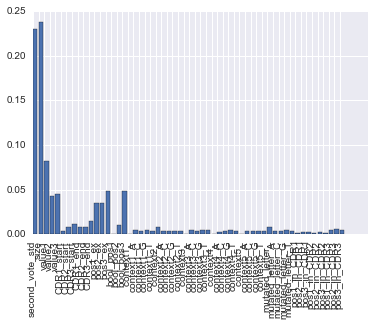

In [89]:
plt.bar(range(len(cls.feature_importances_)), cls.feature_importances_)
plt.xticks(range(len(cls.feature_importances_)), scaled_flu_df.drop(ans_features, axis=1).columns, rotation=90)

In [129]:
ch_features

['pos2_in_CDR3',
 'pos2_in_CDR1',
 'value3',
 'pos3_in_CDR1',
 'value1',
 'second_vote_std',
 'size']

In [156]:
a =  ['value1', 'value2', 'value3', 'second_vote_std', 'size']

In [405]:
clf_l = RandomForestClassifier(n_estimators=200)

clf = GridSearchCV(estimator=clf_l, param_grid={'max_depth': range(1,10,3)}, cv=3, scoring='roc_auc')

In [406]:
X_flu_train, X_flu_test, y_flu_train, y_flu_test = train_test_split(flu_df[['second_vote_std', 'size', 'CDR_sum', 'pos_ex_value_sum']],
                                                    flu_df.quality_imp, test_size=0.2, 
                                                    train_size=0.8, stratify=flu_df.quality_imp)
X_age3_train, X_age3_test, y_age3_train, y_age3_test = train_test_split(age3_df[['second_vote_std', 'size', 'CDR_sum', 'pos_ex_value_sum']], 
                                                    age3_df.quality_imp, test_size=0.2, 
                                                    train_size=0.8, stratify=age3_df.quality_imp)
X_train = pd.concat([X_flu_train, X_age3_train])
X_test = pd.concat([X_flu_test, X_age3_test])
y_train = pd.concat([y_flu_train, y_age3_train])
y_test = pd.concat([y_flu_test, y_age3_test])
                                                                        
clf.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=200, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': [1, 4, 7]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='roc_auc', verbose=0)

In [407]:
roc_auc_score(y_test, clf.best_estimator_.predict(X_test))

0.88859166936829848

In [408]:
roc_auc_score(y_flu_test, 
              clf.best_estimator_.predict(X_flu_test))

0.92182246080345265

In [409]:
roc_auc_score(y_age3_test, 
              clf.best_estimator_.predict(X_age3_test))

0.69156854548410329

In [404]:
clf.best_params_

{'max_depth': 7}

([<matplotlib.axis.XTick at 0x10e2acbd0>,
 <a list of 56 Text xticklabel objects>)

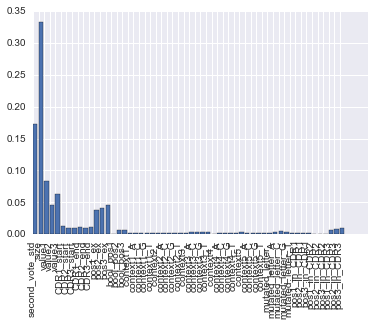

In [76]:
plt.bar(range(len(clf.best_estimator_.feature_importances_)), clf.best_estimator_.feature_importances_)
plt.xticks(range(len(clf.best_estimator_.feature_importances_)), scaled_flu_df.drop(ans_features, axis=1).columns,
           rotation=90)

In [82]:
added_features = [u'pos1_in_CDR1', u'pos2_in_CDR1', u'pos3_in_CDR1', u'pos1_in_CDR2',
       u'pos2_in_CDR2', u'pos3_in_CDR2', u'pos1_in_CDR3', u'pos2_in_CDR3',
       u'pos3_in_CDR3']

In [639]:
clf_l = RandomForestClassifier(n_estimators=100)
#clf_l = LogisticRegression()

clf = GridSearchCV(estimator=clf_l, param_grid={'max_depth': np.linspace(1, 6, 2)}, cv=3, scoring='roc_auc')

X_flu_train, X_flu_test, y_flu_train, y_flu_test = train_test_split(flu_df[['second_vote_std', 'size', 'CDR_sum',
                                                                            'pos_ex_value_sum', 'pos1_in_CDR3',
                                                                            'pos1_in_CDR3','pos1_in_CDR3']],
                                                    flu_df.quality_imp, test_size=0.2, 
                                                    train_size=0.8, stratify=flu_df.quality_imp)                                                                        
clf.fit(X_flu_train, y_flu_train)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'max_depth': array([ 1.,  6.])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [622]:
from sklearn.metrics import roc_curve

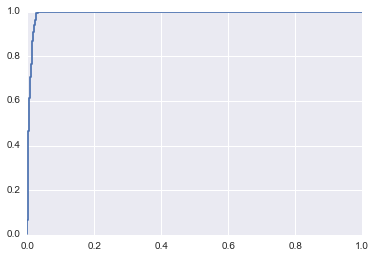

In [640]:
y = roc_curve(y_flu_test, clf.best_estimator_.predict_proba(X_flu_test)[:,1])
plt.plot(y[0], y[1])

In [641]:
roc_auc_score(y_flu_test, clf.best_estimator_.predict_proba(X_flu_test)[:,1])

0.99284583502819879

In [642]:
roc_auc_score(flu_df.quality_imp, clf.best_estimator_.predict_proba(flu_df[['second_vote_std', 'size', 
                                                                            'CDR_sum', 'pos_ex_value_sum',
                                                                           'pos1_in_CDR3','pos2_in_CDR3',
                                                                            'pos3_in_CDR3']])[:,1])

0.99409424453641049

In [643]:
roc_auc_score(age3_df.quality_imp, clf.best_estimator_.predict_proba(age3_df[['second_vote_std', 'size', 
                                                                              'CDR_sum', 'pos_ex_value_sum',
                                                                             'pos1_in_CDR3','pos2_in_CDR3',
                                                                             'pos3_in_CDR3']])[:,1])

0.94143693426694297

In [377]:
cls = sm.OLS(mixed_df.quality_imp, mixed_df[['second_vote_std', 'size', 'CDR_sum', 'pos_ex_value_sum']])
result = cls.fit_regularized()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            quality_imp   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                 1.030e+05
Date:                Tue, 25 Jul 2017   Prob (F-statistic):               0.00
Time:                        06:33:25   Log-Likelihood:                -16114.
No. Observations:               51002   AIC:                         3.224e+04
Df Residuals:                   50998   BIC:                         3.227e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
second_vote_std      6.6216      0.063    104.329      0.000         6.497     6.746
size                 0.0028   3.37e-05     81.997      0.000         0.003     0.003
CDR_sum             -0.0010    1.9e-06   -510.097      0.000        -0.001    -0.001
pos_ex_value_sum  4.477e-05   6.52e-06      6.865      0.000       3.2e-05  5.76e-05
==============================================================================
Omnibus:                    29620.303   Durbin-Watson:                   1.907
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           546896.817
Skew:                           2.432   Prob(JB):                         0.00
Kurtosis:                      18.287   Cond. No.                     4.76e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.76e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [343]:
roc_auc_score(age3_df.quality_imp, clf.best_estimator_.predict(age3_df[['second_vote_std', 'size', 'CDR_sum', 'value_sum']]))

0.69018648186515097

In [344]:
roc_auc_score(y_flu_test, clf.best_estimator_.predict(X_flu_test))

0.6628343073248032

([<matplotlib.axis.XTick at 0x1248dad50>,
 <a list of 47 Text xticklabel objects>)

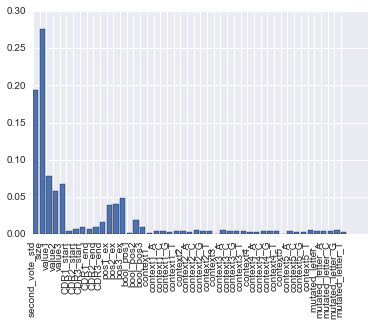

In [1118]:
plt.bar(range(len(clf.best_estimator_.feature_importances_)), clf.best_estimator_.feature_importances_)
plt.xticks(range(len(clf.best_estimator_.feature_importances_)), scaled_flu_df.drop(ans_features, axis=1).columns,
           rotation=90)

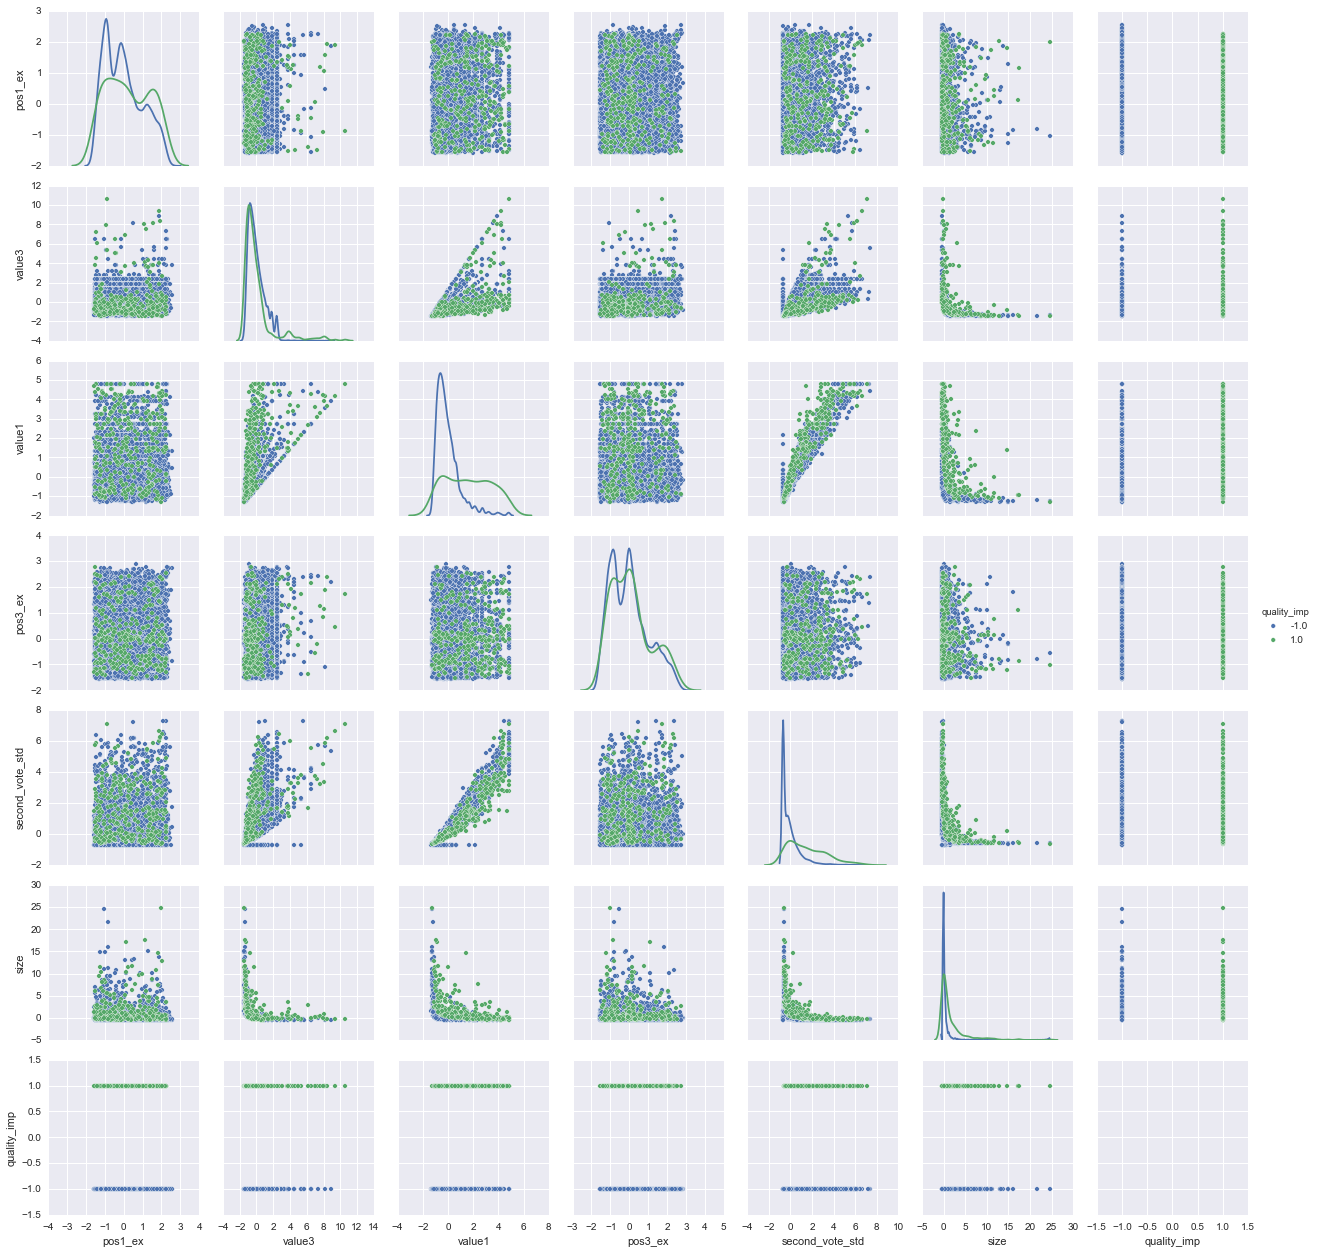

In [1122]:
sb.pairplot(scaled_age3_df[ch_features+['quality_imp']], hue='quality_imp', diag_kind='kde')

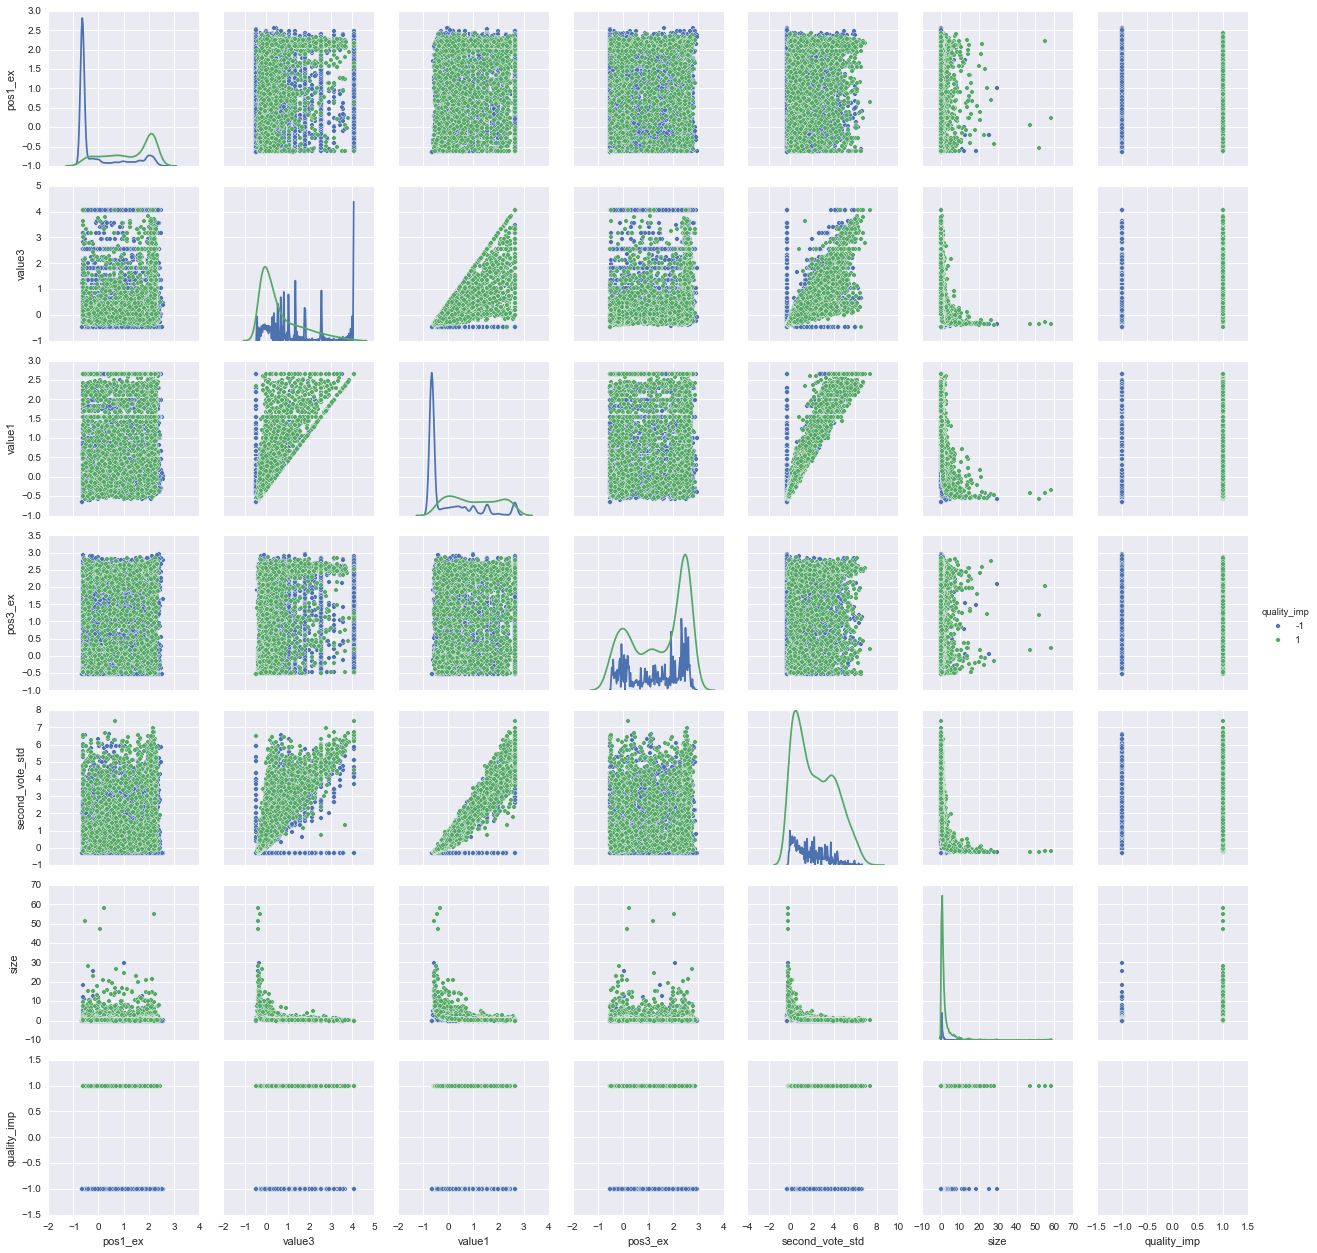

In [1123]:
sb.pairplot(scaled_flu_df[ch_features+['quality_imp']], hue='quality_imp', diag_kind='kde')

In [1124]:
ch_features

['pos1_ex', 'value3', 'value1', 'pos3_ex', 'second_vote_std', 'size']

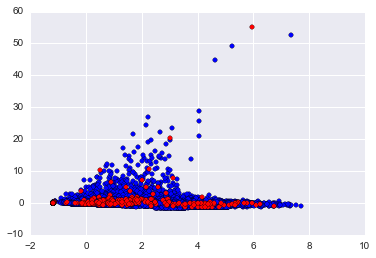

In [1130]:
pca = PCA(n_components=6)
pca_representation = pca.fit_transform(scaled_flu_df[ch_features])
dots = np.array(zip(pca_representation, list(scaled_age3_df.quality_imp)))
fig = plt.figure()
plt.scatter([x[0] for x in dots[dots[:, 1]==-1][:, 0]], [x[1] for x in dots[dots[:, 1]==-1][:, 0]], c='b')
plt.scatter([x[0] for x in dots[dots[:, 1]==1][:, 0]], [x[1] for x in dots[dots[:, 1]==1][:, 0]], c='r')

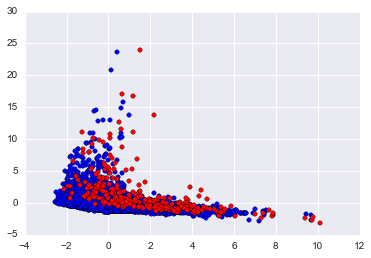

In [1131]:
pca_representation = pca.transform(scaled_age3_df[ch_features])
dots = np.array(zip(pca_representation, list(scaled_age3_df.quality_imp)))
fig = plt.figure()
plt.scatter([x[0] for x in dots[dots[:, 1]==-1][:, 0]], [x[1] for x in dots[dots[:, 1]==-1][:, 0]], c='b')
plt.scatter([x[0] for x in dots[dots[:, 1]==1][:, 0]], [x[1] for x in dots[dots[:, 1]==1][:, 0]], c='r')

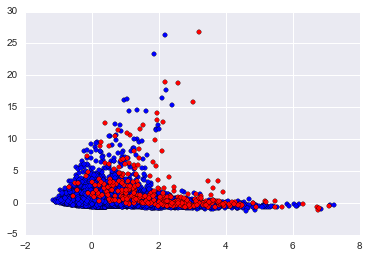

In [1132]:
pca_representation = pca.transform(scaled_mix_df[ch_features])
dots = np.array(zip(pca_representation, list(scaled_age3_df.quality_imp)))
fig = plt.figure()
plt.scatter([x[0] for x in dots[dots[:, 1]==-1][:, 0]], [x[1] for x in dots[dots[:, 1]==-1][:, 0]], c='b')
plt.scatter([x[0] for x in dots[dots[:, 1]==1][:, 0]], [x[1] for x in dots[dots[:, 1]==1][:, 0]], c='r')

In [1140]:
f_regression(scaled_age3_df.drop(ans_features, axis=1), scaled_age3_df.quality_imp)

/Users/Macbook/anaconda/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:279: RuntimeWarning: invalid value encountered in divide
  corr /= row_norms(X.T)


(array([  7.81744247e+02,   9.14430834e+02,   8.71212291e+02,
          1.75042947e+02,   2.00470910e+00,   1.24459467e+00,
          1.70747891e-01,   8.02645047e-01,   1.45383486e-01,
          9.72684858e-01,   1.61423380e-02,   1.89311790e+01,
          1.11995627e+00,   2.64482657e+00,              nan,
                     nan,              nan,   3.95369331e+00,
          2.17548779e+00,   2.58424634e-02,   2.53634932e+00,
          5.98584568e-03,   8.98879269e-02,   1.54900800e+01,
          4.48570492e-03,   2.31995816e+00,   4.01565350e+00,
                     nan,   5.33227320e+00,   9.32610890e-01,
          2.82904968e+00,   1.20424627e+00,              nan,
          6.06105138e-01,   5.19857757e+00,   2.79335300e+01,
          2.06972659e+01,              nan,   3.80583654e+00,
          1.12819324e+00,   2.91212316e+00,   8.46961217e+00,
                     nan,   6.96636657e+00,   3.58146890e+01,
          2.59013643e+00,   9.25932430e+00]),
 array([  1.66750308e-16

In [1142]:
t = f_regression(scaled_age3_df.drop(ans_features, axis=1), scaled_age3_df.quality_imp)

In [1150]:
range(len(t))

[0, 1]

([<matplotlib.axis.XTick at 0x14764b290>,
 <a list of 47 Text xticklabel objects>)

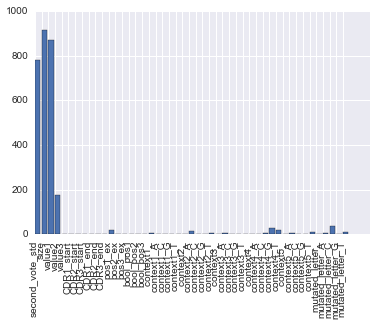

In [1151]:
plt.bar(range(len(t[0])), [0 if np.isnan(x) else x for x in t[0]])
plt.xticks(range(len(t[0])), scaled_age3_df.drop(ans_features, axis=1).columns,
           rotation=90)

([<matplotlib.axis.XTick at 0x14b538550>,
 <a list of 47 Text xticklabel objects>)

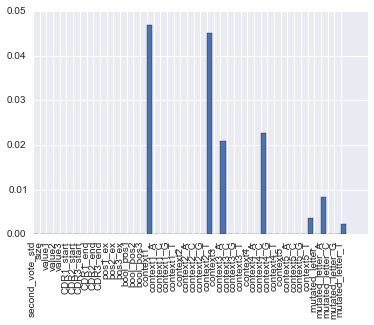

In [1157]:
plt.bar(range(len(t[1])), [0 if np.isnan(x) or x>0.05 else x for x in t[1]])
plt.xticks(range(len(t[1])), scaled_age3_df.drop(ans_features, axis=1).columns,
           rotation=90)

In [1180]:
feature_selector = SelectKBest(k=5)

In [1181]:
pd.DataFrame(feature_selector.fit_transform(scaled_age3_df.drop(ans_features, axis=1), scaled_age3_df.quality_imp),
            columns=scaled_age3_df.columns[feature_selector.get_support()]).head()

second_vote_std      size    value1    value2  context5_G
0        -0.459042  0.434916 -0.956511 -0.824042         0.0
1         0.395125 -0.066290  0.412718 -0.103919         0.0
2         0.373449 -0.146483  0.191600  0.156577         0.0
3         1.144897 -0.306868  1.059990 -0.253705         0.0
4        -0.328547  0.575253 -0.801896 -0.916315         0.0

In [1182]:
pd.DataFrame(feature_selector.fit_transform(scaled_flu_df.drop(ans_features, axis=1), scaled_flu_df.quality_imp),
            columns=scaled_flu_df.drop(ans_features, axis=1).columns[feature_selector.get_support()]).head()

second_vote_std      size   pos3_ex  bool_pos2  bool_pos3
0         0.181815  3.480049  0.030136        1.0        1.0
1         1.517116  2.290273  1.241082        1.0        1.0
2         5.409335  0.007846  2.600740        1.0        1.0
3         2.306855  0.857686  2.505139        1.0        1.0
4         2.333540  1.003372  2.568873        1.0        1.0

In [3]:
age3_df = pd.read_csv('data/age3/age3_df.csv', index_col = 'Unnamed: 0')

In [1195]:
age3_df['pos1_in_CDR1'] = np.where((age3_df['CDR1_start'] < age3_df['pos1']) & (age3_df['pos1'] < age3_df['CDR1_end']), 1, 0)
age3_df['pos2_in_CDR1'] = np.where((age3_df['CDR1_start'] < age3_df['pos2']) & (age3_df['pos2'] < age3_df['CDR1_end']), 1, 0)
age3_df['pos3_in_CDR1'] = np.where((age3_df['CDR1_start'] < age3_df['pos3']) & (age3_df['pos3'] < age3_df['CDR1_end']), 1, 0)

age3_df['pos1_in_CDR2'] = np.where((age3_df['CDR2_start'] < age3_df['pos1']) & (age3_df['pos1'] < age3_df['CDR2_end']), 1, 0)
age3_df['pos2_in_CDR2'] = np.where((age3_df['CDR2_start'] < age3_df['pos2']) & (age3_df['pos2'] < age3_df['CDR2_end']), 1, 0)
age3_df['pos3_in_CDR2'] = np.where((age3_df['CDR2_start'] < age3_df['pos3']) & (age3_df['pos3'] < age3_df['CDR2_end']), 1, 0)

age3_df['pos1_in_CDR3'] = np.where((age3_df['CDR3_start'] < age3_df['pos1']) & (age3_df['pos1'] < age3_df['CDR3_end']), 1, 0)
age3_df['pos2_in_CDR3'] = np.where((age3_df['CDR3_start'] < age3_df['pos2']) & (age3_df['pos2'] < age3_df['CDR3_end']), 1, 0)
age3_df['pos3_in_CDR3'] = np.where((age3_df['CDR3_start'] < age3_df['pos3']) & (age3_df['pos3'] < age3_df['CDR3_end']), 1, 0)

In [99]:
age3_df.to_csv('data/age3/age3_df.csv')

In [100]:
flu_df = pd.read_csv('data/flu/flu_df.csv', index_col = 'Unnamed: 0')

In [1210]:
flu_df['pos1_in_CDR1'] = np.where((flu_df['CDR1_start'] < flu_df['pos1']) & (flu_df['pos1'] < flu_df['CDR1_end']), 1, 0)
flu_df['pos2_in_CDR1'] = np.where((flu_df['CDR1_start'] < flu_df['pos2']) & (flu_df['pos2'] < flu_df['CDR1_end']), 1, 0)
flu_df['pos3_in_CDR1'] = np.where((flu_df['CDR1_start'] < flu_df['pos3']) & (flu_df['pos3'] < flu_df['CDR1_end']), 1, 0)

flu_df['pos1_in_CDR2'] = np.where((flu_df['CDR2_start'] < flu_df['pos1']) & (flu_df['pos1'] < flu_df['CDR2_end']), 1, 0)
flu_df['pos2_in_CDR2'] = np.where((flu_df['CDR2_start'] < flu_df['pos2']) & (flu_df['pos2'] < flu_df['CDR2_end']), 1, 0)
flu_df['pos3_in_CDR2'] = np.where((flu_df['CDR2_start'] < flu_df['pos3']) & (flu_df['pos3'] < flu_df['CDR2_end']), 1, 0)

flu_df['pos1_in_CDR3'] = np.where((flu_df['CDR3_start'] < flu_df['pos1']) & (flu_df['pos1'] < flu_df['CDR3_end']), 1, 0)
flu_df['pos2_in_CDR3'] = np.where((flu_df['CDR3_start'] < flu_df['pos2']) & (flu_df['pos2'] < flu_df['CDR3_end']), 1, 0)
flu_df['pos3_in_CDR3'] = np.where((flu_df['CDR3_start'] < flu_df['pos3']) & (flu_df['pos3'] < flu_df['CDR3_end']), 1, 0)

In [1213]:
flu_df.to_csv('data/flu/flu_df.csv')

In [6]:
scaled_flu_df = pd.read_csv('data/flu/flu_scaled_df.csv', index_col='Unnamed: 0')
scaled_age3_df = pd.read_csv('data/age3/age3_scaled_df.csv', index_col='Unnamed: 0')

In [211]:
scaled_mix_df = pd.concat([scaled_age3_df, scaled_flu_df], ignore_index = True)

In [212]:
scaled_mix_df.quality_imp = scaled_mix_df.quality_imp.map(lambda x: 0 if x==-1 else 1)

In [213]:
Counter(scaled_mix_df.quality_imp)

Counter({0: 48869, 1: 2133})

In [215]:
test_columns = [u'bool_pos1',        u'bool_pos2',        u'bool_pos3',
             u'context1_ ',       u'context1_A',       u'context1_C',
             u'context1_G',       u'context1_T',       u'context2_ ',
             u'context2_A',       u'context2_C',       u'context2_G',
             u'context2_T',       u'context3_ ',       u'context3_A',
             u'context3_C',       u'context3_G',       u'context3_T',
             u'context4_ ',       u'context4_A',       u'context4_C',
             u'context4_G',       u'context4_T',       u'context5_ ',
             u'context5_A',       u'context5_C',       u'context5_G',
             u'context5_T',  u'mutated_letter_ ', u'mutated_letter_A',
       u'mutated_letter_C', u'mutated_letter_G', u'mutated_letter_T', 
               u'pos1_in_CDR1',     u'pos2_in_CDR1',     u'pos3_in_CDR1',
           u'pos1_in_CDR2',     u'pos2_in_CDR2',     u'pos3_in_CDR2',
           u'pos1_in_CDR3',     u'pos2_in_CDR3',     u'pos3_in_CDR3']
for i in test_columns:
    print i+':\t pvalue:',chi_square_of_df_cols(scaled_mix_df, i, 'quality_imp')[1]

bool_pos1:	 pvalue: 0.0
bool_pos2:	 pvalue: 0.0
bool_pos3:	 pvalue: 0.0
context1_ :	 pvalue: 0.0
context1_A:	 pvalue: 1.01519322769e-33
context1_C:	 pvalue: 2.72392175575e-151
context1_G:	 pvalue: 2.85803687859e-16
context1_T:	 pvalue: 5.58942229564e-35
context2_ :	 pvalue: 0.0
context2_A:	 pvalue: 2.79901045619e-58
context2_C:	 pvalue: 2.63844232082e-70
context2_G:	 pvalue: 9.68747025572e-37
context2_T:	 pvalue: 3.19699443189e-35
context3_ :	 pvalue: 0.0
context3_A:	 pvalue: 3.29828972922e-15
context3_C:	 pvalue: 2.11551042623e-23
context3_G:	 pvalue: 1.00481902305e-60
context3_T:	 pvalue: 1.36980385913e-124
context4_ :	 pvalue: 0.0
context4_A:	 pvalue: 5.00591608124e-12
context4_C:	 pvalue: 2.8776118194e-108
context4_G:	 pvalue: 3.03863045006e-22
context4_T:	 pvalue: 2.59910622032e-88
context5_ :	 pvalue: 0.0
context5_A:	 pvalue: 2.89413345709e-29
context5_C:	 pvalue: 2.15723150438e-37
context5_G:	 pvalue: 7.70928608282e-20
context5_T:	 pvalue: 5.48853489974e-145
mutated_letter_ :	 p

In [203]:
chi_square_of_df_cols(scaled_mix_df, 'pos1_in_CDR1', 'context2_A')

[[44228, 5384], [1093, 297]]


(149.96764436990654,
 1.762105503253967e-34,
 1,
 array([[ 44085.82902631,   5526.17097369],
        [  1235.17097369,    154.82902631]]))

In [218]:
chi2_contingency([10, 10], [10, 10])

(0.0, 1.0, 0, array([ 10.,  10.]))

In [326]:
test_columns

[u'bool_pos1',
 u'bool_pos2',
 u'bool_pos3',
 u'context1_ ',
 u'context1_A',
 u'context1_C',
 u'context1_G',
 u'context1_T',
 u'context2_ ',
 u'context2_A',
 u'context2_C',
 u'context2_G',
 u'context2_T',
 u'context3_ ',
 u'context3_A',
 u'context3_C',
 u'context3_G',
 u'context3_T',
 u'context4_ ',
 u'context4_A',
 u'context4_C',
 u'context4_G',
 u'context4_T',
 u'context5_ ',
 u'context5_A',
 u'context5_C',
 u'context5_G',
 u'context5_T',
 u'mutated_letter_ ',
 u'mutated_letter_A',
 u'mutated_letter_C',
 u'mutated_letter_G',
 u'mutated_letter_T',
 u'pos1_in_CDR1',
 u'pos2_in_CDR1',
 u'pos3_in_CDR1',
 u'pos1_in_CDR2',
 u'pos2_in_CDR2',
 u'pos3_in_CDR2',
 u'pos1_in_CDR3',
 u'pos2_in_CDR3',
 u'pos3_in_CDR3']

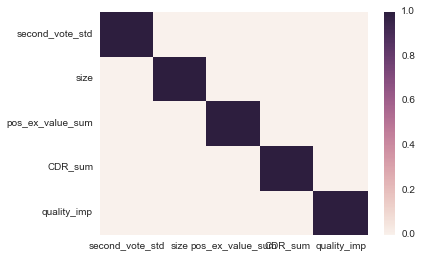

In [426]:
sb.heatmap(mixed_df[['second_vote_std', 'size', 'pos_ex_value_sum', 'CDR_sum', 'quality_imp']].corr() > 0.5)

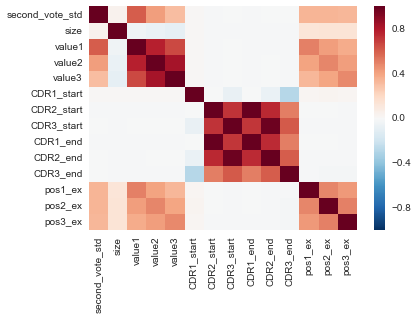

In [351]:
sb.heatmap(scaled_mix_df.drop(test_columns+ans_features, axis=1).corr())

/Users/Macbook/anaconda/lib/python2.7/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/Macbook/anaconda/lib/python2.7/site-packages/statsmodels/nonparametric/kdetools.py:32: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


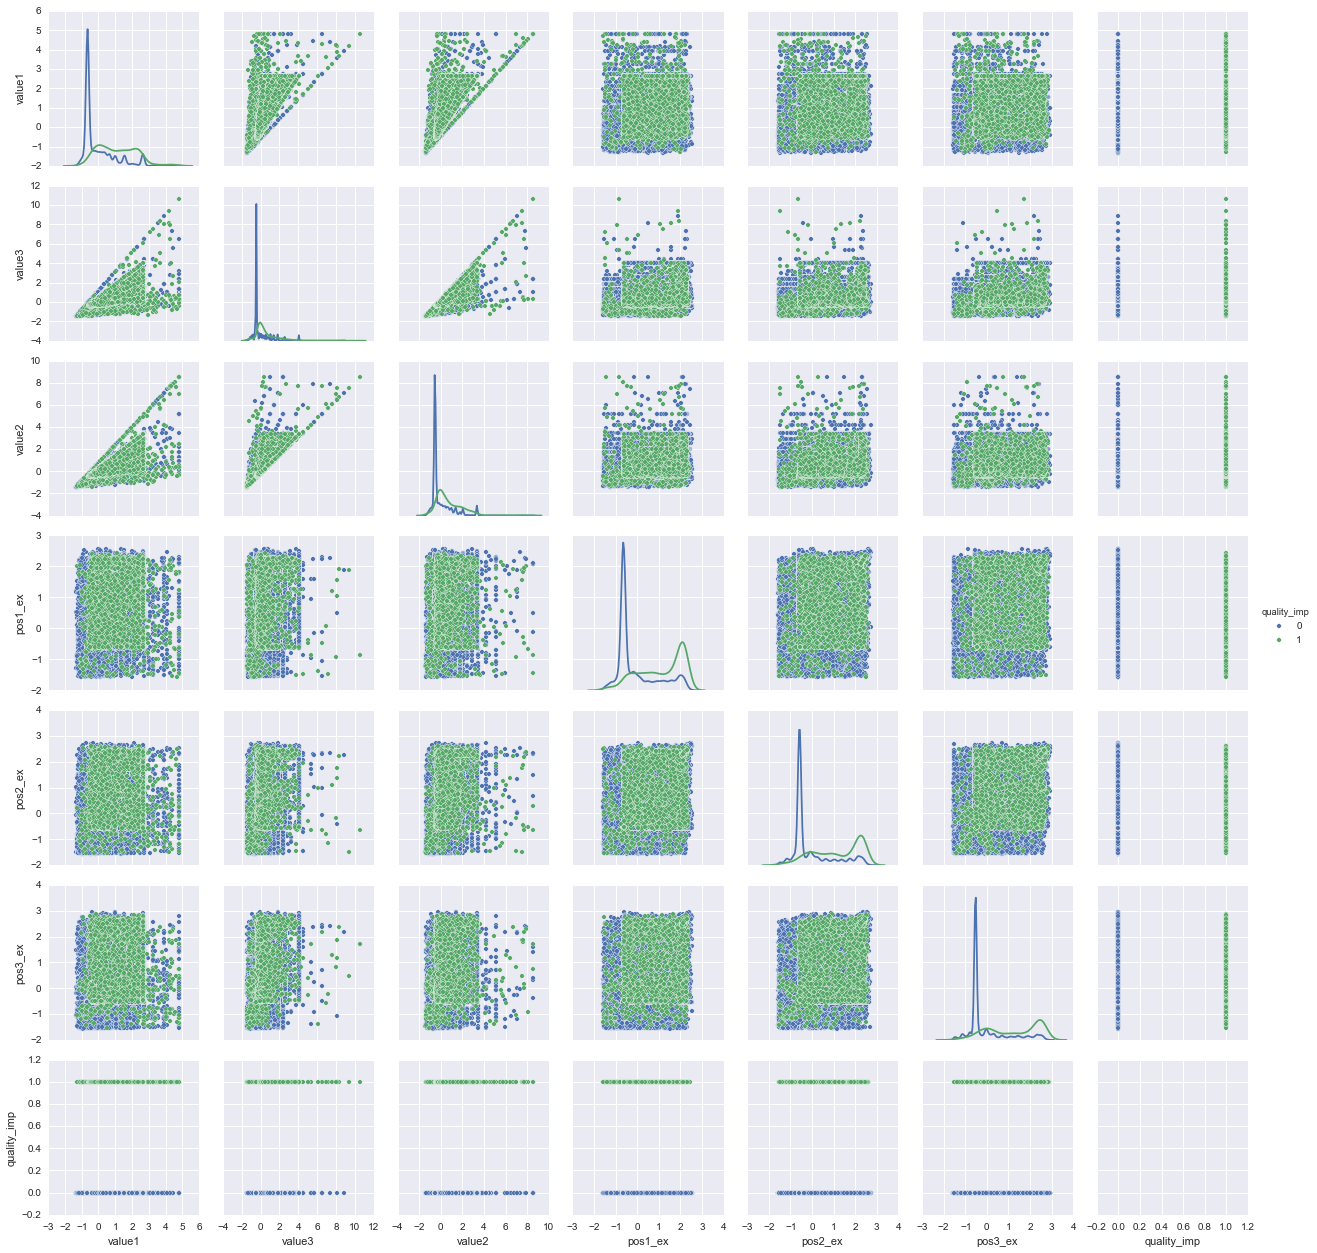

In [228]:
sb.pairplot(scaled_mix_df[['value1', 'value3','value2',
              'pos1_ex', 'pos2_ex', 'pos3_ex', 'quality_imp']], hue='quality_imp', diag_kind='kde')

(array([  4.00000000e+00,   3.90000000e+01,   1.21490000e+04,
          5.10700000e+03,   4.87700000e+03,   1.37890000e+04,
          2.30000000e+01,   6.52000000e+02,   1.63000000e+02,
          1.00000000e+00]),
 array([  9. ,  12.2,  15.4,  18.6,  21.8,  25. ,  28.2,  31.4,  34.6,
         37.8,  41. ]),
 <a list of 10 Patch objects>)

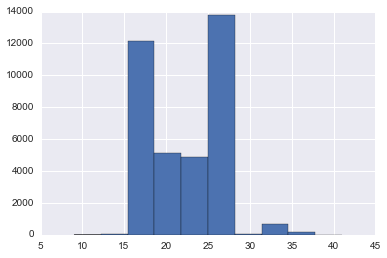

In [235]:
plt.hist((flu_df.CDR1_end - flu_df.CDR1_start))

In [238]:
Counter(flu_df.CDR1_end - flu_df.CDR1_start)

Counter({9.0: 1,
         11.0: 3,
         14.0: 22,
         15.0: 17,
         16.0: 36,
         17.0: 12026,
         18.0: 87,
         19.0: 14,
         20.0: 5080,
         21.0: 13,
         22.0: 18,
         23.0: 4841,
         24.0: 18,
         25.0: 39,
         26.0: 13722,
         27.0: 27,
         28.0: 1,
         29.0: 23,
         32.0: 650,
         33.0: 2,
         35.0: 162,
         36.0: 1,
         41.0: 1})

In [237]:
Counter(flu_df.CDR2_end - flu_df.CDR2_start)

Counter({4: 1,
         5: 2,
         6: 10,
         7: 31,
         8: 35178,
         9: 4,
         10: 1,
         11: 1,
         14: 2,
         18: 1,
         19: 2,
         20: 1494,
         23: 77})

In [239]:
Counter(flu_df.CDR3_end - flu_df.CDR3_start)

Counter({2.0: 1,
         6.0: 1,
         7.0: 1,
         11.0: 13,
         12.0: 4,
         13.0: 1,
         14.0: 68,
         15.0: 1,
         16.0: 1,
         17.0: 71,
         18.0: 5,
         19.0: 5,
         20.0: 106,
         21.0: 21,
         22.0: 33,
         23.0: 1525,
         24.0: 42,
         25.0: 72,
         26.0: 8077,
         27.0: 125,
         28.0: 158,
         29.0: 11446,
         30.0: 224,
         31.0: 134,
         32.0: 11686,
         33.0: 161,
         34.0: 100,
         35.0: 2037,
         36.0: 45,
         37.0: 14,
         38.0: 463,
         39.0: 7,
         40.0: 21,
         41.0: 57,
         42.0: 8,
         43.0: 4,
         44.0: 30,
         45.0: 4,
         46.0: 1,
         47.0: 20,
         50.0: 3,
         53.0: 1,
         56.0: 1,
         59.0: 2,
         62.0: 2,
         83.0: 1,
         91.0: 1})

In [252]:
pca = PCA(n_components=2)
pca.fit_transform(scale(flu_df[[u'CDR3_end', u'CDR3_end']]))

array([[  5.37222675e-01,   2.57019669e-11],
       [ -1.76675208e+00,   3.31904510e-16],
       [  5.37222675e-01,  -7.85552350e-17],
       ..., 
       [  1.30521426e+00,  -2.41543358e-16],
       [ -1.76675208e+00,   3.31904510e-16],
       [  5.37222675e-01,  -7.85552350e-17]])

In [263]:
pca.explained_variance_ratio_

array([  1.00000000e+00,   3.57161256e-29])

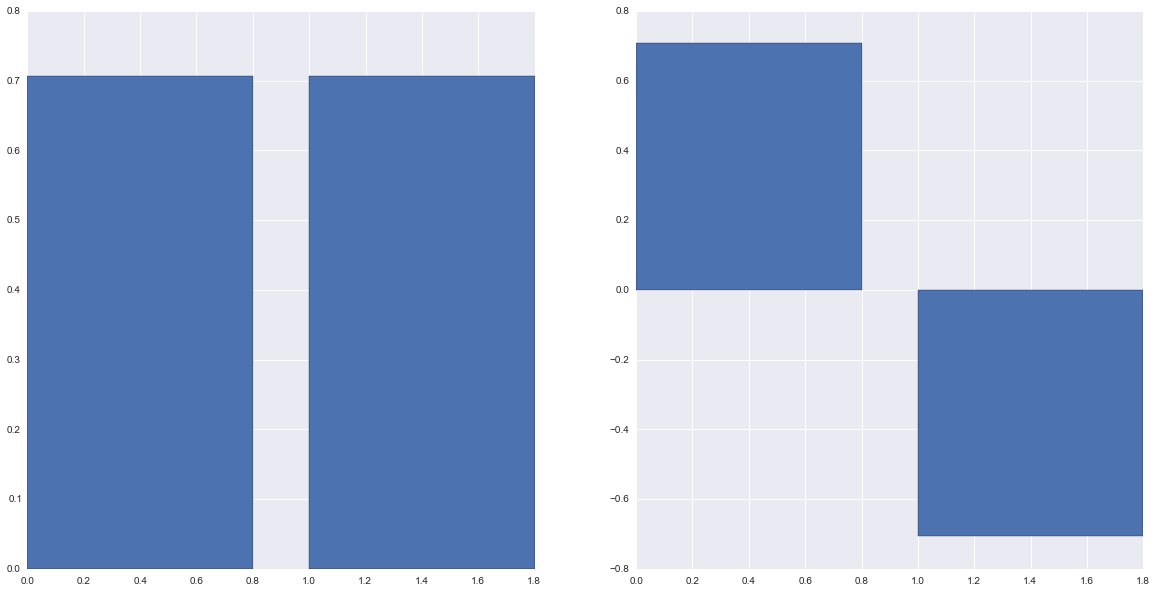

In [253]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 10))
for i, vec in enumerate(np.identity(2)): 
    axes[i].bar(range(2),pca.inverse_transform(vec.T))

In [261]:
pca = PCA(n_components=2)
pca.fit_transform(scale(flu_df[[u'CDR2_end', u'CDR2_end']]))

array([[ -8.74622874e-01,   1.62139278e-12],
       [  1.05555763e+00,  -7.59175850e-18],
       [ -8.74622874e-01,  -4.96773030e-17],
       ..., 
       [ -8.74622874e-01,  -4.96773030e-17],
       [  1.05555763e+00,  -7.59175850e-18],
       [ -8.74622874e-01,  -4.96773030e-17]])

In [262]:
pca.explained_variance_ratio_

array([  1.00000000e+00,   3.57161256e-29])

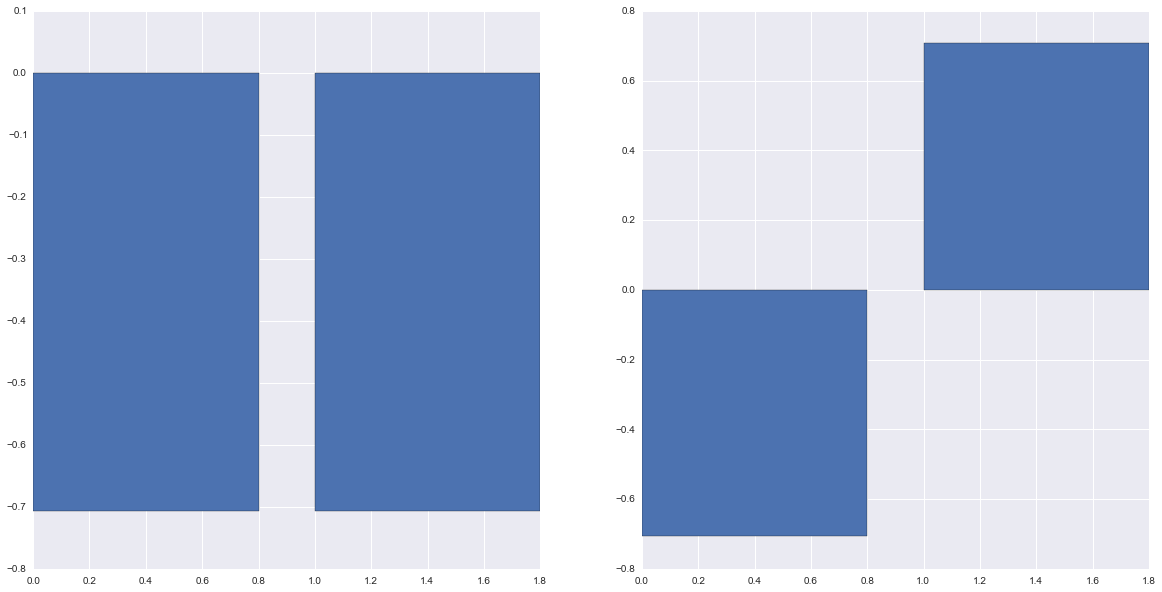

In [255]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 10))
for i, vec in enumerate(np.identity(2)): 
    axes[i].bar(range(2),pca.inverse_transform(vec.T))

In [259]:
pca = PCA(n_components=2)
pca.fit_transform(scale(flu_df[[u'CDR1_end', u'CDR1_end']]))

array([[ -1.17613999e+00,   1.07566879e-11],
       [  1.00733461e+00,   1.92919148e-16],
       [ -1.17613999e+00,  -2.01985249e-16],
       ..., 
       [ -1.17613999e+00,  -2.01985249e-16],
       [  1.00733461e+00,   1.92919148e-16],
       [ -1.17613999e+00,  -2.01985249e-16]])

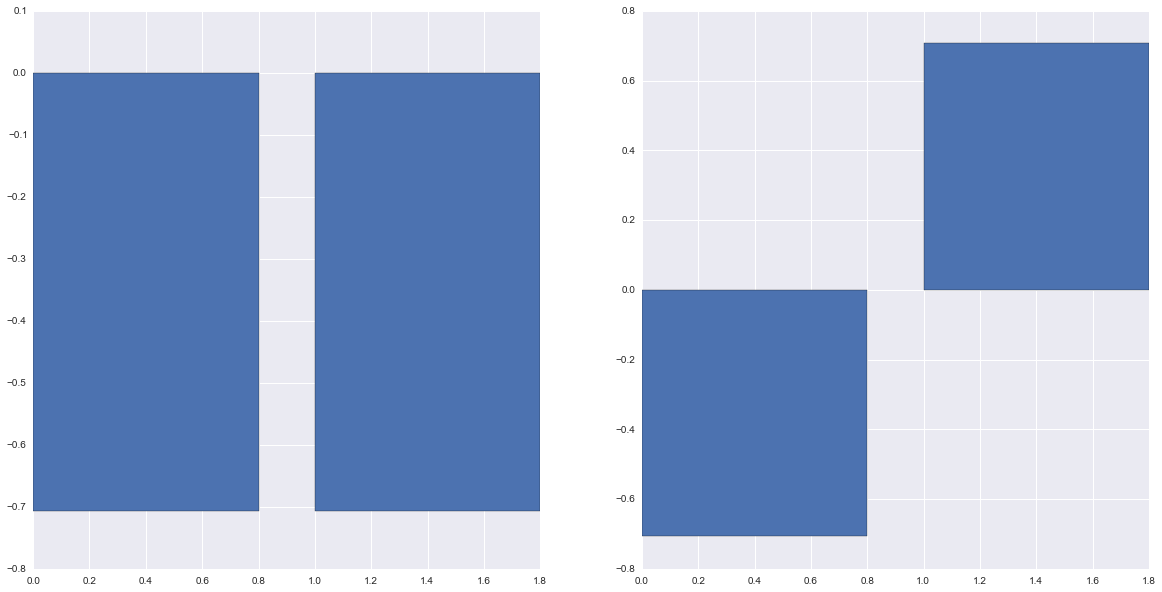

In [257]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 10))
for i, vec in enumerate(np.identity(2)): 
    axes[i].bar(range(2),pca.inverse_transform(vec.T))

In [258]:
pca.explained_variance_ratio_

array([  1.00000000e+00,   1.57195568e-27])

In [270]:
pca = PCA(n_components=6)
pca.fit_transform(scale(flu_df[[u'CDR1_end', u'CDR1_end', 
                               u'CDR2_end', u'CDR2_end',
                               u'CDR3_end', u'CDR3_end']]))

array([[  1.49843677e+00,  -4.27876721e-01,   9.21272094e-02,
          1.19769768e-11,  -3.17811626e-15,   1.96184555e-13],
       [ -2.19720001e+00,  -6.02421022e-01,  -2.44415370e-01,
         -2.13072728e-14,   1.05247341e-14,   1.99120794e-14],
       [  1.49843677e+00,  -4.27876721e-01,   9.21272094e-02,
          9.63997332e-15,   2.37974154e-12,   5.93106488e-15],
       ..., 
       [  1.92750954e+00,   1.62154845e-01,   3.32065490e-01,
         -1.94251039e-16,  -4.21147612e-17,   5.68801118e-18],
       [ -2.19720001e+00,  -6.02421022e-01,  -2.44415370e-01,
          8.74608870e-17,   2.30480957e-17,  -4.31136066e-18],
       [  1.49843677e+00,  -4.27876721e-01,   9.21272094e-02,
         -2.23201618e-16,  -5.37139460e-17,  -1.53391924e-17]])

In [271]:
pca.explained_variance_ratio_

array([  8.37759090e-01,   1.13671202e-01,   4.85697081e-02,
         6.61086535e-28,   2.56470994e-29,   1.00469192e-29])

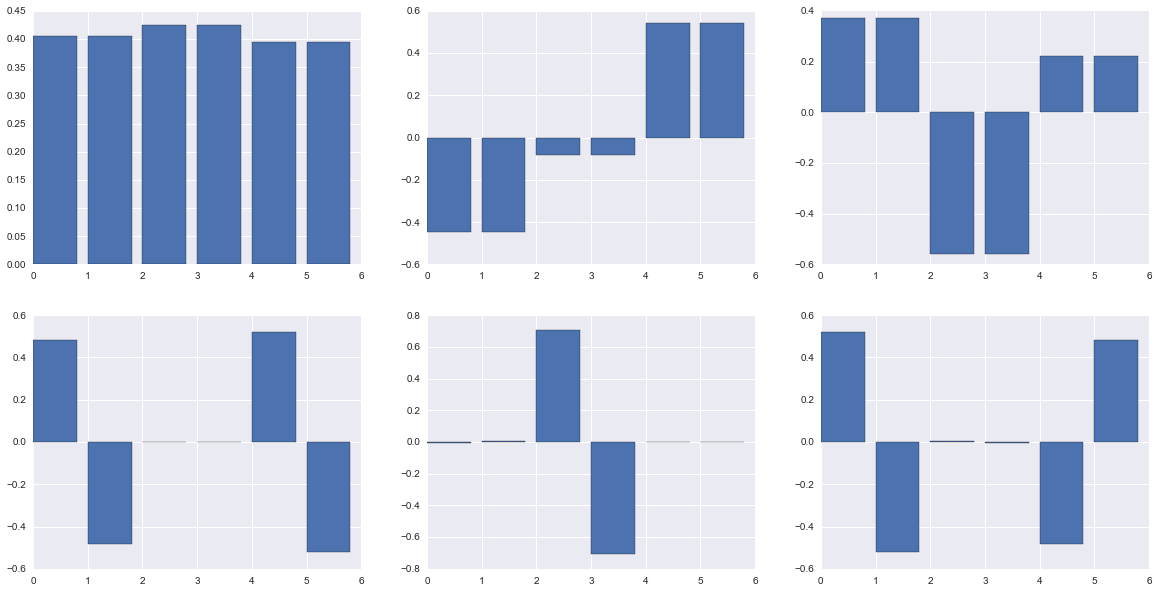

In [276]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))
for i, vec in enumerate(np.identity(6)): 
    axes[i/3, i%3].bar(range(6),pca.inverse_transform(vec.T))

In [289]:
flu_df = pd.read_csv('data/flu/flu_df.csv', index_col='Unnamed: 0')
age3_df = pd.read_csv('data/age3/age3_df.csv', index_col='Unnamed: 0')

In [ ]:
mixed_df['CDR_sum'] = (mixed_df['CDR1_start']+mixed_df['CDR2_start']+mixed_df['CDR3_start']+
mixed_df['CDR1_end']+mixed_df['CDR2_end']+mixed_df['CDR3_end'])

mixed_df['CDR_sum'] = (mixed_df['CDR1_start']+mixed_df['CDR2_start']+mixed_df['CDR3_start']+
mixed_df['CDR1_end']+mixed_df['CDR2_end']+mixed_df['CDR3_end'])

In [292]:
mixed_df = pd.concat([flu_df, age3_df], ignore_index=True)

In [279]:
mixed_df = pd.concat([age3_df, flu_df]

context1_   context1_A  context1_C  context1_G  context1_T  context2_   \
0           0           0           0           1           0           0   
2           0           0           0           1           0           0   
5           0           0           0           1           0           0   
7           0           0           1           0           0           0   
8           0           1           0           0           0           0   

   context2_A  context2_C  context2_G  context2_T        ...         \
0           0           0           1           0        ...          
2           0           0           0           1        ...          
5           0           0           1           0        ...          
7           0           0           0           1        ...          
8           0           1           0           0        ...          

   bool_pos1  bool_pos2  bool_pos3  pos1_ex  pos2_ex  pos3_ex  context3_   \
0          1          1          1     44.0     19.0      7.0           0   
2          1          1          1     66.0     36.0    108.0           0   
5          1          1          1    353.0    230.0    155.0           0   
7          1          1          1     49.0    162.0      3.0           0   
8          1          1          1    275.0    150.0    317.0           0   

   context4_   context5_   mutated_letter_   
0           0           0                 0  
2           0           0                 0  
5           0           0                 0  
7           0           0                 0  
8           0           0                 0  

[5 rows x 60 columns]

In [293]:
pca = PCA(n_components=6)
pca.fit_transform(scale(mixed_df[[u'CDR1_end', u'CDR1_end', 
                               u'CDR2_end', u'CDR2_end',
                               u'CDR3_end', u'CDR3_end']]))

array([[ -3.62366753e-02,  -1.35665354e+00,   3.93148353e-02,
          1.13627014e-11,   7.12380045e-17,  -1.58987490e-16],
       [ -2.23378976e+00,   2.44823452e-01,  -1.05665254e-01,
         -1.00200580e-17,   6.71509476e-15,  -3.79579996e-14],
       [ -3.62366753e-02,  -1.35665354e+00,   3.93148353e-02,
         -5.92509469e-16,   2.53555133e-12,  -1.40439237e-15],
       ..., 
       [  2.60714325e+00,   1.38899176e+00,   9.25697554e-03,
          2.99626325e-16,   3.54752548e-17,   4.78595482e-17],
       [  2.60752742e+00,  -7.43384306e-02,  -2.95132429e-01,
          6.10428119e-17,   2.69218774e-17,   6.96932776e-17],
       [  2.60752742e+00,  -7.43384306e-02,  -2.95132429e-01,
          6.10428119e-17,   2.69218774e-17,   6.96932776e-17]])

In [294]:
pca.explained_variance_ratio_

array([  7.23543393e-01,   2.48426693e-01,   2.80299137e-02,
         4.21925284e-28,   2.10098486e-29,   6.51290382e-30])

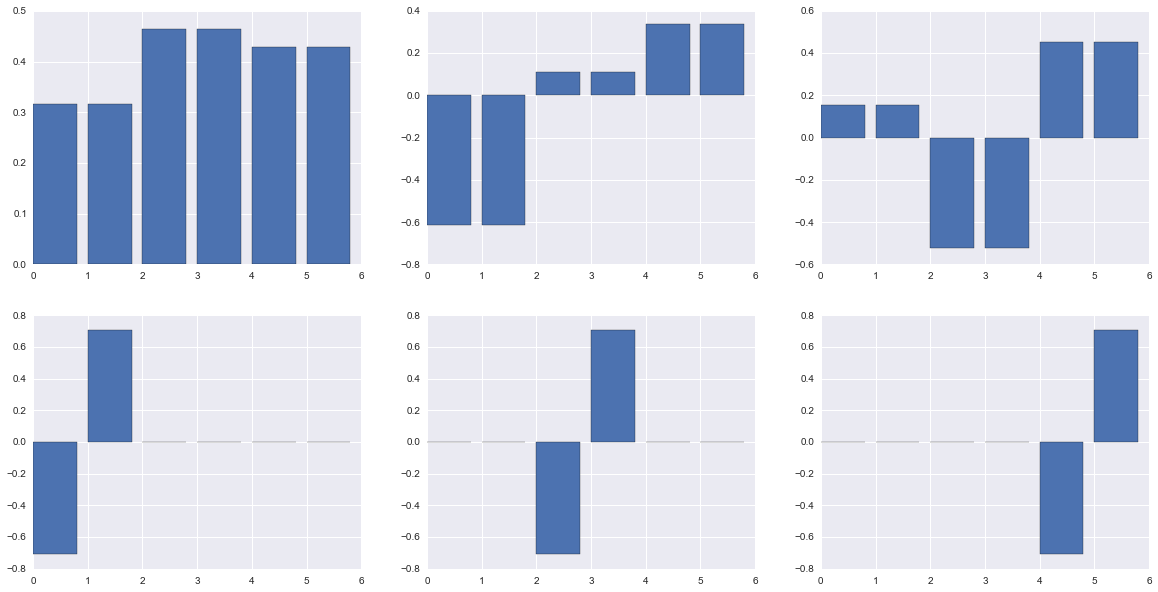

In [295]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))
for i, vec in enumerate(np.identity(6)): 
    axes[i/3, i%3].bar(range(6),pca.inverse_transform(vec.T))

In [369]:
flu_df['pos_ex_value_diff'] = flu_df['pos_ex_sum']-flu_df['value_sum']

In [370]:
age3_df['pos_ex_value_diff'] = age3_df['pos_ex_sum']-age3_df['value_sum']

In [371]:
mixed_df['pos_ex_value_diff'] = mixed_df['pos_ex_sum']-mixed_df['value_sum']

In [303]:
cls = sm.OLS(mixed_df.quality_imp, mixed_df[['value1', 'second_vote_std', 'size', 'CDR_sum']])

In [304]:
result = cls.fit_regularized()

In [306]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            quality_imp   R-squared:                       0.890
Model:                            OLS   Adj. R-squared:                  0.890
Method:                 Least Squares   F-statistic:                 1.029e+05
Date:                Tue, 25 Jul 2017   Prob (F-statistic):               0.00
Time:                        05:40:30   Log-Likelihood:                -16138.
No. Observations:               51002   AIC:                         3.228e+04
Df Residuals:                   50998   BIC:                         3.232e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
value1             -0.0051      0.013     -0.391      0.696        -0.030     0.020
second_vote_std     6.8269      0.068    100.049      0.000         6.693     6.961
size                0.0028    3.3e-05     85.430      0.000         0.003     0.003
CDR_sum            -0.0010   1.78e-06   -538.176      0.000        -0.001    -0.001
==============================================================================
Omnibus:                    29663.327   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           570675.203
Skew:                           2.422   Prob(JB):                         0.00
Kurtosis:                      18.655   Cond. No.                     5.01e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.01e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [320]:
pca = PCA(n_components=3)
pca.fit_transform(scale(mixed_df[['value1','value2','value3']]))
pca.explained_variance_ratio_

array([ 0.8555785 ,  0.10289105,  0.04153045])

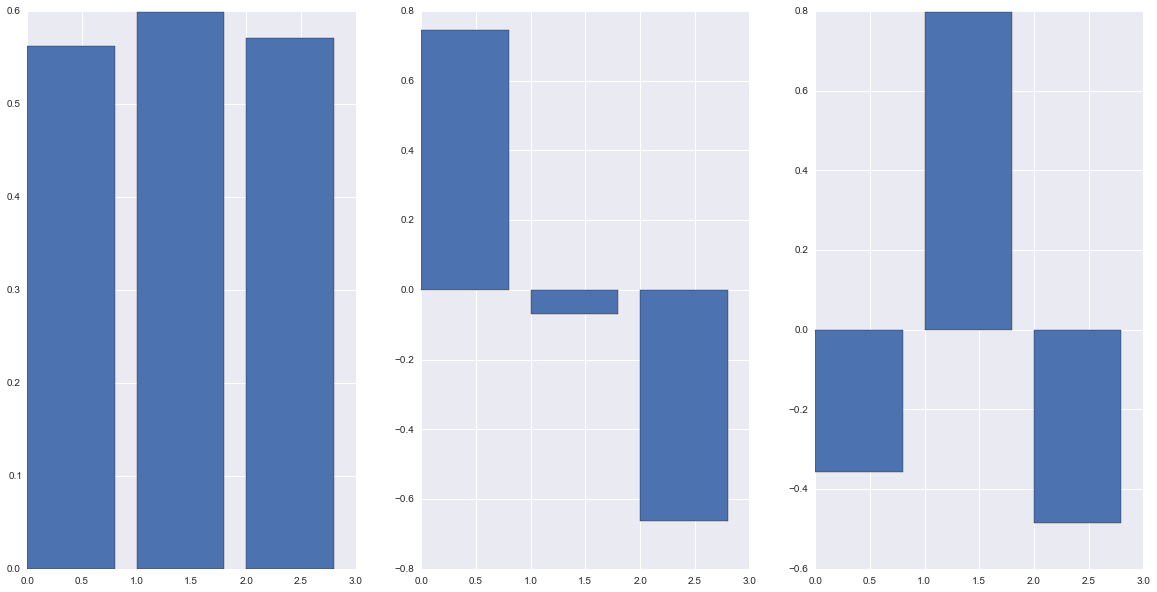

In [321]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 10))
for i, vec in enumerate(np.identity(3)): 
    axes[i%3].bar(range(3),pca.inverse_transform(vec.T))

In [352]:
pca = PCA(n_components=3)
pca.fit_transform(scale(mixed_df[['pos1_ex','pos2_ex','pos3_ex']]))
pca.explained_variance_ratio_

array([ 0.70743324,  0.16009694,  0.13246982])

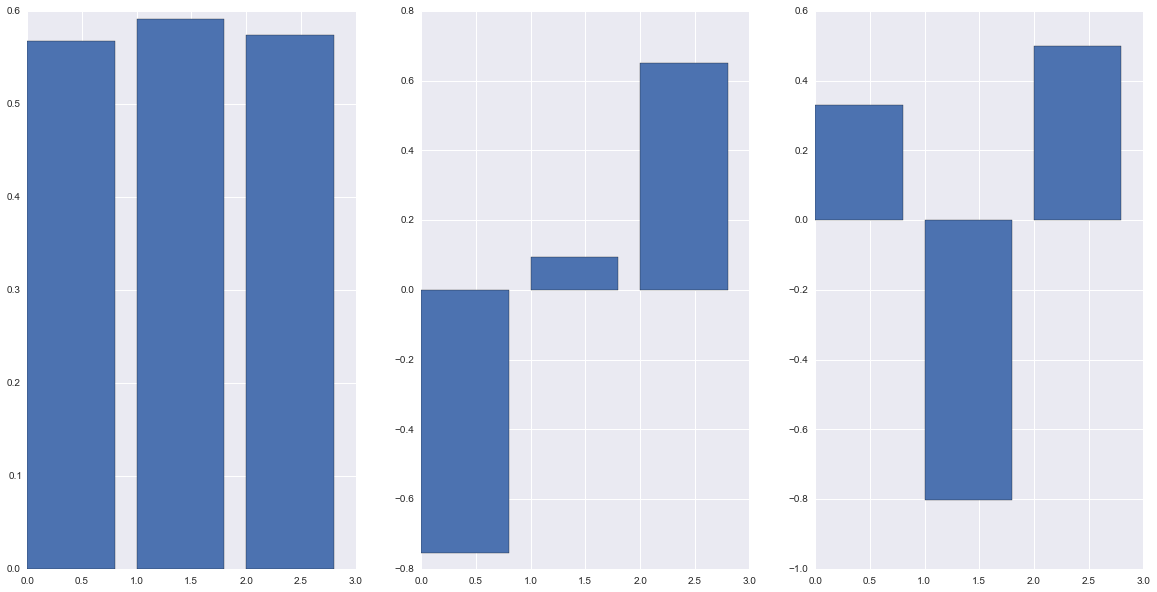

In [353]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(20, 10))
for i, vec in enumerate(np.identity(3)): 
    axes[i%3].bar(range(3),pca.inverse_transform(vec.T))

In [364]:
pca = PCA(n_components=2)
pca.fit_transform(scale(mixed_df[['pos_ex_sum','value_sum']]))
pca.explained_variance_ratio_

array([ 0.80572391,  0.19427609])

In [ ]:
scale?

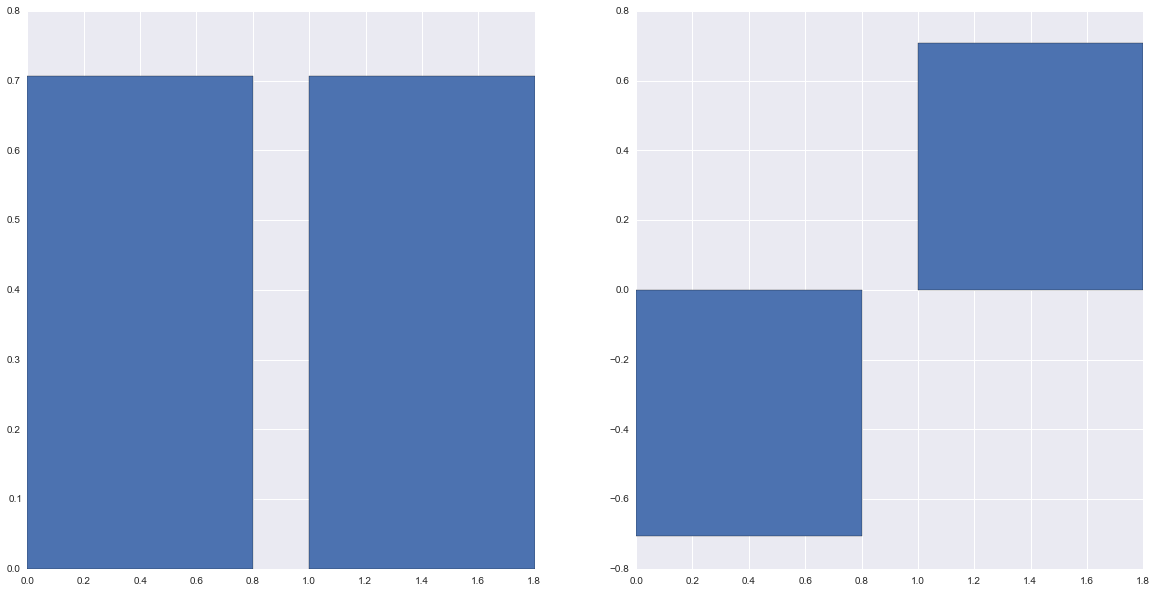

In [365]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(20, 10))
for i, vec in enumerate(np.identity(2)): 
    axes[i%2].bar(range(2),pca.inverse_transform(vec.T))

In [ ]:
'as dasd '.strip(')

In [491]:
def cohen_kappa_corr(df):
    columns = df.columns
    temp_df = pd.DataFrame(columns=columns, index=columns)
    for i, j in itertools.combinations_with_replacement(columns, 2):
        ck_value = cohen_kappa_score(mixed_df[i], mixed_df[j])
        temp_df[i][j] = ck_value
        temp_df[j][i] = ck_value
    
    temp_df = temp_df[temp_df.columns].astype(float)
    return temp_df

In [526]:
ck = cohen_kappa_corr(mixed_df[test_columns].drop(['context1_ ','context2_ ','context3_ ','context4_ ', 
                                                               'context5_ ','mutated_letter_ ','bool_pos1','bool_pos2',
                                                               'bool_pos3', 'context3_A','context3_C','context3_T','context3_G',
                                      'mutated_letter_A', 'mutated_letter_C', 'mutated_letter_T', 'mutated_letter_G'], axis=1))

In [519]:
ck.drop(['context1_ ', 'context2_ ','context3_ ','context4_ ','context5_ ', 'mutated_letter_ '], axis=1, inplace=True)
ck.drop(['context1_ ', 'context2_ ','context3_ ','context4_ ','context5_ ', 'mutated_letter_ '], axis=0, inplace=True)

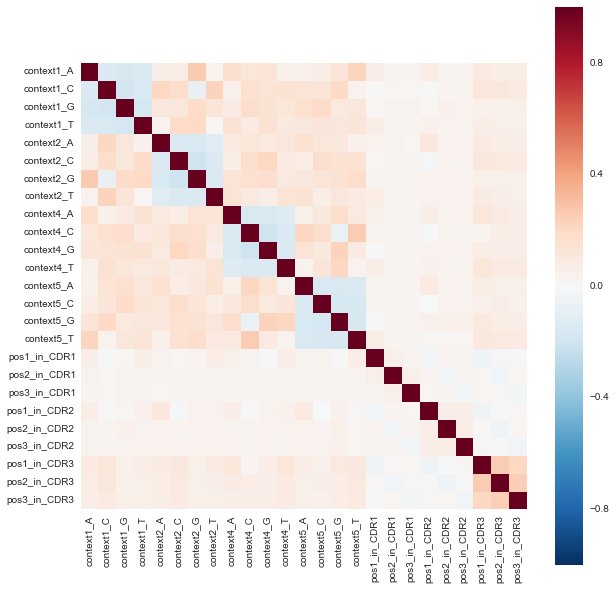

In [527]:
fig, ax = plt.subplots(figsize=(10,10))
sb.heatmap(ck, square=True, ax = ax)

In [524]:
cls = sm.OLS(mixed_df.quality_imp, mixed_df[test_columns].drop(['context1_ ','context2_ ','context3_ ','context4_ ', 
                                                               'context5_ ','mutated_letter_ ','bool_pos1','bool_pos2',
                                                               'bool_pos3', 'context3_A','context3_C','context3_T','context3_G',
                                      'mutated_letter_A', 'mutated_letter_C', 'mutated_letter_T', 'mutated_letter_G'], axis=1))

In [525]:
result = cls.fit_regularized()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            quality_imp   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.420
Method:                 Least Squares   F-statistic:                     1480.
Date:                Tue, 25 Jul 2017   Prob (F-statistic):               0.00
Time:                        20:39:01   Log-Likelihood:                -58455.
No. Observations:               51002   AIC:                         1.170e+05
Df Residuals:                   50977   BIC:                         1.172e+05
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
context1_A      -0.7578      0.381     -1.988      0.047        -1.505    -0.011
context1_C      -0.7044      0.381     -1.848      0.065        -1.451     0.043
context1_G      -0.7709      0.381     -2.023      0.043        -1.518    -0.024
context1_T      -0.7476      0.381     -1.962      0.050        -1.495    -0.001
context2_A      -0.0419      0.511     -0.082      0.935        -1.044     0.960
context2_C      -0.0585      0.511     -0.114      0.909        -1.060     0.943
context2_G      -0.0546      0.511     -0.107      0.915        -1.057     0.948
context2_T      -0.0600      0.511     -0.117      0.907        -1.062     0.942
context4_A      -0.1850      0.461     -0.401      0.688        -1.089     0.719
context4_C      -0.1302      0.462     -0.282      0.778        -1.035     0.774
context4_G      -0.1694      0.461     -0.367      0.714        -1.074     0.735
context4_T      -0.1218      0.462     -0.264      0.792        -1.027     0.783
context5_A       0.0263      0.311      0.085      0.933        -0.584     0.637
context5_C       0.0311      0.311      0.100      0.920        -0.579     0.641
context5_G       0.0116      0.311      0.037      0.970        -0.599     0.622
context5_T       0.0792      0.311      0.254      0.799        -0.531     0.689
pos1_in_CDR1     0.0261      0.021      1.226      0.220        -0.016     0.068
pos2_in_CDR1     0.0524      0.023      2.299      0.021         0.008     0.097
pos3_in_CDR1     0.0695      0.024      2.858      0.004         0.022     0.117
pos1_in_CDR2    -0.0096      0.021     -0.452      0.651        -0.051     0.032
pos2_in_CDR2    -0.0176      0.021     -0.845      0.398        -0.058     0.023
pos3_in_CDR2    -0.0222      0.021     -1.062      0.288        -0.063     0.019
pos1_in_CDR3     0.1395      0.014     10.006      0.000         0.112     0.167
pos2_in_CDR3     0.1655      0.015     11.241      0.000         0.137     0.194
pos3_in_CDR3     0.2198      0.015     14.260      0.000         0.190     0.250
==============================================================================
Omnibus:                    15551.781   Durbin-Watson:                   0.921
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            50529.902
Skew:                           1.558   Prob(JB):                         0.00
Kurtosis:                       6.751   Cond. No.                         301.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [530]:
result.params[result.pvalues <= 0.05].index

Index([u'context1_A', u'context1_G', u'context1_T', u'pos2_in_CDR1',
       u'pos3_in_CDR1', u'pos1_in_CDR3', u'pos2_in_CDR3', u'pos3_in_CDR3'],
      dtype='object')

In [679]:
t = SelectKBest(k = 3)
X = pd.concat([flu_df[['second_vote_std','size','pos_ex_value_sum','CDR_sum']], fl[['pos1_in_CDR3','pos2_in_CDR3','pos3_in_CDR3']]], axis=1)
y = mixed_df.quality_imp
t.fit_transform(X, y)

array([[  5.31510383e-03,   5.20000000e+01,   7.00961538e+01],
       [  2.47995284e-02,   2.70000000e+01,   2.10296296e+02],
       [  2.43050867e-02,   2.30000000e+01,   7.38304348e+02],
       ..., 
       [  0.00000000e+00,   1.00000000e+00,   0.00000000e+00],
       [  0.00000000e+00,   2.00000000e+00,   2.86500000e+02],
       [  0.00000000e+00,   2.00000000e+00,   0.00000000e+00]])

In [560]:
X.columns[t.get_support()]

Index([u'second_vote_std', u'size', u'pos_ex_value_sum'], dtype='object')

In [739]:
cls = LogisticRegression(penalty='l1')
#cls = RandomForestClassifier(n_estimators=1000)

clf = GridSearchCV(estimator=cls, param_grid={'max_depth': range(1,2,6)}, scoring='roc_auc', cv=5)

X_flu_train, X_flu_test, y_flu_train, y_flu_test = train_test_split(flu_df[['second_vote_std','size', 'CDR_sum', 'pos_ex_value_sum',
                                                                           'pos1_in_CDR3', 'pos2_in_CDR3','pos3_in_CDR3']],
                                                    flu_df.quality_imp, test_size=0.2, 
                                                    train_size=0.8, stratify=flu_df.quality_imp)
X_age3_train, X_age3_test, y_age3_train, y_age3_test = train_test_split(age3_df[['second_vote_std','size', 'CDR_sum', 'pos_ex_value_sum',
                                                                            'pos1_in_CDR3', 'pos2_in_CDR3','pos3_in_CDR3']], 
                                                    age3_df.quality_imp, test_size=0.2, 
                                                    train_size=0.8, stratify=age3_df.quality_imp)
X_train = pd.concat([X_flu_train, X_age3_train])
X_test = pd.concat([X_flu_test, X_age3_test])
y_train = pd.concat([y_flu_train, y_age3_train])
y_test = pd.concat([y_flu_test, y_age3_test])
                                                                        
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1, param_grid={'max_depth': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [ ]:
roc_auc_score(y_test, clf.best_estimator_.predict_proba(X_test)[:,1])

In [ ]:
roc_auc_score(y_flu_test, clf.best_estimator_.predict_proba(X_age3_test)[:,1])

In [ ]:
roc_auc_score(y_age3_test, clf.best_estimator_.predict_proba(X_age3_test)[:,1])

In [740]:
cls = LogisticRegression(penalty='l1')
#cls = RandomForestClassifier(n_estimators=100)

clf = GridSearchCV(estimator=cls, param_grid={'C': np.linspace(1e-5, 1, 5)}, scoring='roc_auc', cv=5)

X_flu_train, X_flu_test, y_flu_train, y_flu_test = train_test_split(flu_df[['size', 'value1']],
                                                    flu_df.quality_imp, test_size=0.2, 
                                                    train_size=0.8, stratify=flu_df.quality_imp)
X_age3_train, X_age3_test, y_age3_train, y_age3_test = train_test_split(age3_df[['size', 'value1']], 
                                                    age3_df.quality_imp, test_size=0.2, 
                                                    train_size=0.8, stratify=age3_df.quality_imp)
X_train = pd.concat([X_flu_train, X_age3_train])
X_test = pd.concat([X_flu_test, X_age3_test])
y_train = pd.concat([y_flu_train, y_age3_train])
y_test = pd.concat([y_flu_test, y_age3_test])
                                                                        
clf.fit(X_flu_train, y_flu_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'C': array([  1.00000e-05,   2.50007e-01,   5.00005e-01,   7.50003e-01,
         1.00000e+00])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [741]:
roc_auc_score(y_flu_test, clf.best_estimator_.predict_proba(X_flu_test)[:,1])

0.97754159160833454

In [742]:
roc_auc_score(y_flu_test, clf.best_estimator_.predict_proba(X_flu_test)[:,1])

0.97754159160833454

In [743]:
roc_auc_score(age3_df.quality_imp, clf.best_estimator_.predict_proba(age3_df[['size', 'value1']])[:,1])

0.94001556169837164

In [738]:
clf.best_estimator_.feature_importances_

array([ 0.61949232,  0.38050768])

([<matplotlib.axis.XTick at 0x137855a10>,
 <a list of 7 Text xticklabel objects>)

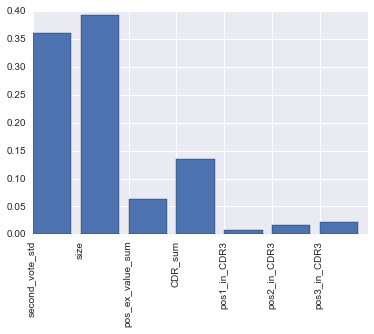

In [564]:
plt.bar(range(len(X.columns)), clf.best_estimator_.feature_importances_)
plt.xticks(range(len(X.columns)), X.columns, rotation=90)

In [603]:
clf.best_params_['C']

0.70707070999999999

In [686]:
cls = sm.OLS(y, sm.add_constant(np.hstack([scale(mixed_df[['second_vote_std', 'size', 'CDR_sum', 'pos_ex_value_sum']]),
                            mixed_df[['pos1_in_CDR3','pos2_in_CDR3','pos3_in_CDR3']]])))
result = cls.fit_regularized(alpha=clf.best_params_['C'])
result.summary()

KeyError: 'C'

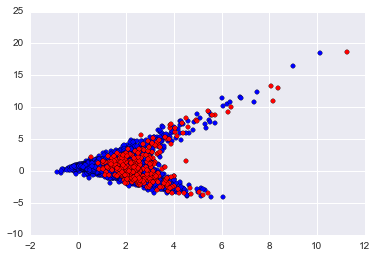

In [656]:
pca = PCA(n_components=3)
pca_representation = pca.fit_transform(np.hstack([scale(mixed_df[['second_vote_std', 'size', 'CDR_sum', 'pos_ex_value_sum']]),
                            mixed_df[['pos1_in_CDR3','pos2_in_CDR3','pos3_in_CDR3']]]))
dots = np.array(zip(pca_representation, list(scaled_age3_df.quality_imp)))
fig = plt.figure()
plt.scatter([x[0] for x in dots[dots[:, 1]==-1][:, 0]], [x[1] for x in dots[dots[:, 1]==-1][:, 0]], c='b')
plt.scatter([x[0] for x in dots[dots[:, 1]==1][:, 0]], [x[1] for x in dots[dots[:, 1]==1][:, 0]], c='r')

In [653]:
from mpl_toolkits.mplot3d import Axes3D

In [673]:
dots[dots[:,1] == -1][:, 0][:, 0]

IndexError: too many indices for array

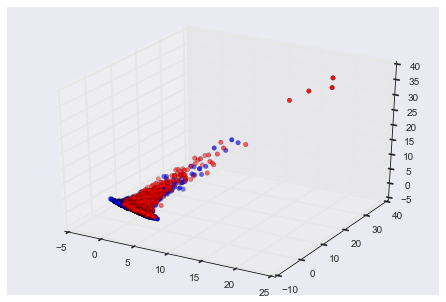

In [676]:
fig = plt.figure()
ax = Axes3D(fig)

dots = np.array(zip(pca_representation, list(mixed_df.quality_imp)))
ax.scatter([x[0] for x in dots[dots[:, 1]==-1][:, 0]], [x[1] for x in dots[dots[:, 1]==-1][:, 0]],
           [x[2] for x in dots[dots[:, 1]==-1][:, 0]], c='b')
ax.scatter([x[0] for x in dots[dots[:, 1]==1][:, 0]], [x[1] for x in dots[dots[:, 1]==1][:, 0]],
           [x[2] for x in dots[dots[:, 1]==1][:, 0]], c='r')

In [691]:
cls = sm.OLS(mixed_df.quality_imp, mixed_df[['second_vote_std', 'size', 'CDR_sum', 'pos_ex_value_sum',
                                             'pos1_in_CDR3','pos2_in_CDR3','pos3_in_CDR3']])
result = cls.fit_regularized(alpha=1)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            quality_imp   R-squared:                       0.866
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                 4.701e+04
Date:                Wed, 26 Jul 2017   Prob (F-statistic):               0.00
Time:                        18:48:58   Log-Likelihood:                -21145.
No. Observations:               51002   AIC:                         4.230e+04
Df Residuals:                   50995   BIC:                         4.237e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------
second_vote_std           0          0        nan        nan             0         0
size                 0.0021   3.72e-05     56.697      0.000         0.002     0.002
CDR_sum             -0.0010    2.1e-06   -458.535      0.000        -0.001    -0.001
pos_ex_value_sum     0.0003   6.47e-06     53.149      0.000         0.000     0.000
pos1_in_CDR3              0          0        nan        nan             0         0
pos2_in_CDR3              0          0        nan        nan             0         0
pos3_in_CDR3              0          0        nan        nan             0         0
==============================================================================
Omnibus:                    41029.931   Durbin-Watson:                   1.868
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           753705.670
Skew:                           3.944   Prob(JB):                         0.00
Kurtosis:                      20.101   Cond. No.                     4.79e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.79e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

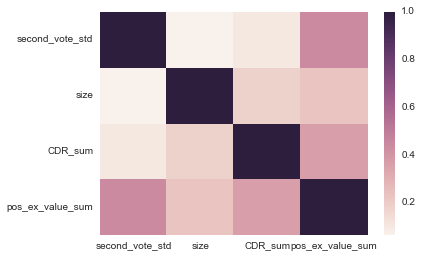

In [710]:
sb.heatmap(mixed_df[['second_vote_std', 'size', 'CDR_sum', 'pos_ex_value_sum']].corr())

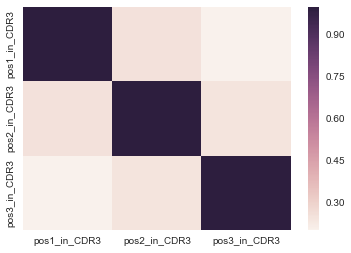

In [712]:
sb.heatmap(cohen_kappa_corr(mixed_df[['pos1_in_CDR3','pos2_in_CDR3','pos3_in_CDR3']]))

In [744]:
age3_df.to_csv('data/age3/age3_df.csv')

In [748]:
flu_df.to_csv('data/flu/flu_df.csv')